In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load ATP Match Data

Downloads yearly match data and combines it into a single DataFrame (all_matches).

In [65]:
# Years to include
start_year = 2000
end_year = 2025
years = range(start_year, end_year)     # 2025 is exclusive
                                        # Could put years from 1968

# Base URL to the raw GitHub files
base_url = "https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_{}.csv"

# Create empty list to store all DataFrames
dfs = []

# Loop through each year, read the CSV, and append to list
for year in years:
    url = base_url.format(year)
    try:
        df = pd.read_csv(url)
        df['year'] = year  # Add year column for later filtering
        dfs.append(df)
    except Exception as e:
        print(f"Could not load {year}: {e}")

# Combine all years into one big DataFrame
all_matches = pd.concat(dfs, ignore_index=True)
print("All match data loaded!")

All match data loaded!


# Filter Major Tournaments

Selects matches from:
- Grand Slams
- Masters 1000
- ATP Finals
- Olympics

In [66]:
# Filter Grand Slams, Masters 1000, ATP Finals, Olympics
major_matches = all_matches[
    (all_matches['tourney_level'].isin(['G', 'M', 'F'])) |
    (all_matches['tourney_name'].str.contains("Olympics", na=False))
]


# Grand Slam 

## GOAT Ranking Logic - Grand Slam Finals (Per Year)

This section assigns a **GOAT rank** to players based on their performance in Grand Skam finals for each year.
Each row in the resulting table represents a player who won at least one Grand Slam final in a given year.

### Ranking Criteria:
1. Grand Slam titles: Players are ranked first by the number of Grand Slam finals they won in a season (maximum of 4). More titles = higher rank.
2. Combined performance score used as a tiebreaker when titles are equal: When two or more players have the same number of titles, a composite score is calculated to break the tie. This score combines:
    - Total aces served in thei Grand Slam final wins
    - Average first serve win percentage across those finals
To ensure fairness, both values are normalized within each year, then added together. 

### Final Table Overview
The final table includes for each player and year:
- Grand Slam titles
- Total aces
- 2st serve win %
- Normalized scores
- GOAT rank within the year

This method highlights not just who won the most, but also how dominant they were in their finals - giving credit for serving performance when titles alone don't separate the best.

In [ ]:
# Step 1: Filter Grand Slam finals (ATP)
slam_finals = major_matches[
    (major_matches['tourney_level'] == 'G') &
    (major_matches['round'] == 'F')
].copy()

# Step 2: Count titles per player per year
goat_slam_winners = slam_finals.groupby(['year', 'winner_name']).size().reset_index(name='titles')

# Step 3A: Total aces per year per winner
aces = slam_finals.groupby(['year', 'winner_name'])['w_ace'].sum().reset_index(name='total_aces')

# Step 3B: Average 1st serve win % per winner
slam_finals['1st_win_pct'] = slam_finals['w_1stWon'] / slam_finals['w_1stIn']
first_serve_pct = slam_finals.groupby(['year', 'winner_name'])['1st_win_pct'].mean().reset_index()

# Step 4: Merge all stats into one DataFrame
goat_data = goat_slam_winners.merge(aces, on=['year', 'winner_name'], how='left')
goat_data = goat_data.merge(first_serve_pct, on=['year', 'winner_name'], how='left')

# Step 5: Clean missing values
goat_data['total_aces'] = goat_data['total_aces'].fillna(0)
goat_data['1st_win_pct'] = goat_data['1st_win_pct'].fillna(0)

# Step 6: Remove players with zero in BOTH tie-breaker metrics
goat_data = goat_data[~((goat_data['total_aces'] == 0) & (goat_data['1st_win_pct'] == 0))]

# Step 7: Normalize ALL metrics (titles, aces, serve %) per year
scaler = MinMaxScaler()

goat_data['titles_norm'] = goat_data.groupby('year')['titles'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

goat_data['aces_norm'] = goat_data.groupby('year')['total_aces'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

goat_data['serve_norm'] = goat_data.groupby('year')['1st_win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Step 8: Create combined GOAT score
goat_data['GOAT_score'] = (
    goat_data['titles_norm'] +
    goat_data['aces_norm'] +
    goat_data['serve_norm']
)

# Step 9: Rank by GOAT score per year
goat_data = goat_data.sort_values(by=['year', 'GOAT_score'], ascending=[True, False])
goat_data['GOAT_rank'] = goat_data.groupby('year').cumcount() + 1

# Step 10: Print result
start_year = goat_data['year'].min()
end_year = goat_data['year'].max()

print(f"Annual Grand Slam GOAT Rankings ({start_year} - {end_year}) — Based on Normalized Titles, Aces, and 1st Serve Win %")
print(goat_data[['year', 'winner_name', 'titles', 'total_aces', '1st_win_pct', 'GOAT_score', 'GOAT_rank']])


Annual Grand Slam GOAT Rankings (2000 - 2024) — Based on Normalized Titles, Aces, and 1st Serve Win %
    year       winner_name  titles  total_aces  1st_win_pct  GOAT_score  \
3   2000      Pete Sampras       1        24.0     0.880952    2.000000   
2   2000       Marat Safin       1        12.0     0.850000    1.049474   
1   2000   Gustavo Kuerten       1         9.0     0.732394    0.277539   
0   2000      Andre Agassi       1         9.0     0.675325    0.000000   
5   2001  Goran Ivanisevic       1        27.0     0.813187    1.834508   
..   ...               ...     ...         ...          ...         ...   
63  2022    Carlos Alcaraz       1        14.0     0.741176    0.909091   
67  2023    Novak Djokovic       3        22.0     0.809679    3.000000   
66  2023    Carlos Alcaraz       1         9.0     0.702128    0.000000   
69  2024     Jannik Sinner       2        20.0     0.811179    2.000000   
68  2024    Carlos Alcaraz       2         8.0     0.742560    0.000000  

### Grand Slam GOAT Score — Breakdown by Titles, Aces, and 1st Serve Win % per Year

This section visualizes the **Top players** in each year's **Grand Slam finals** based on their **GOAT score**, which combines:
- **Titles won** (number of Grand Slam finals won)
- **Aces** (total number of aces served in finals)
- **1st serve win %** (efficiency on first serve)

For each year, we display:
1. **A main bar chart** showing the **GOAT score** for the top players (which combines all three metrics).
2. **Three smaller subplots** showing:
   - **Titles won**
   - **Total aces**
   - **1st serve win %**
   
These smaller subplots provide context to understand the individual contributions of **titles**, **aces**, and **serve performance**, helping explain the rankings of each player.

The layout is structured as a grid of charts, where each year’s top players are shown in an easy-to-read format for comparison.


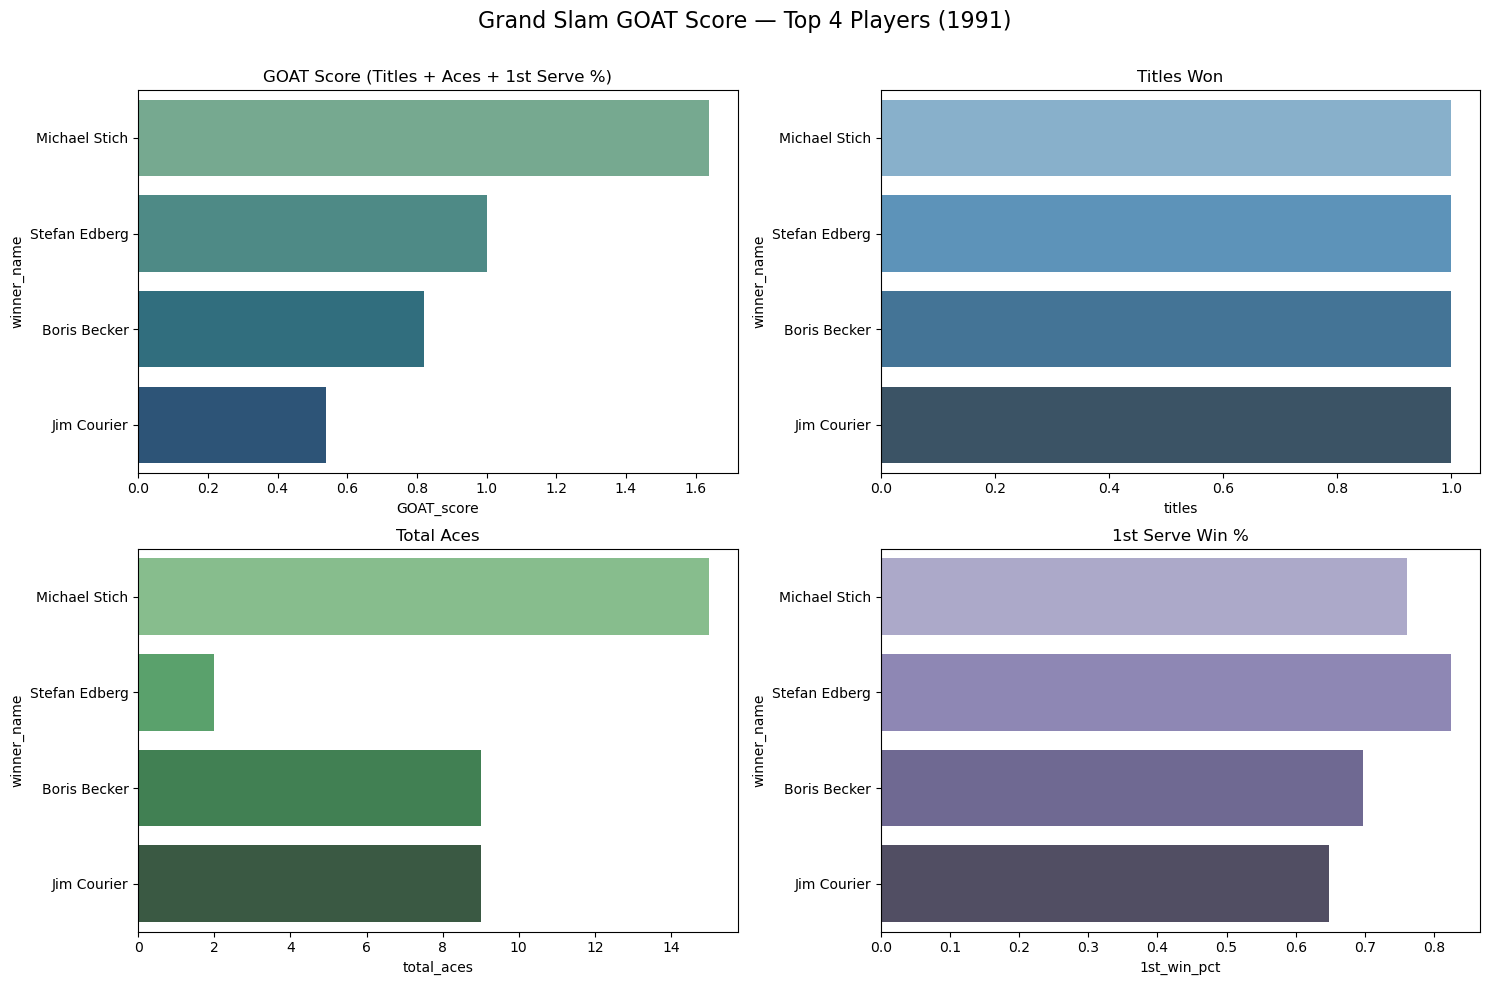

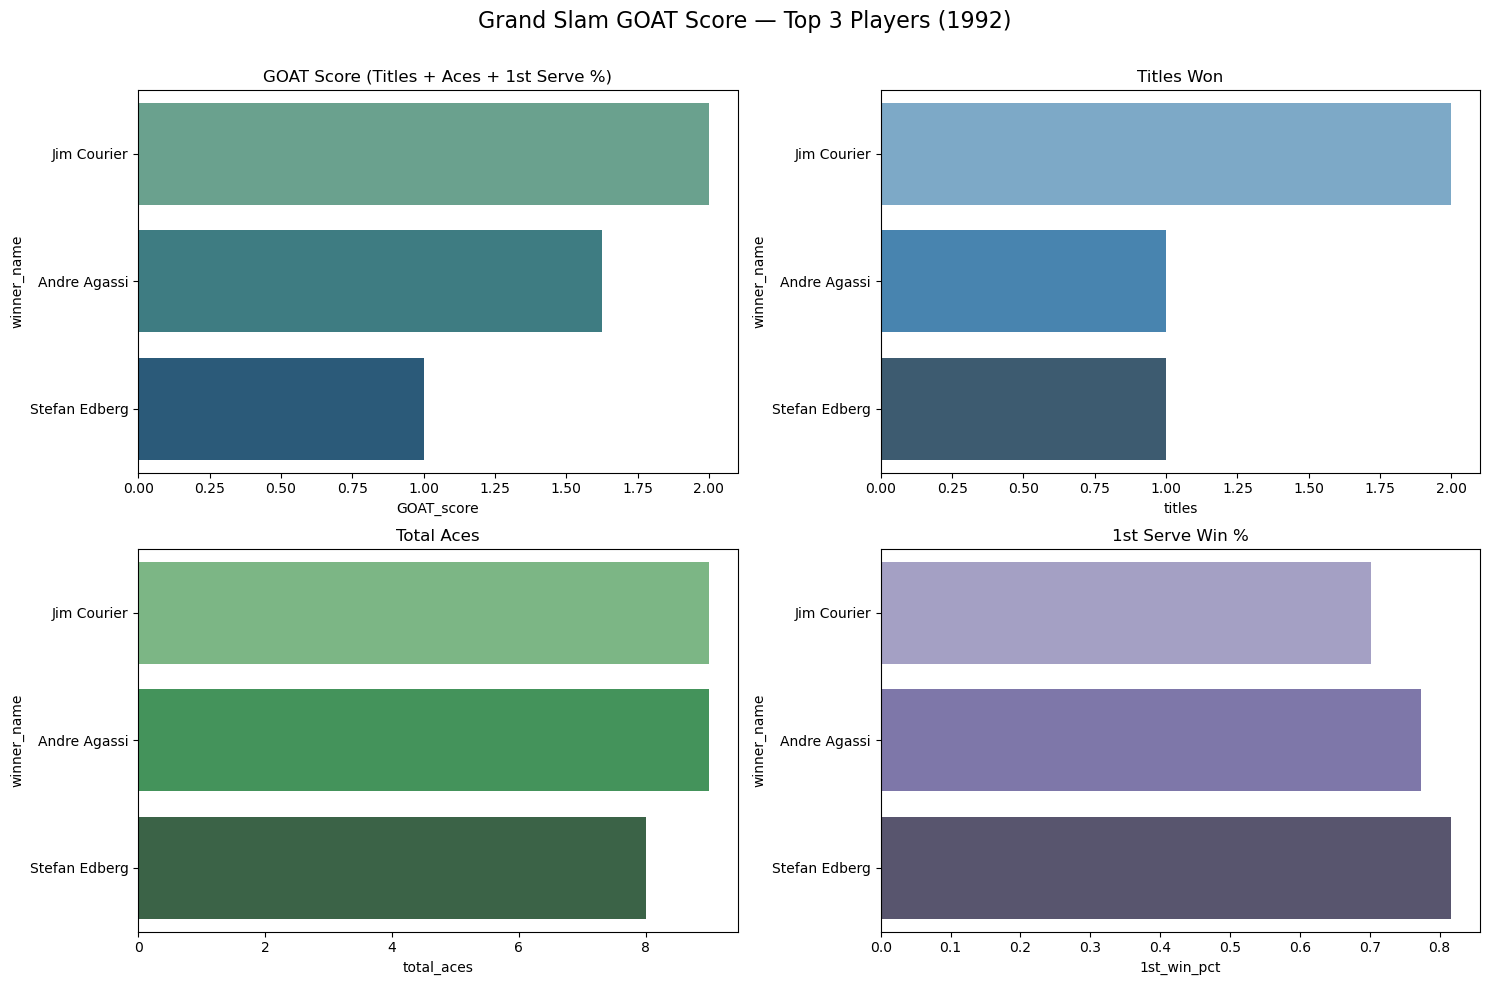

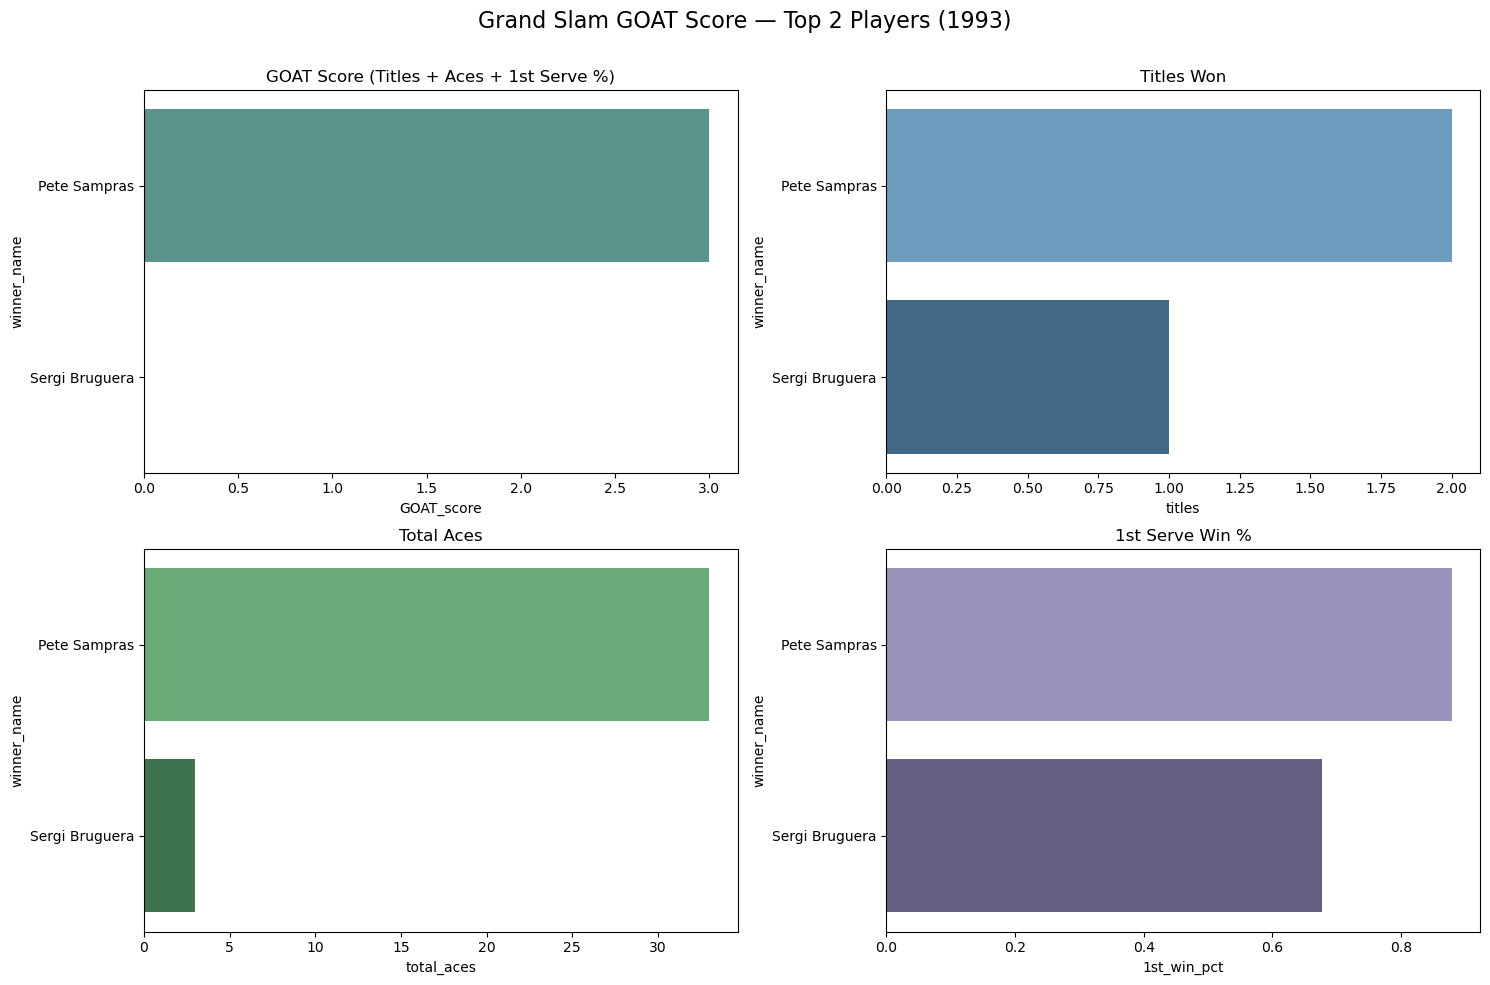

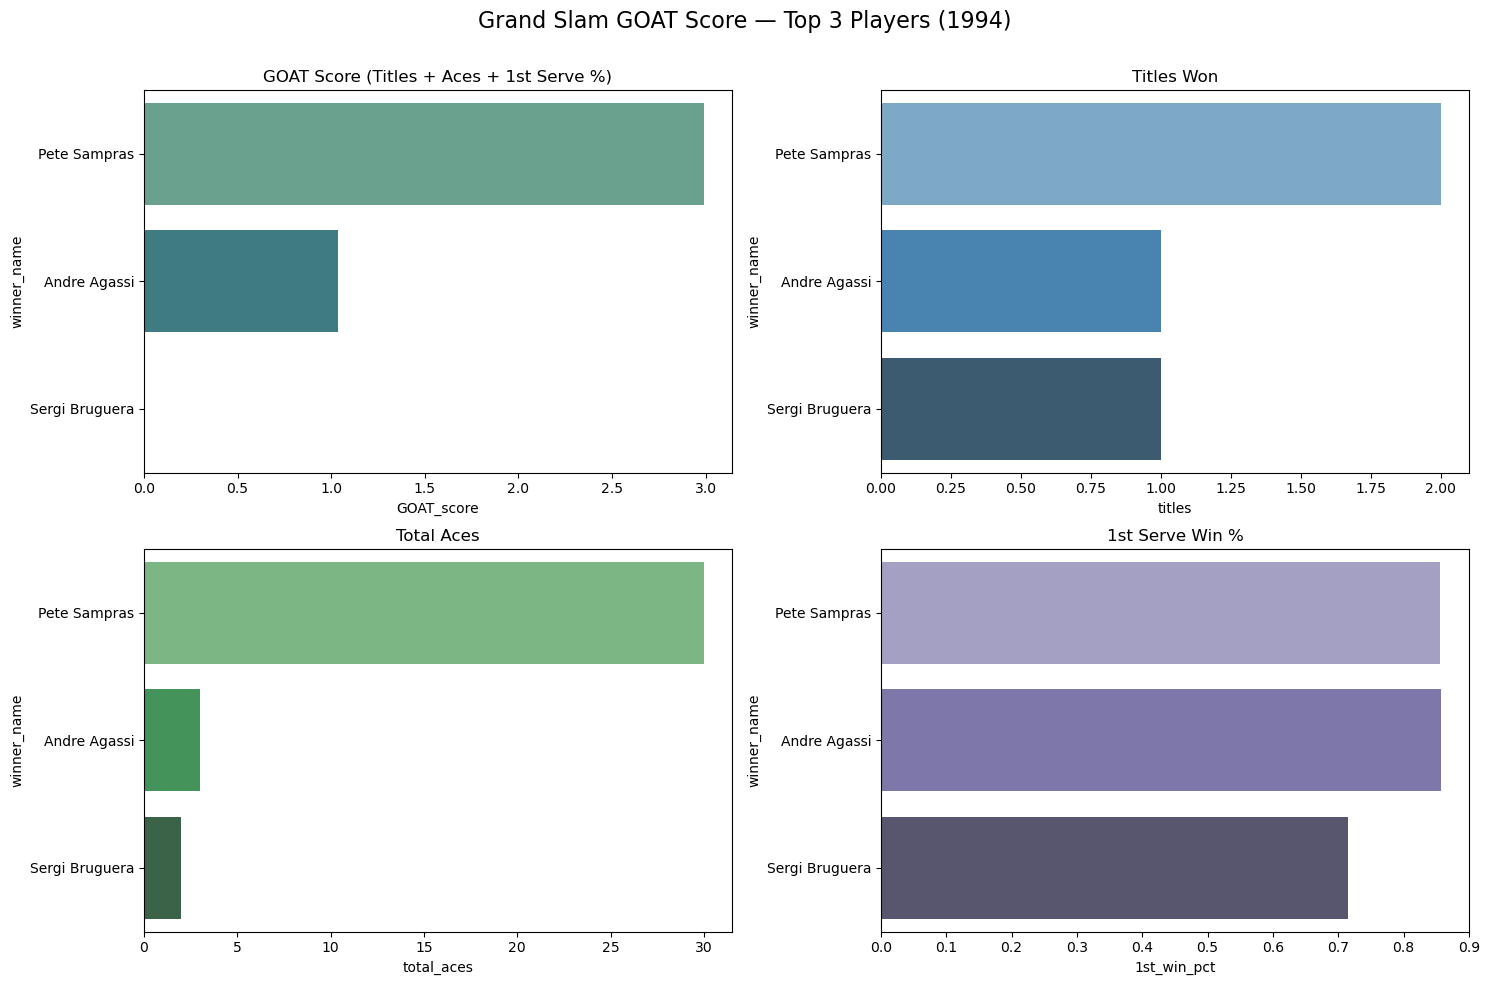

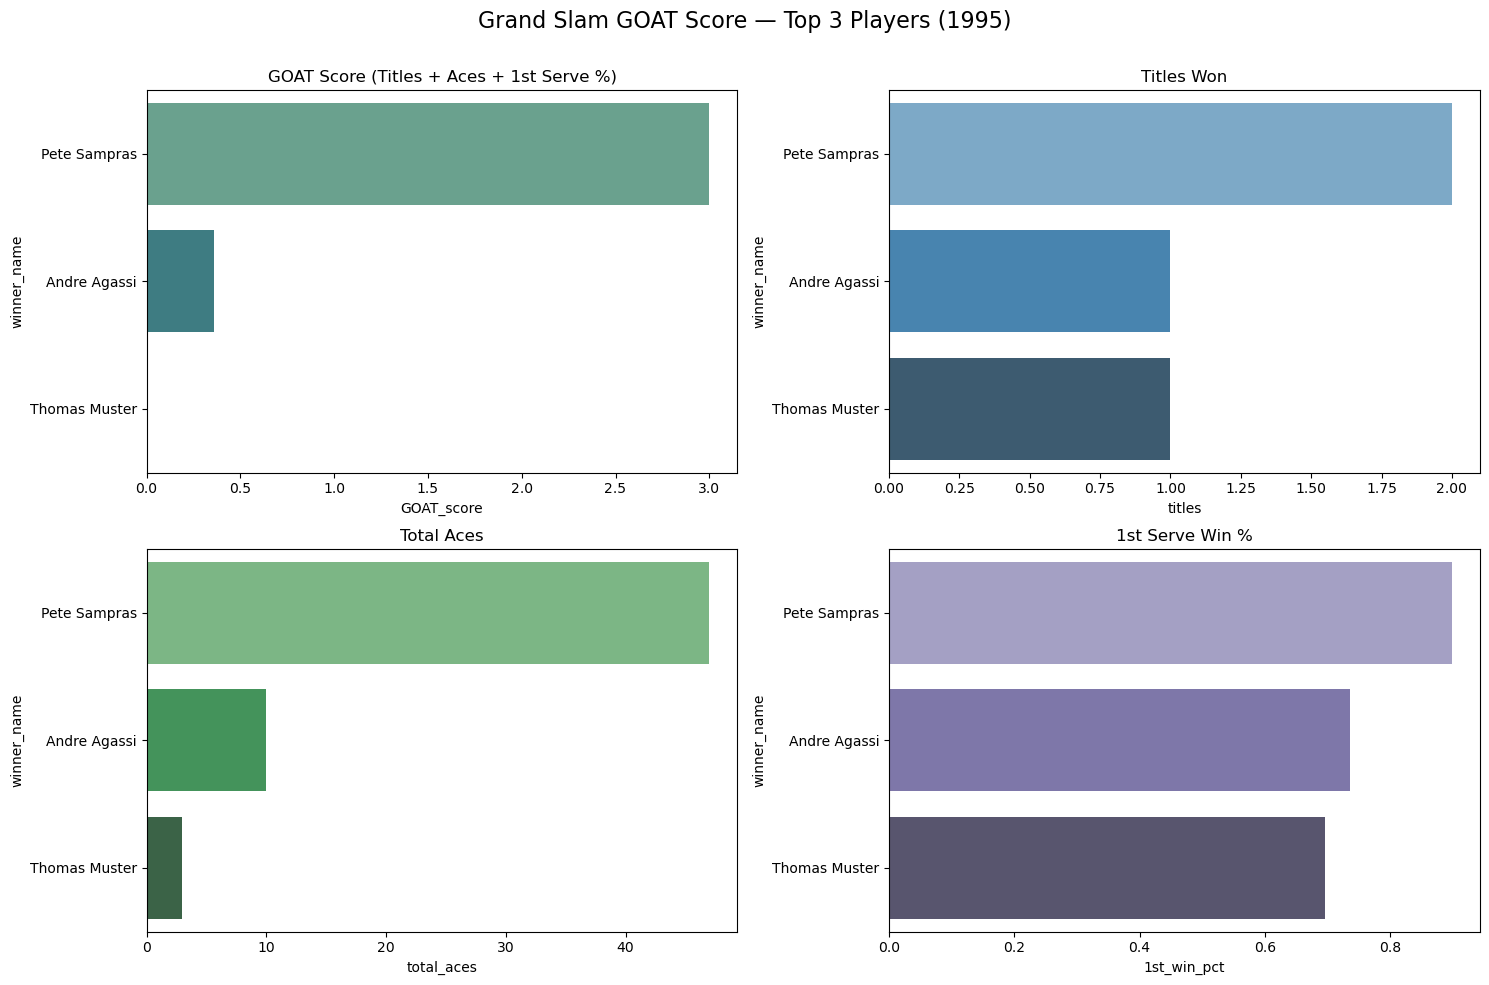

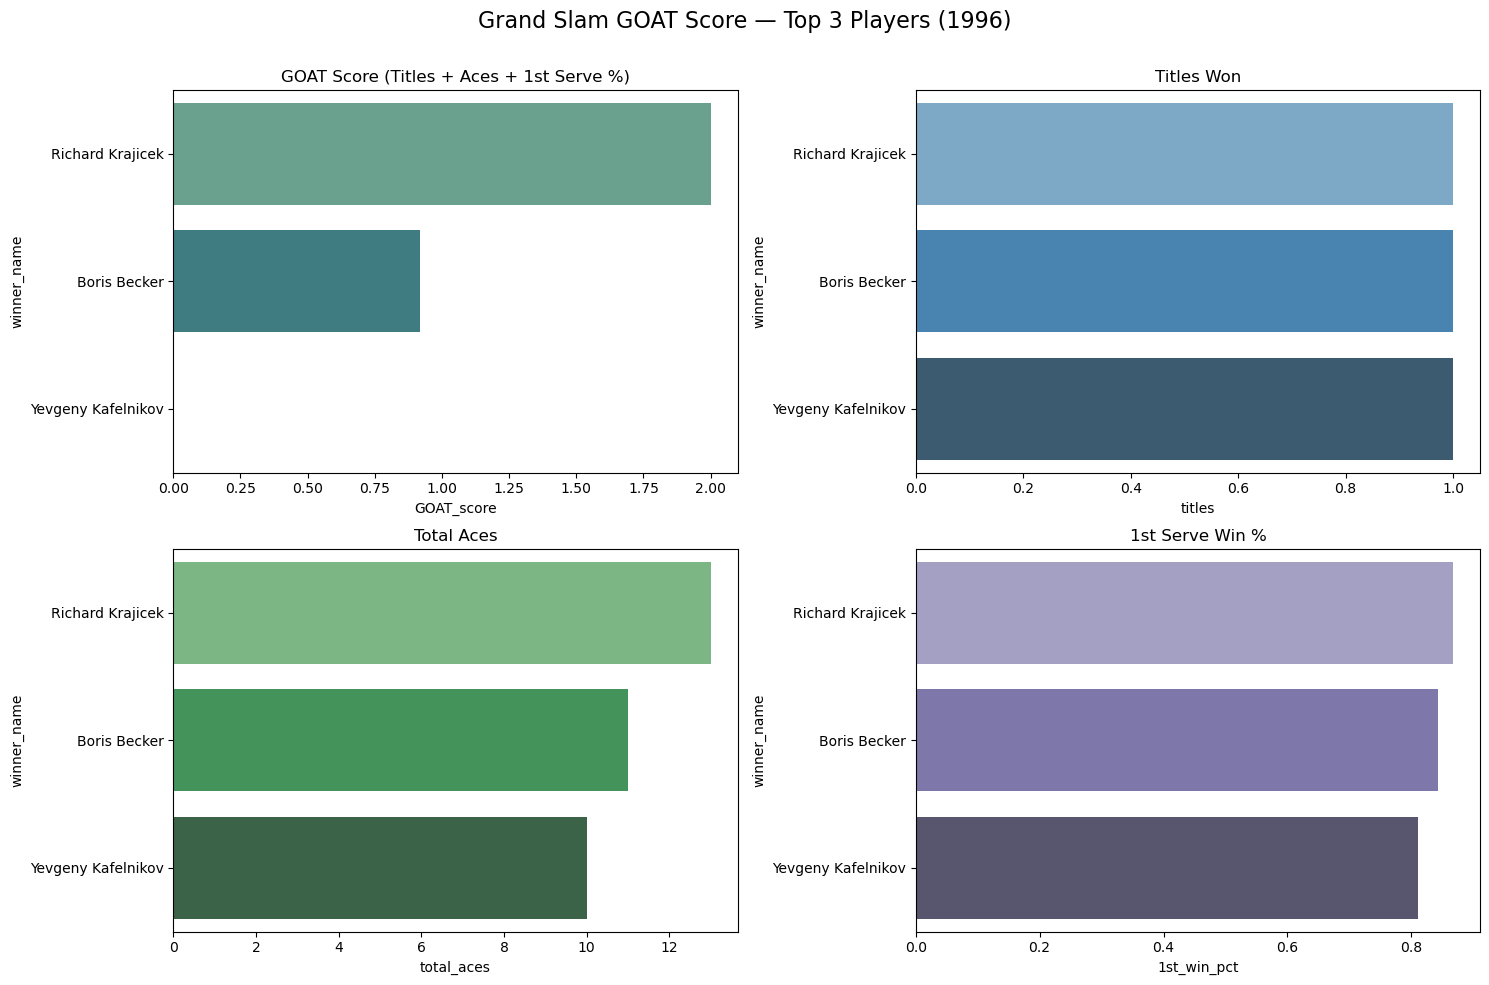

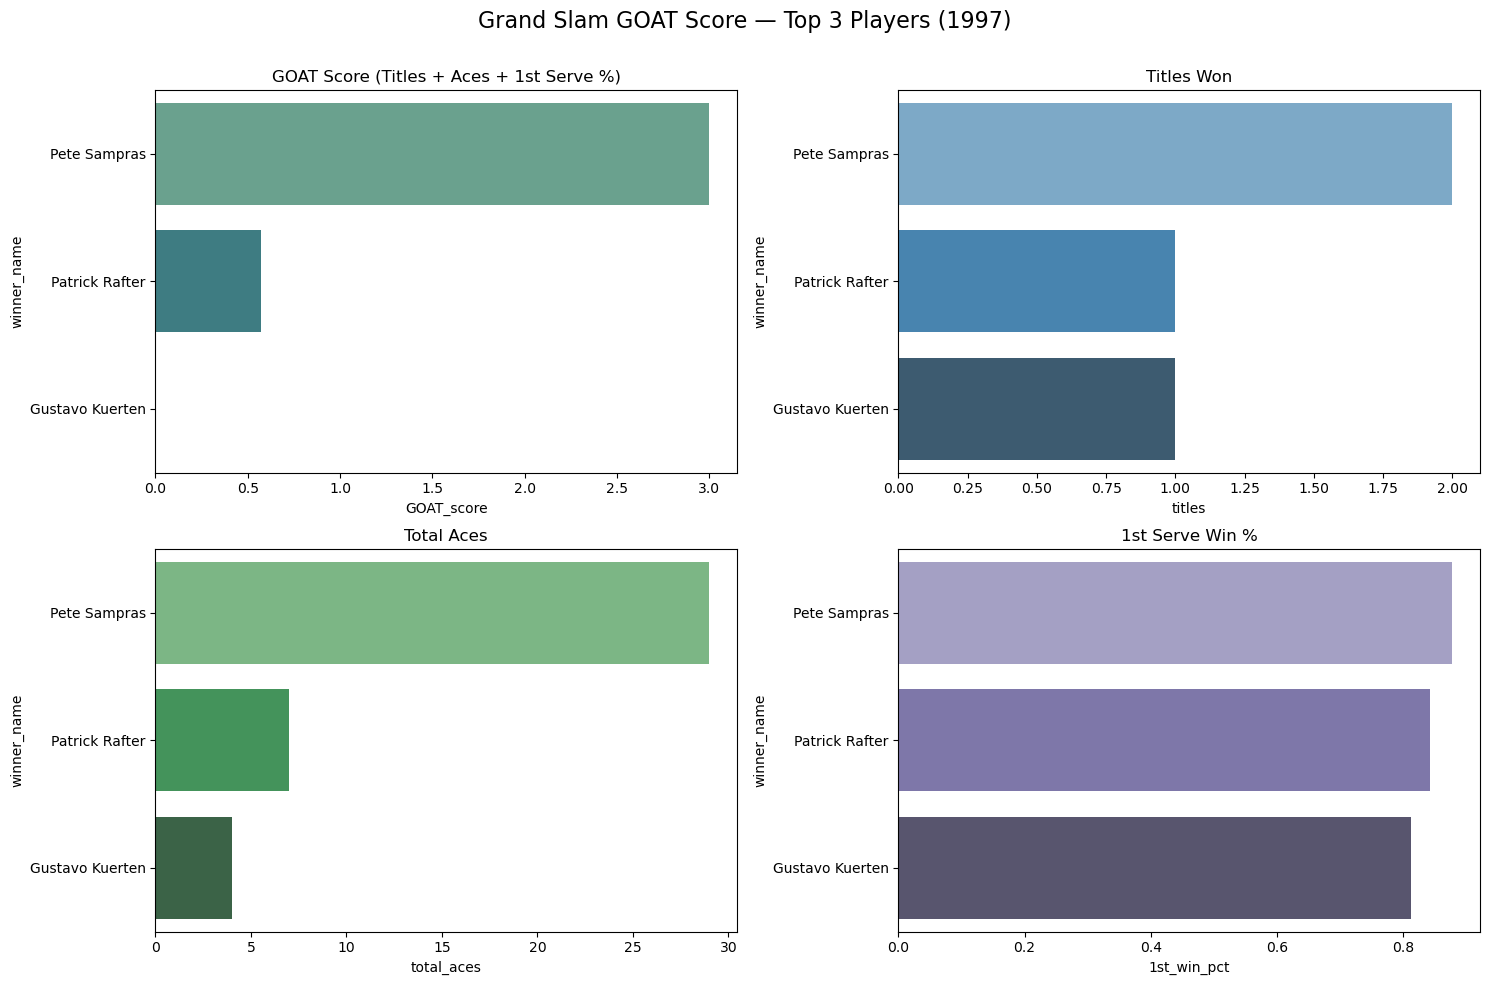

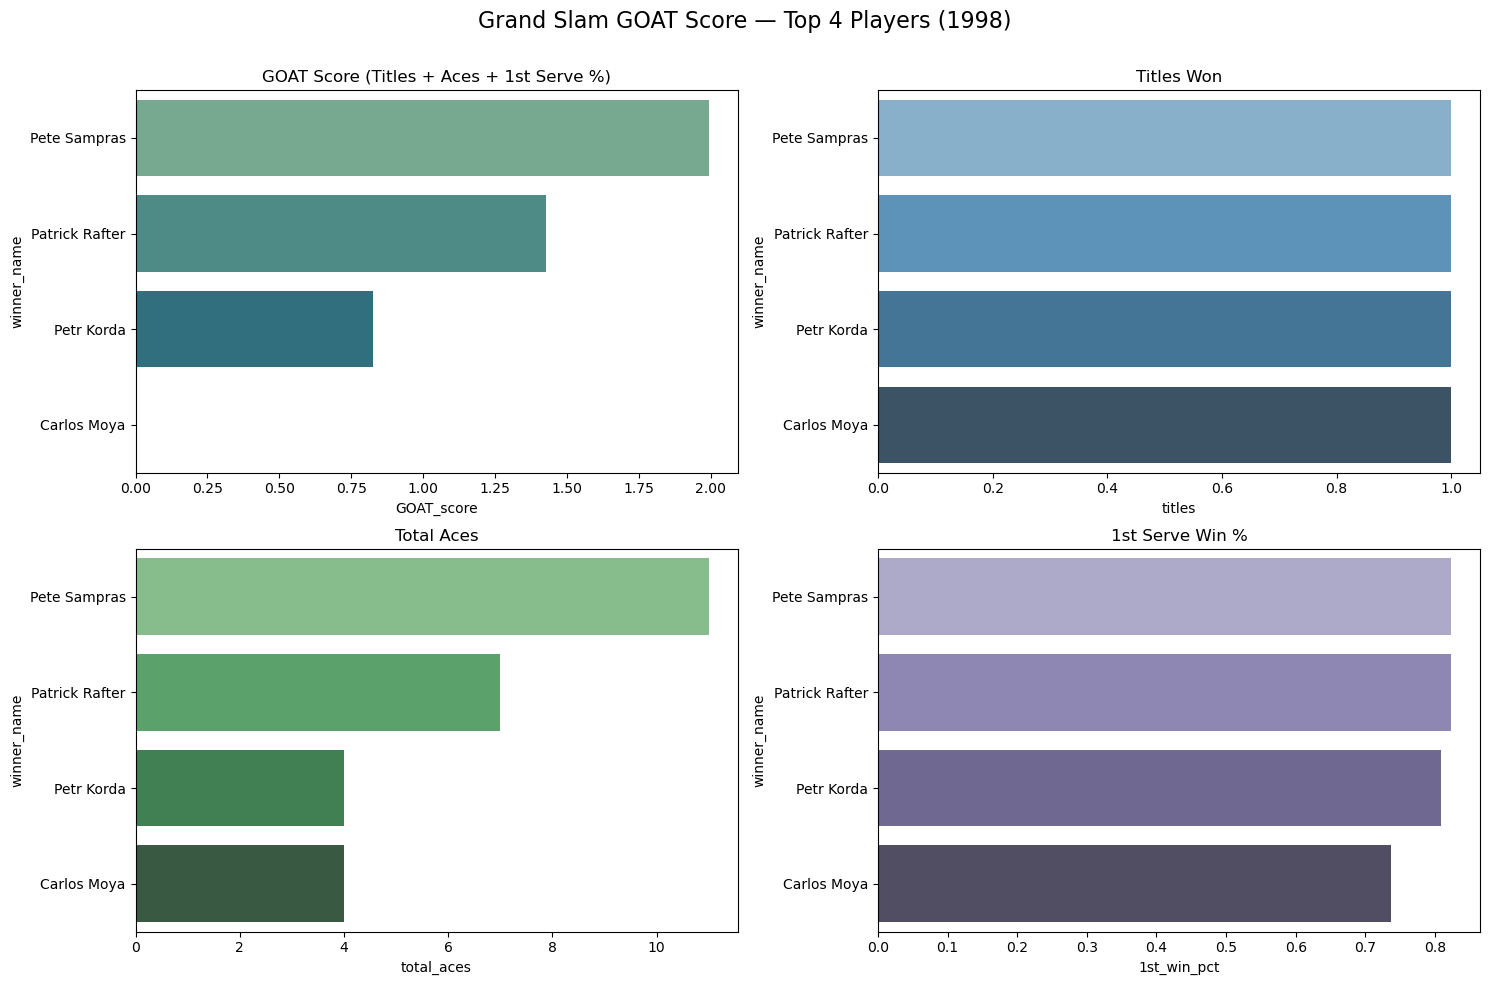

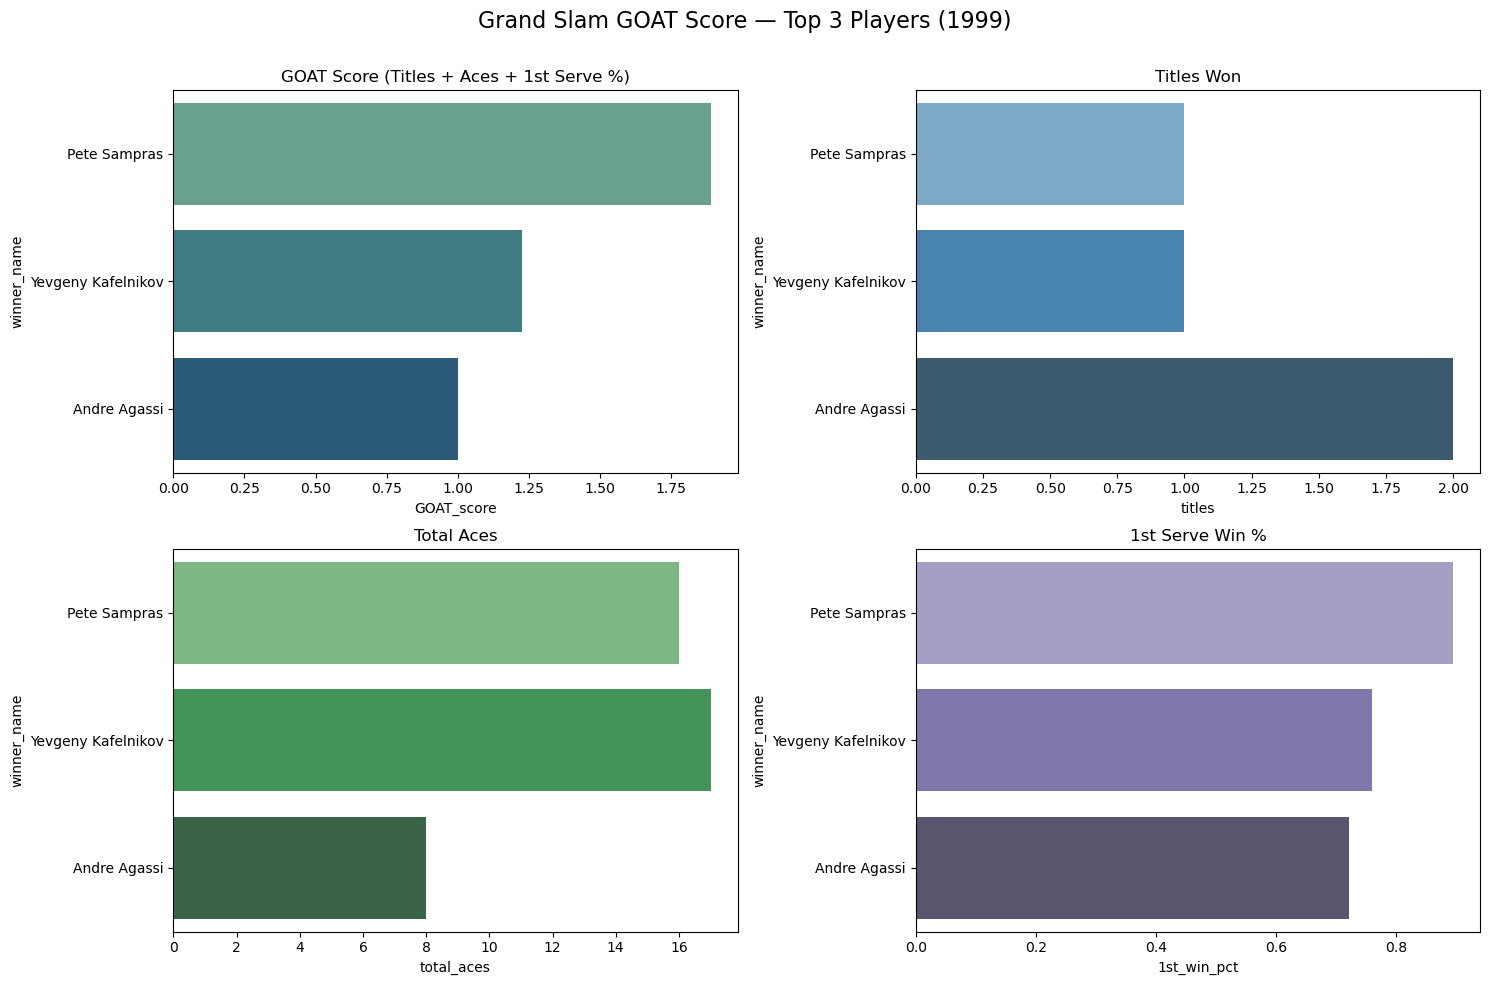

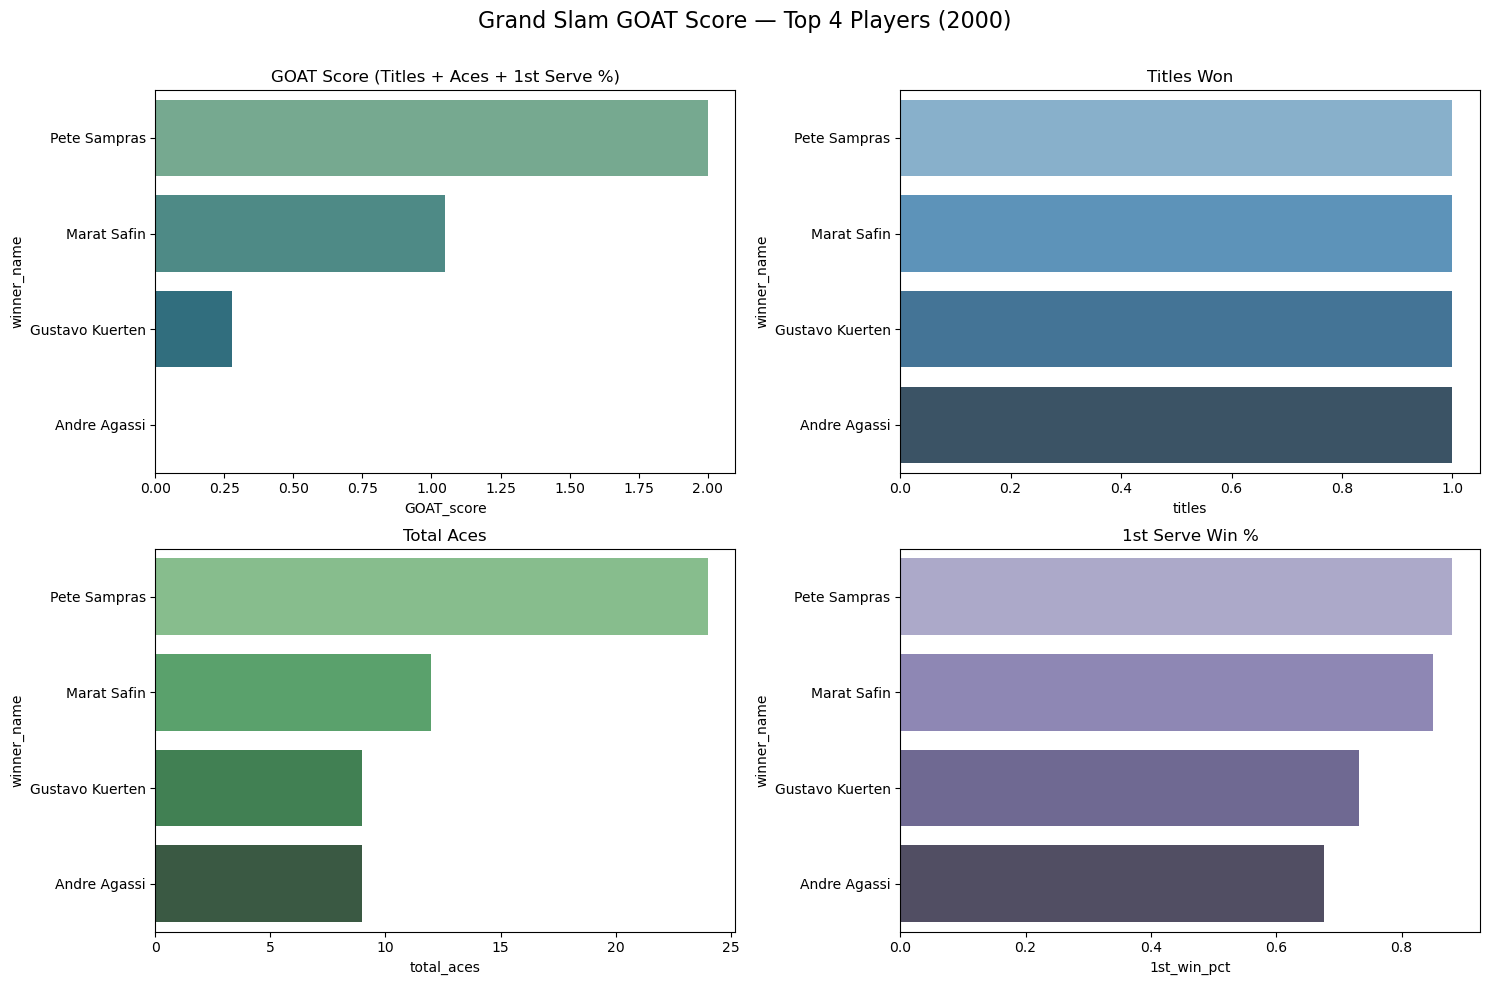

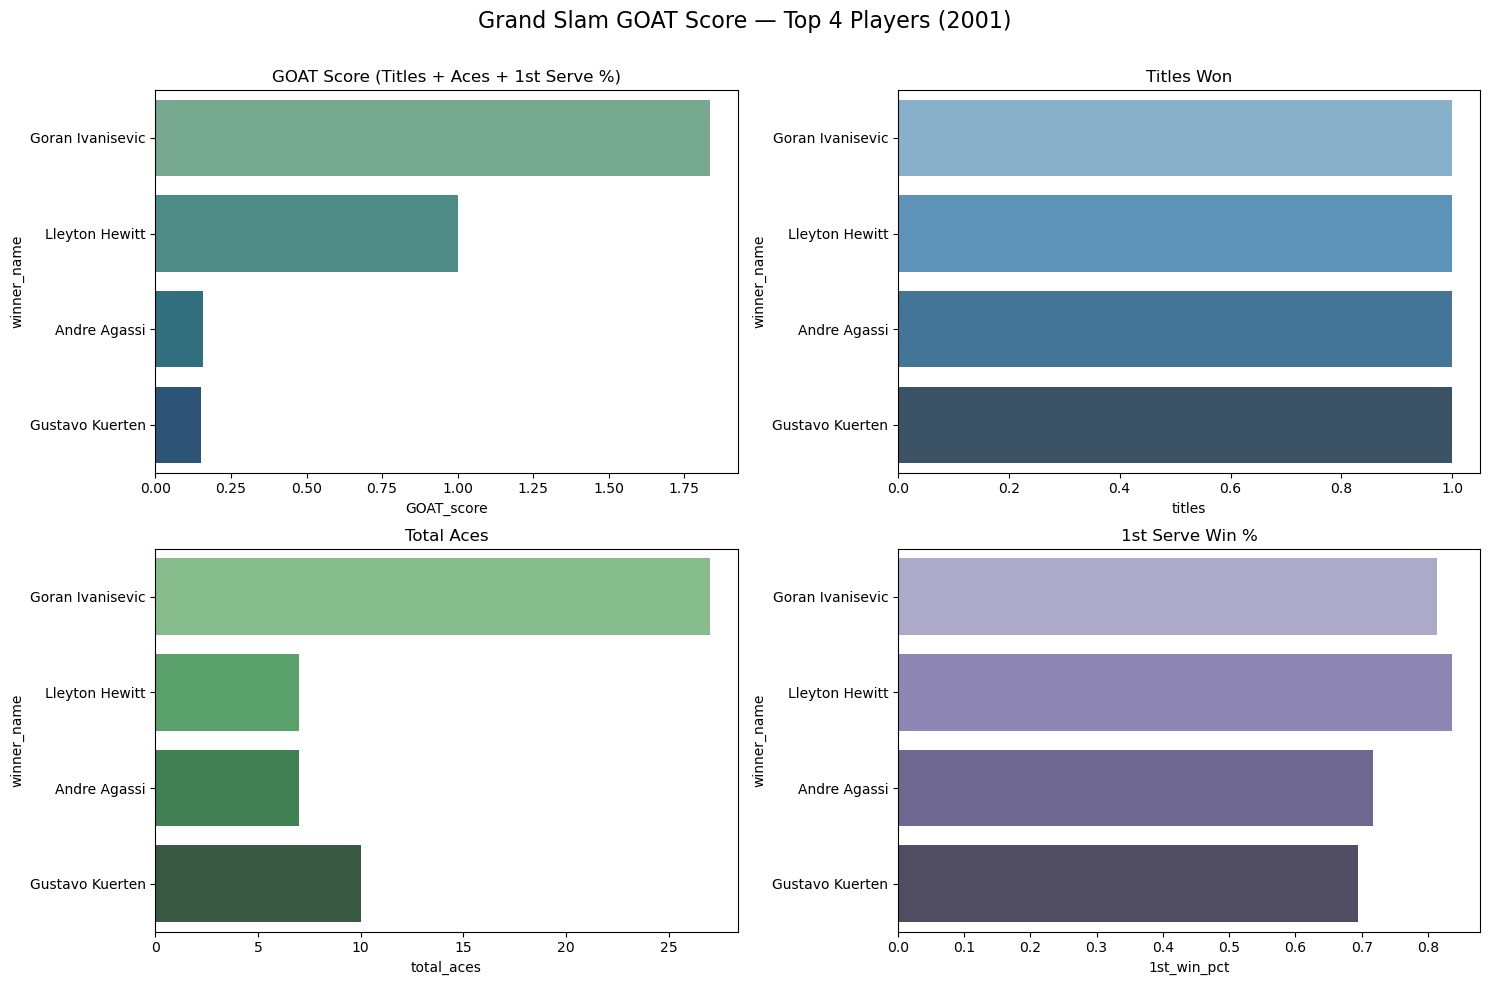

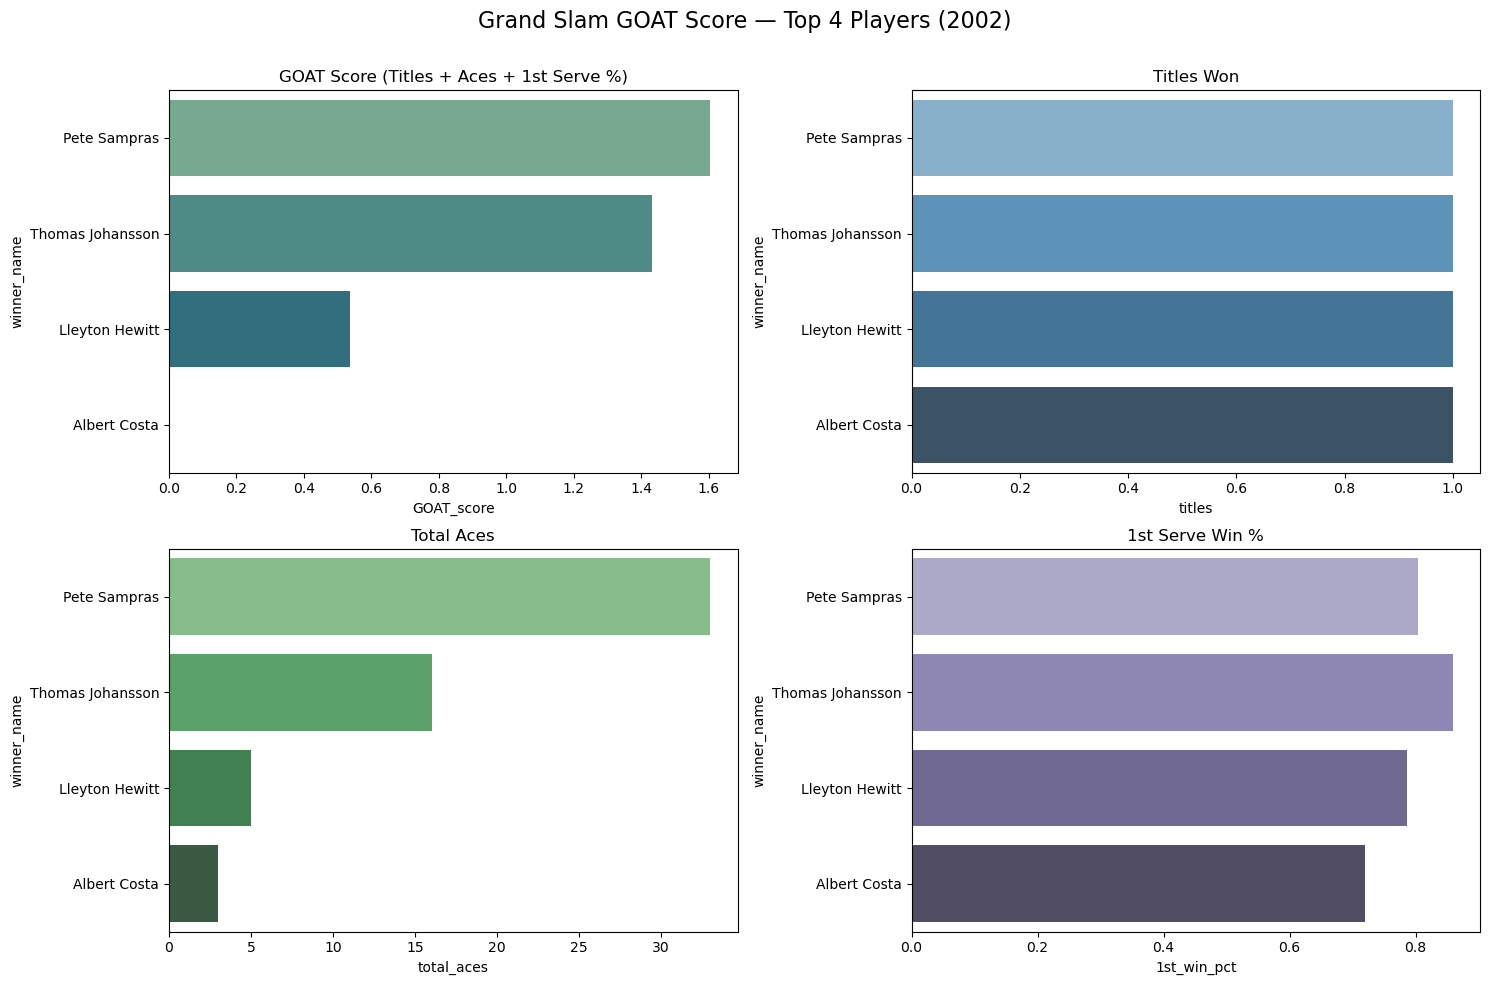

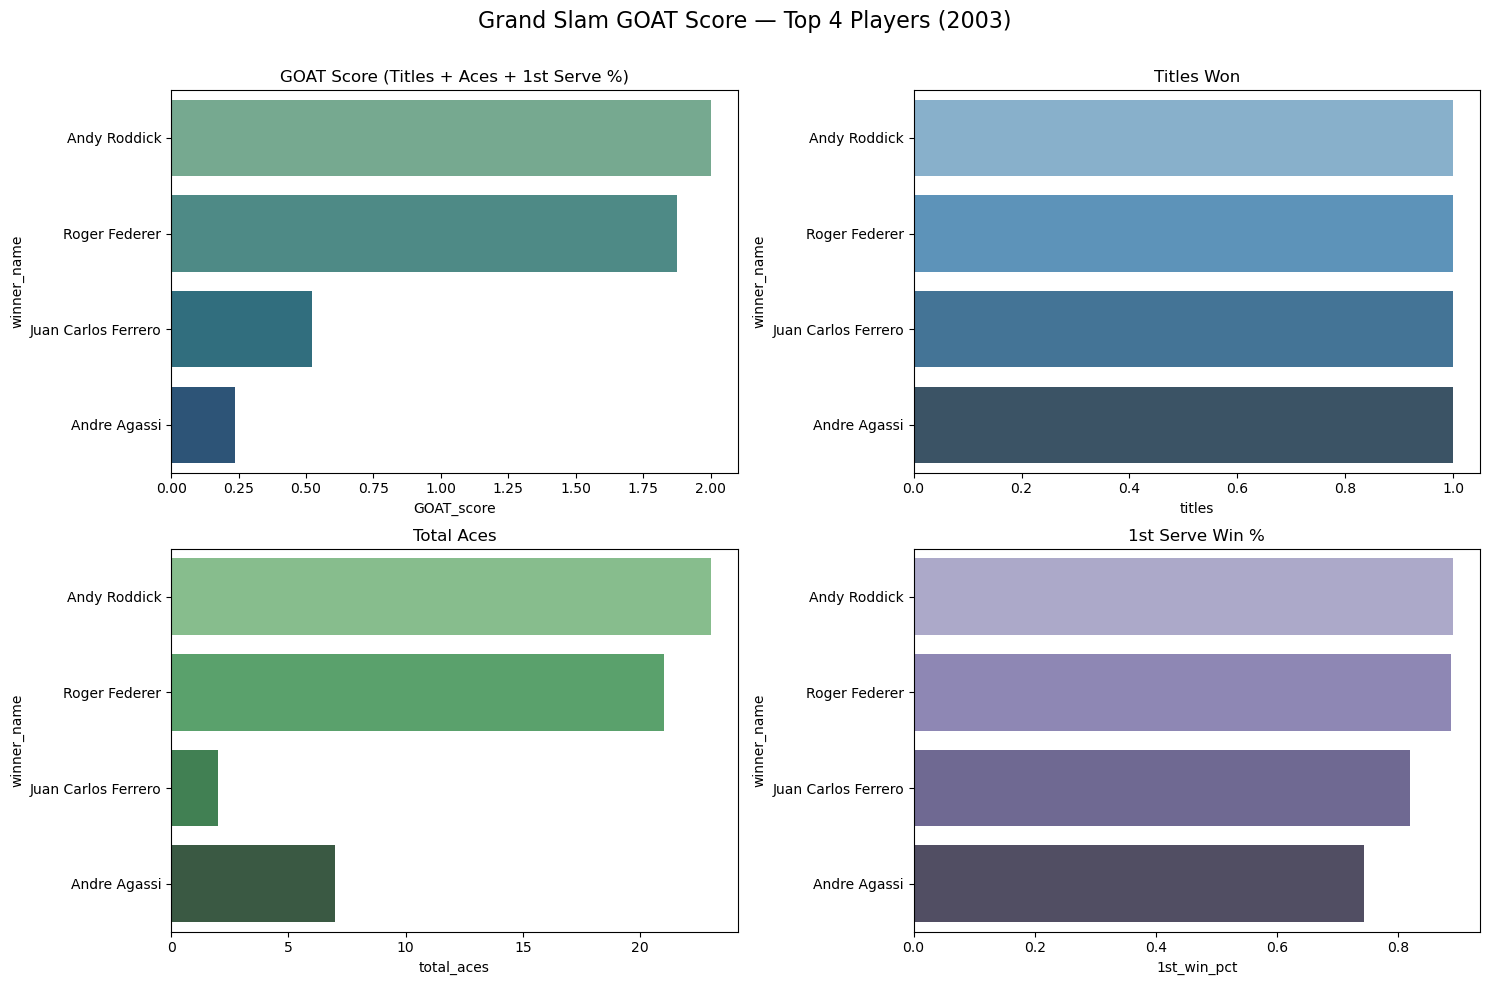

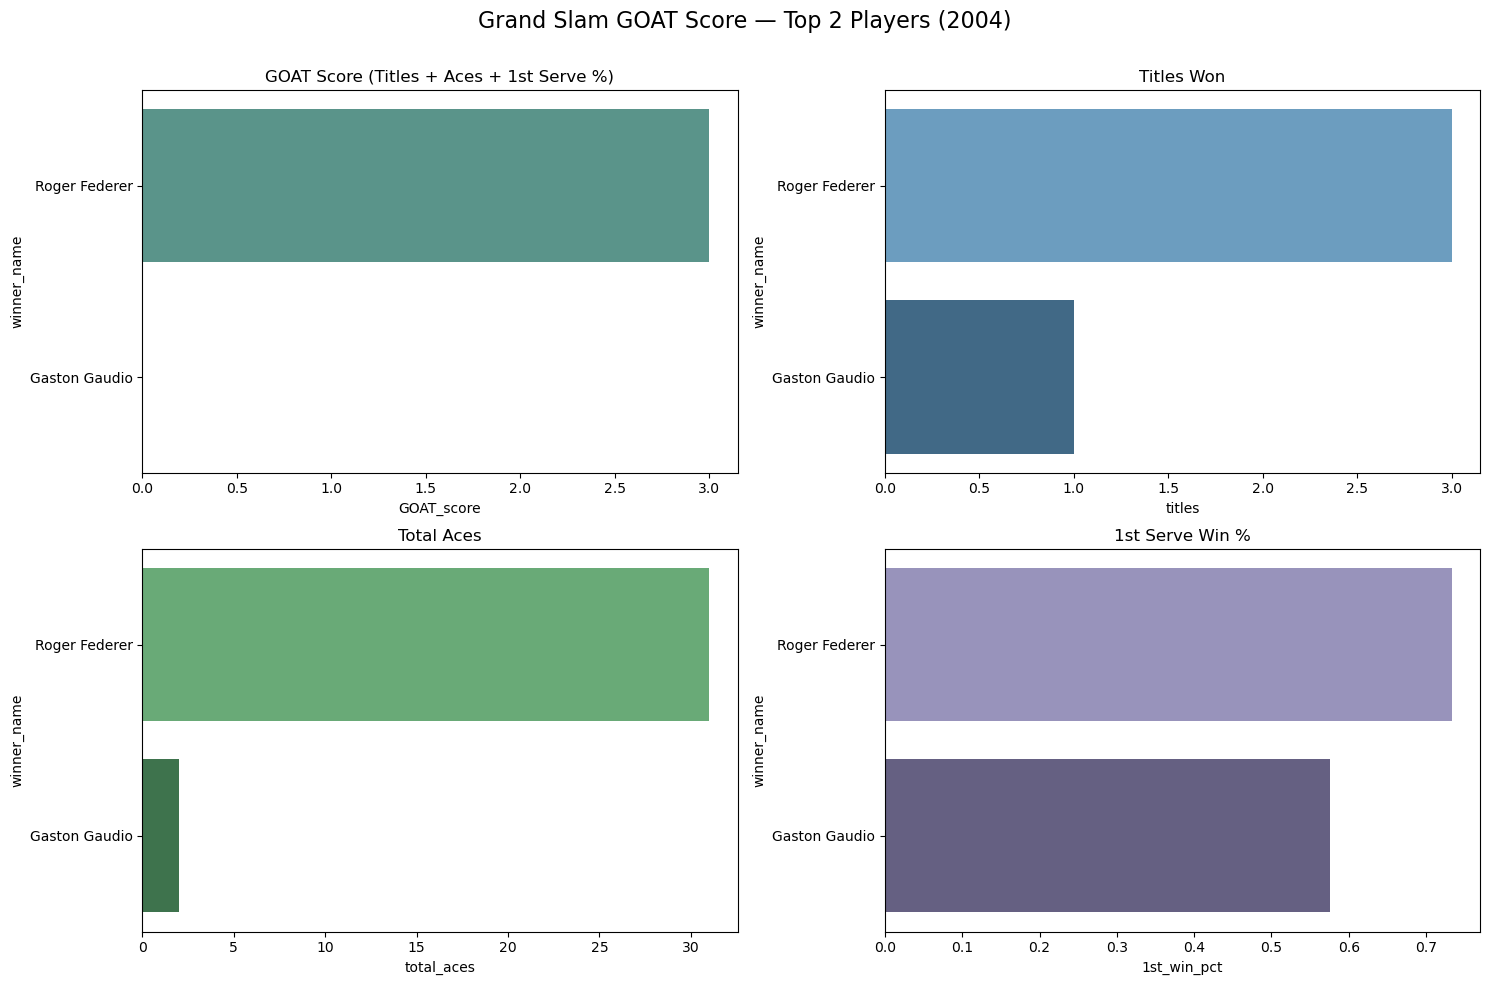

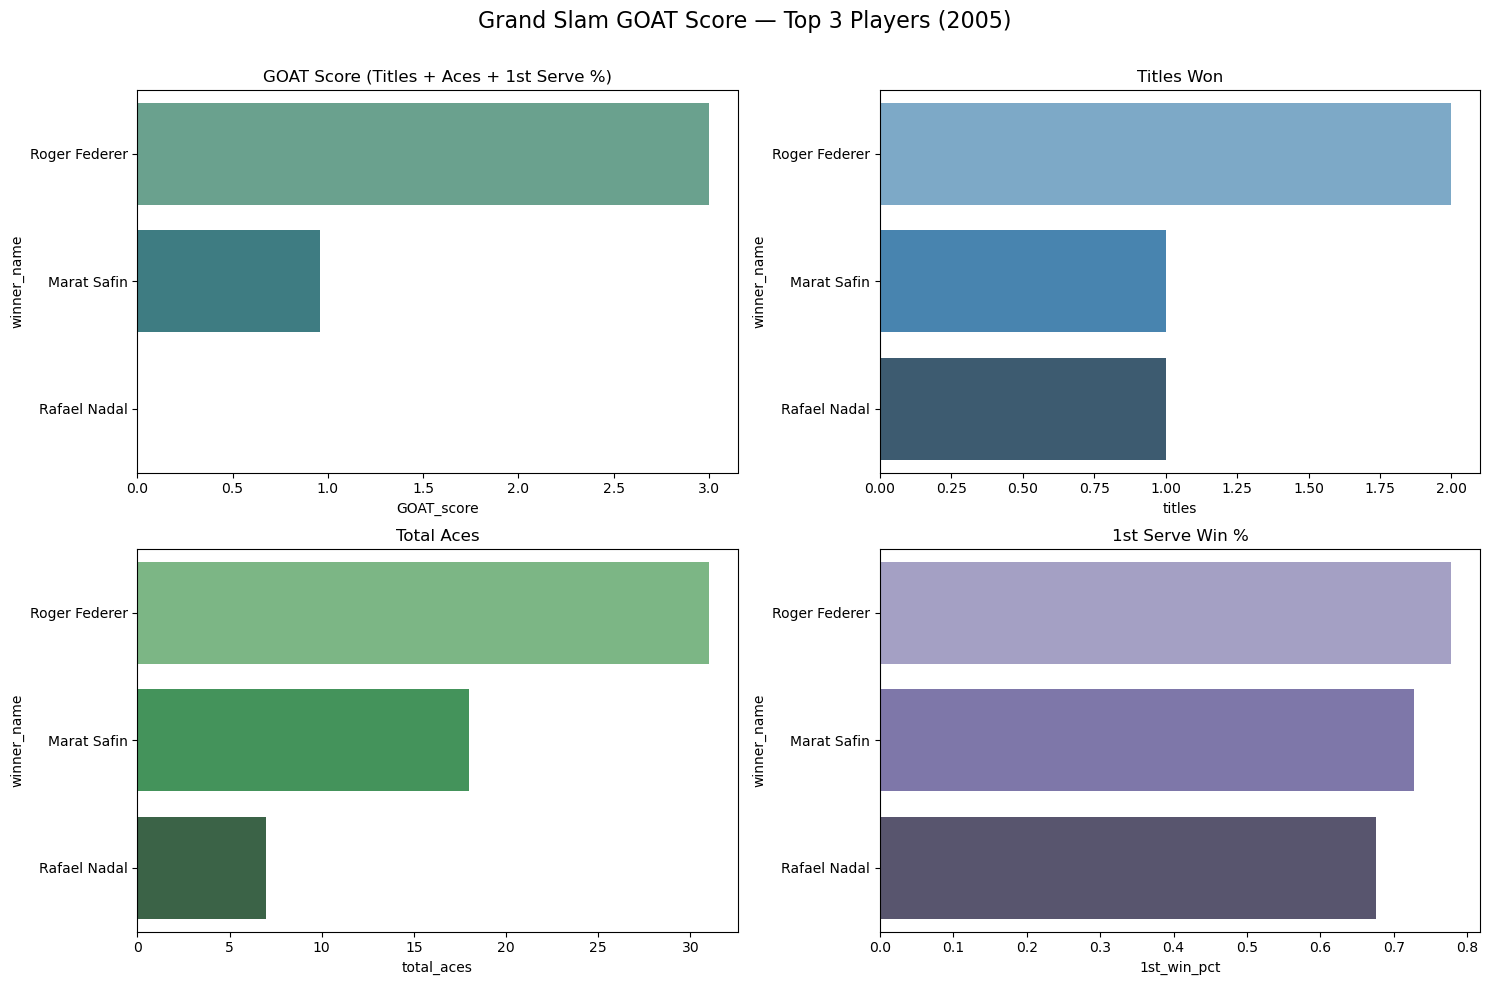

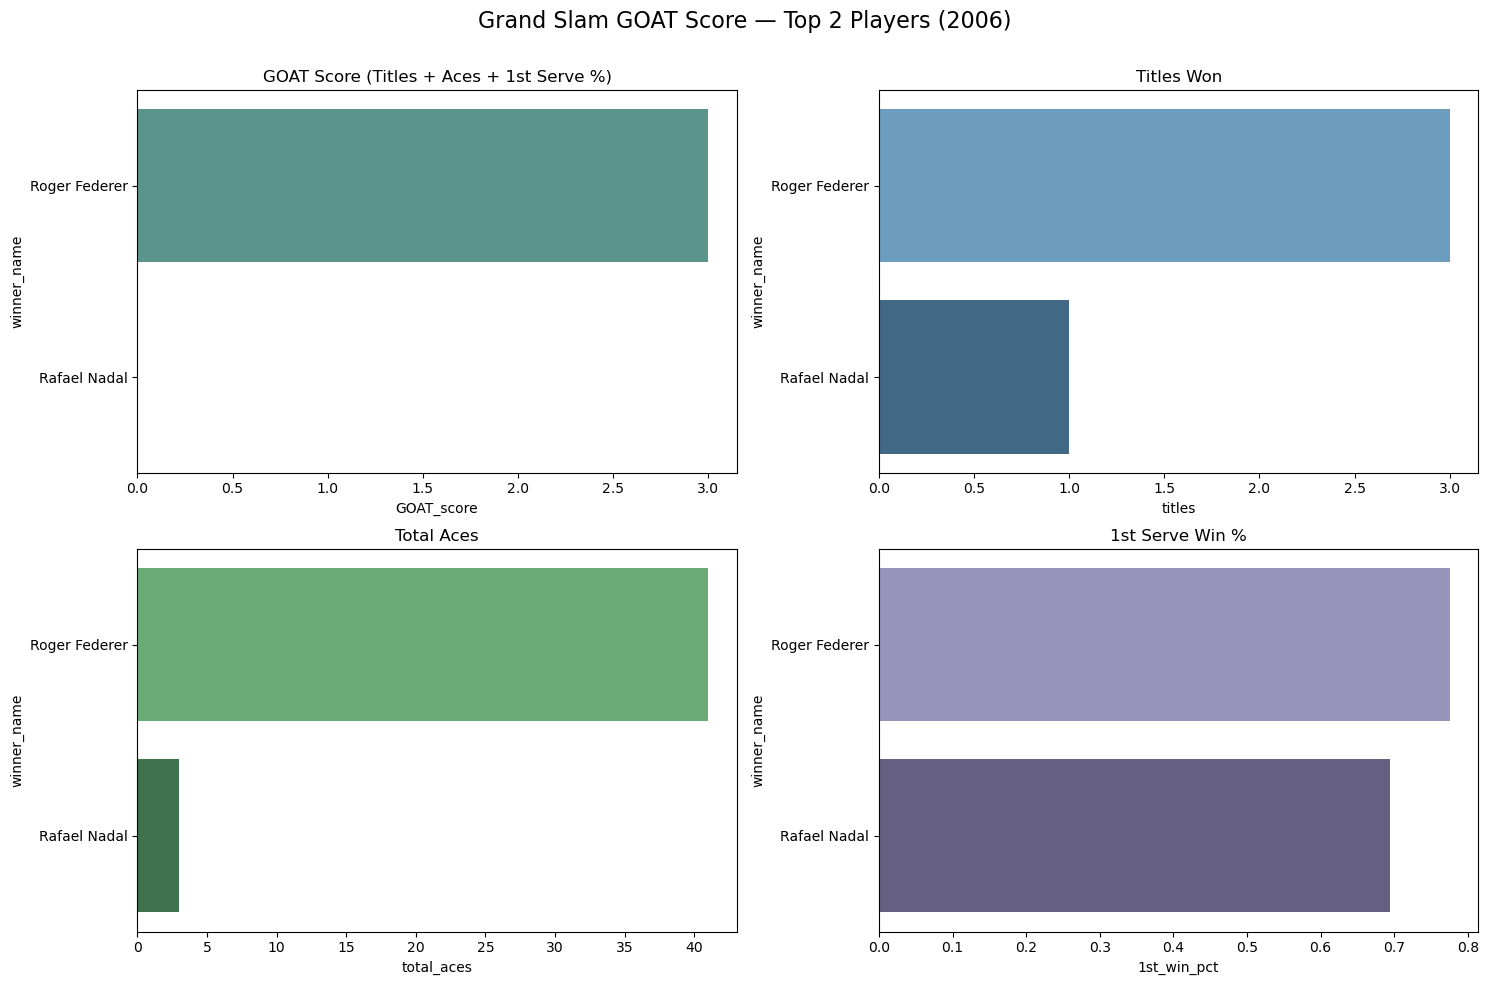

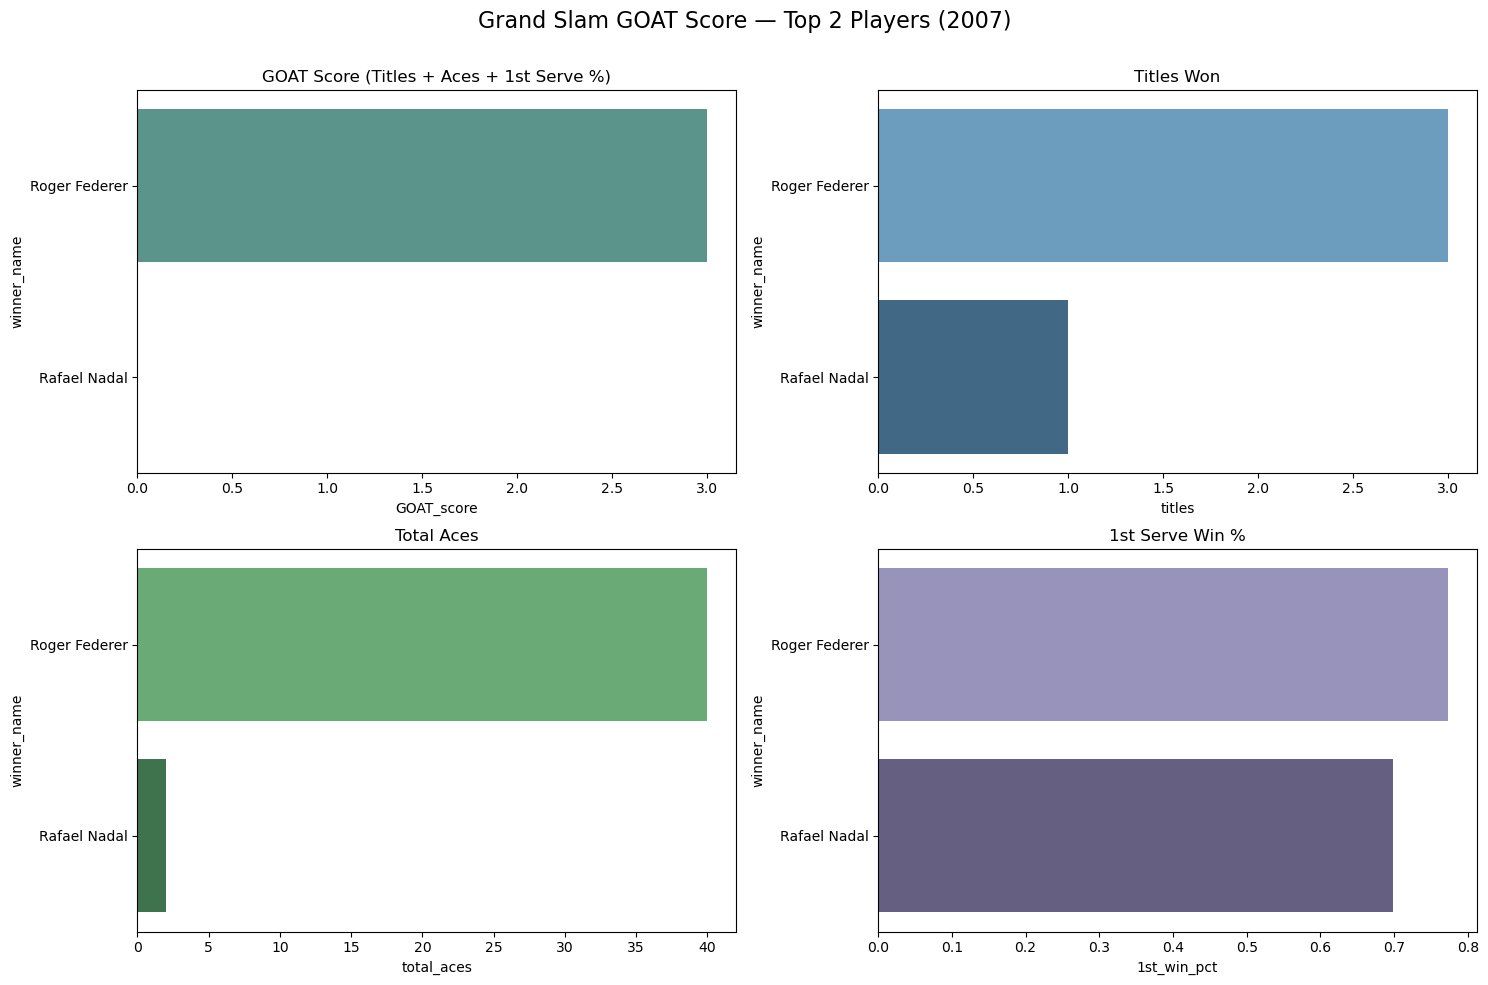

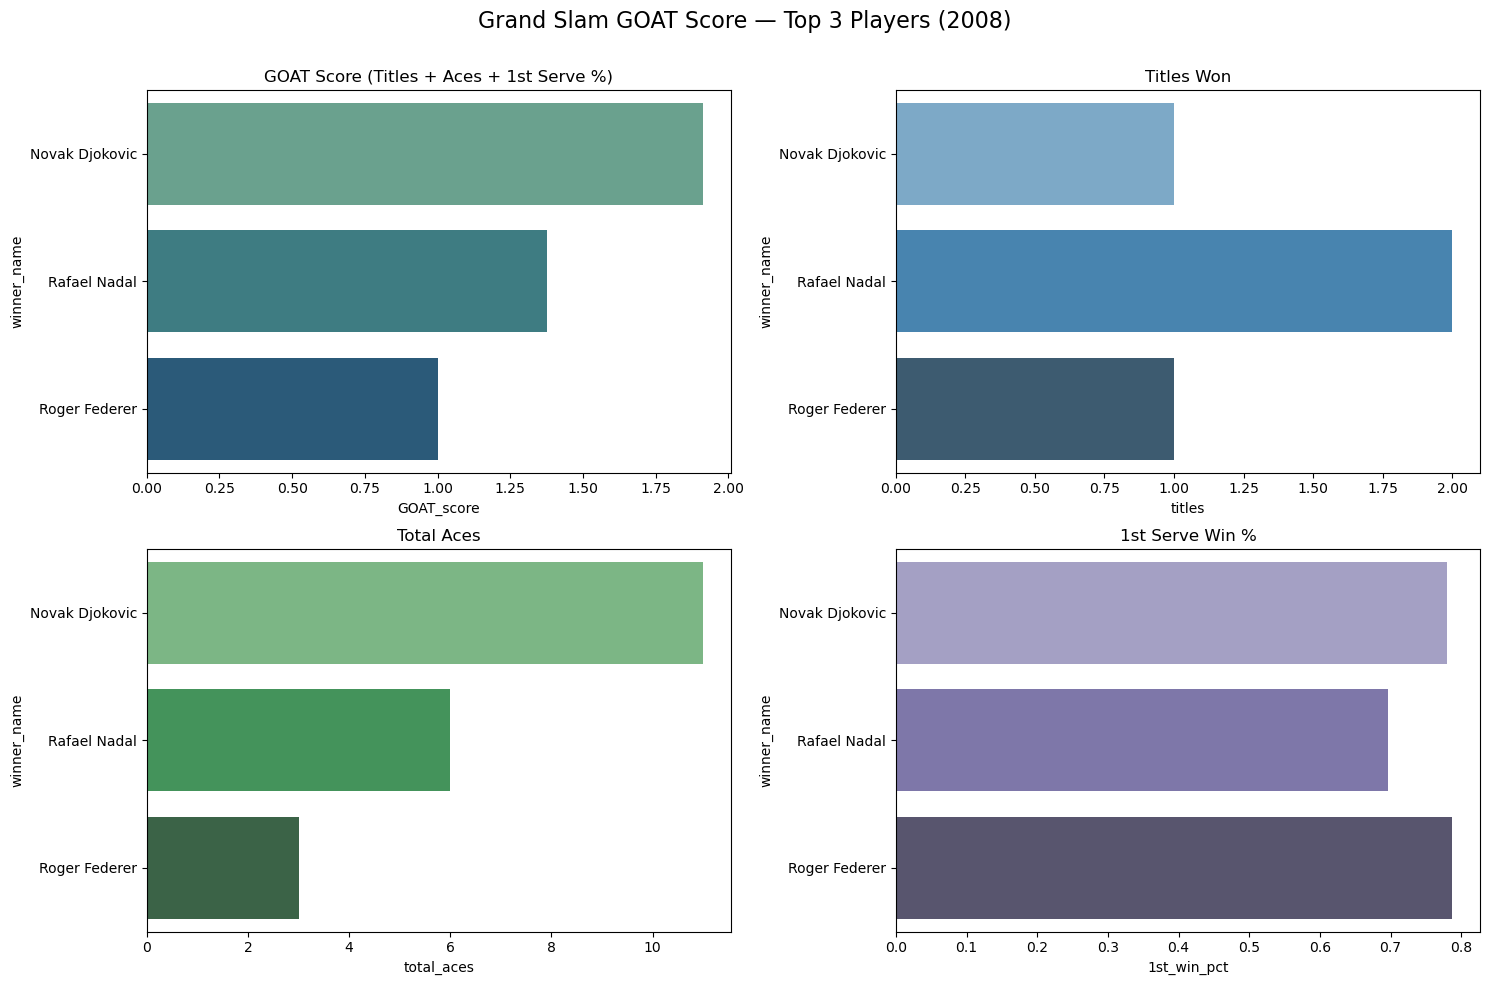

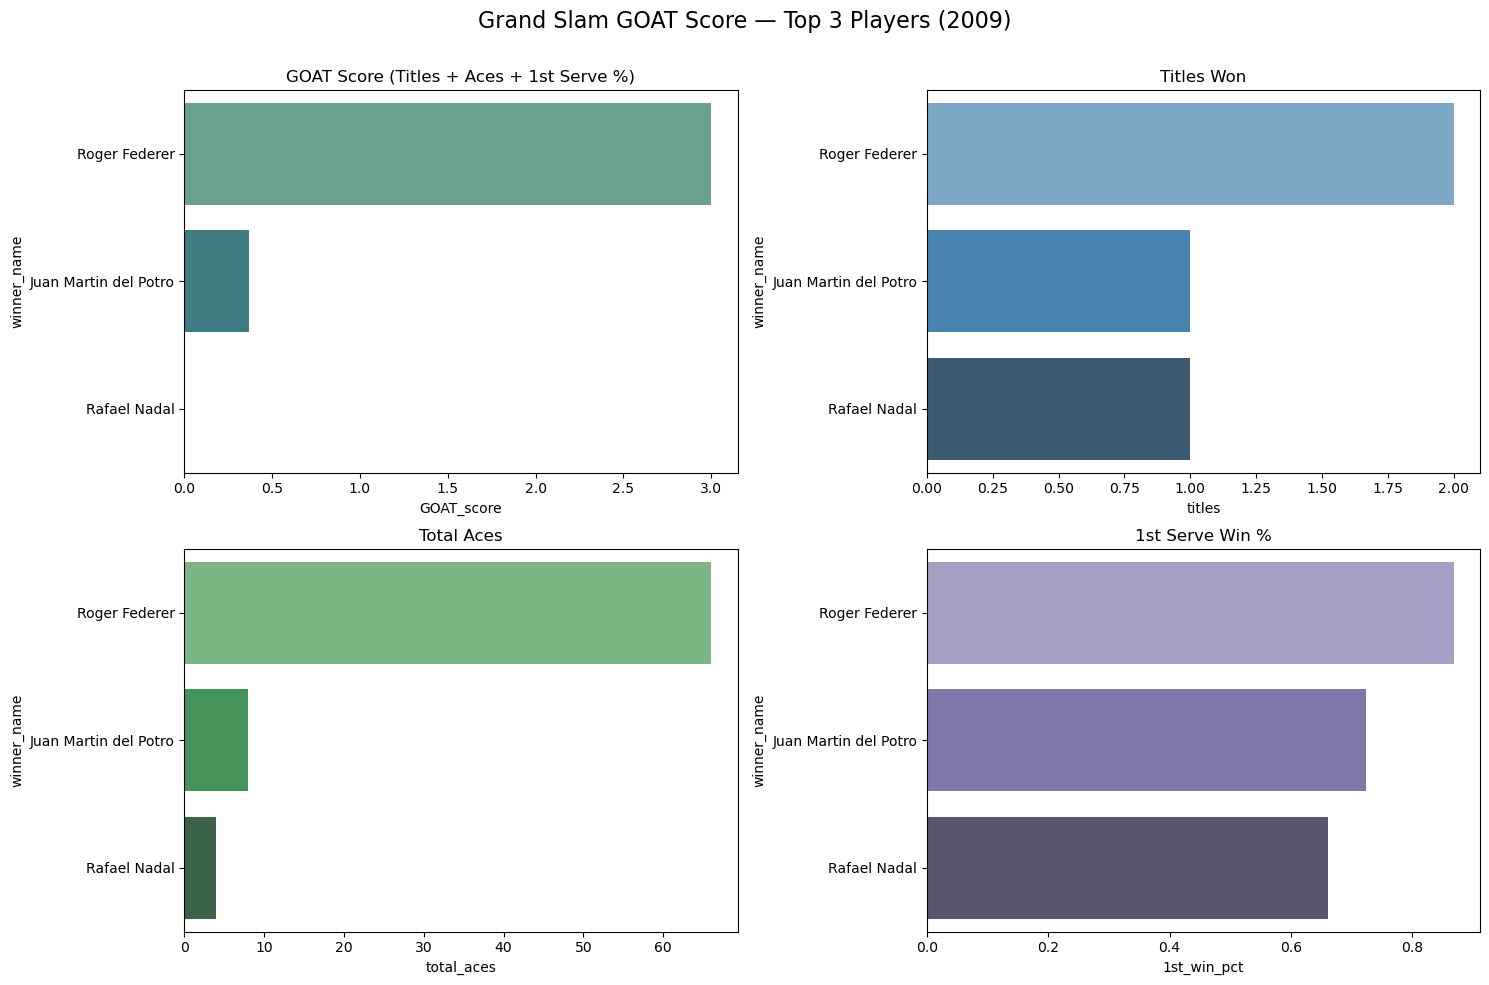

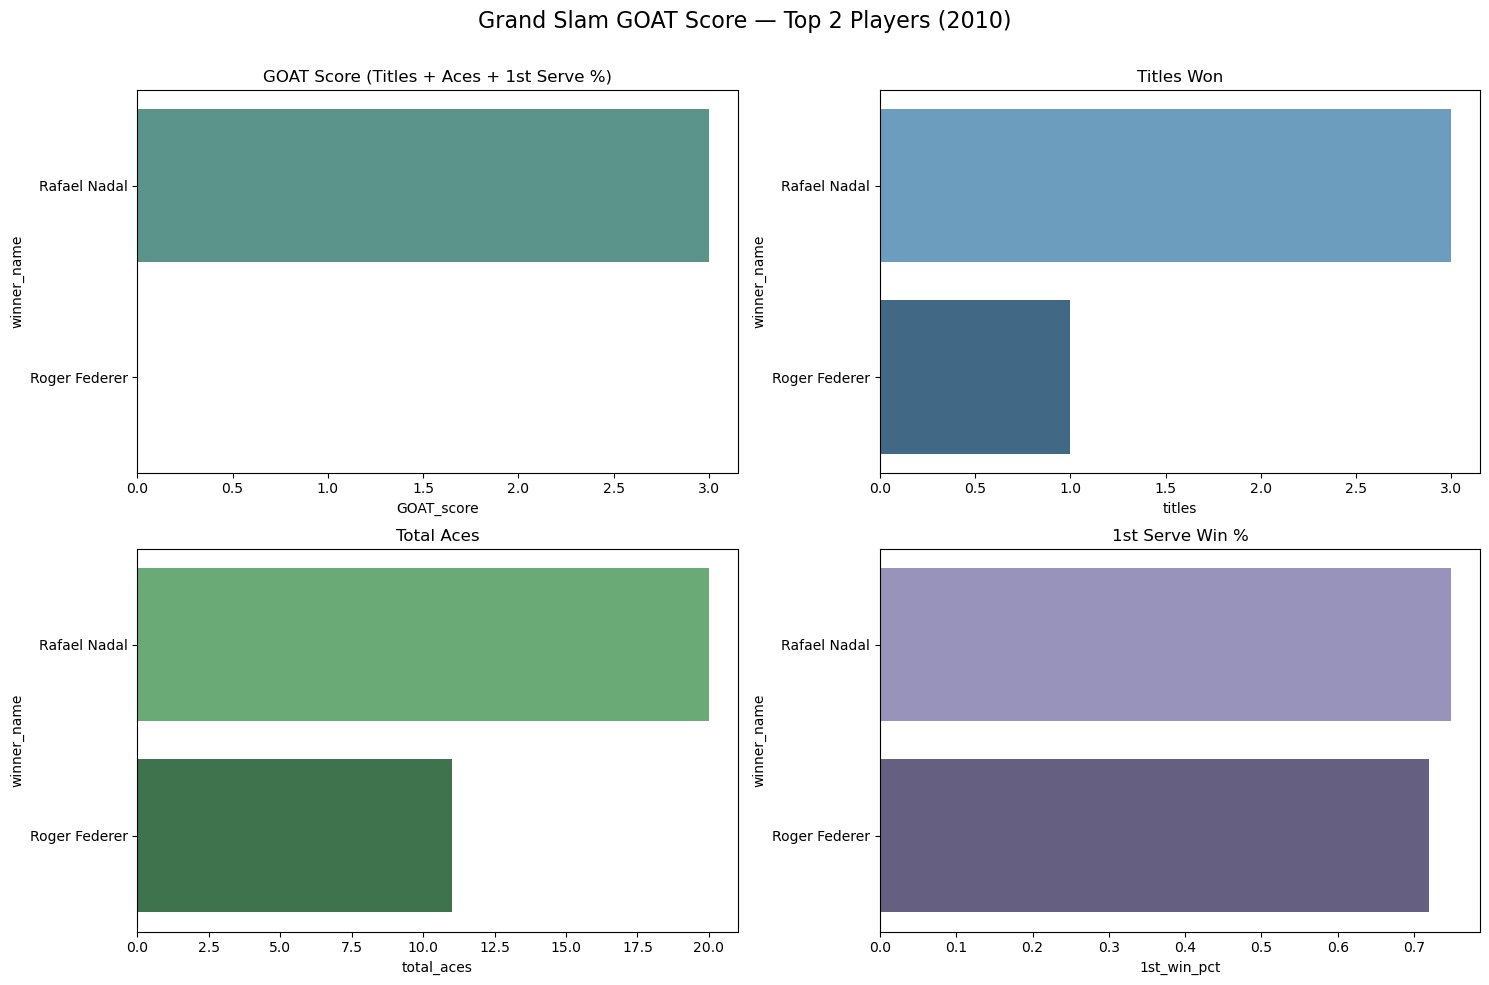

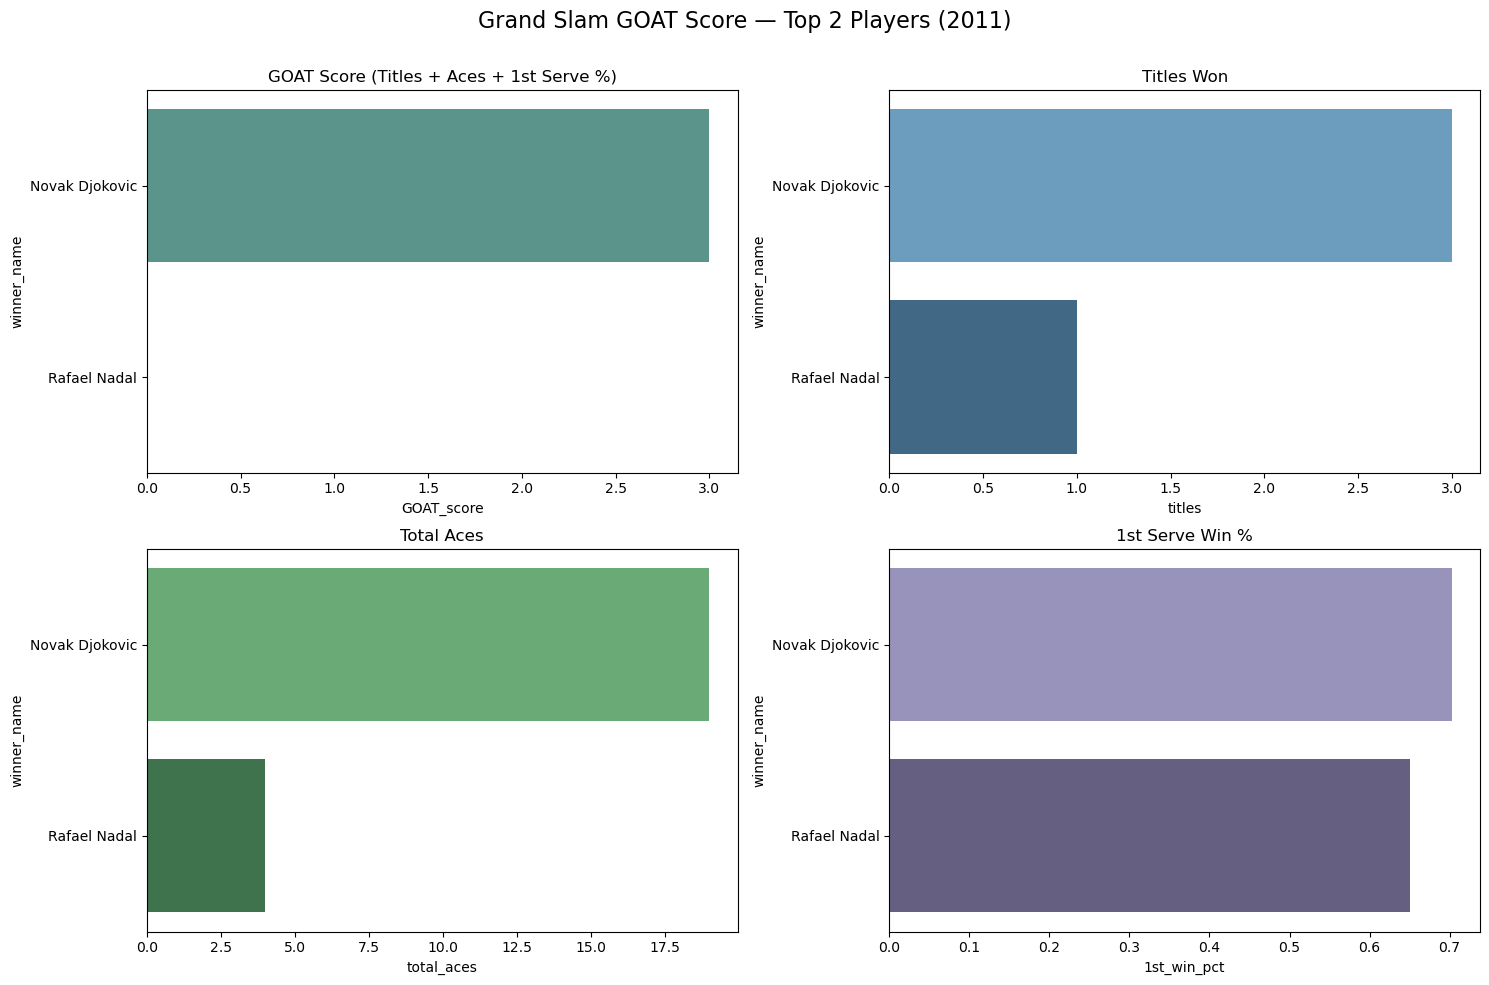

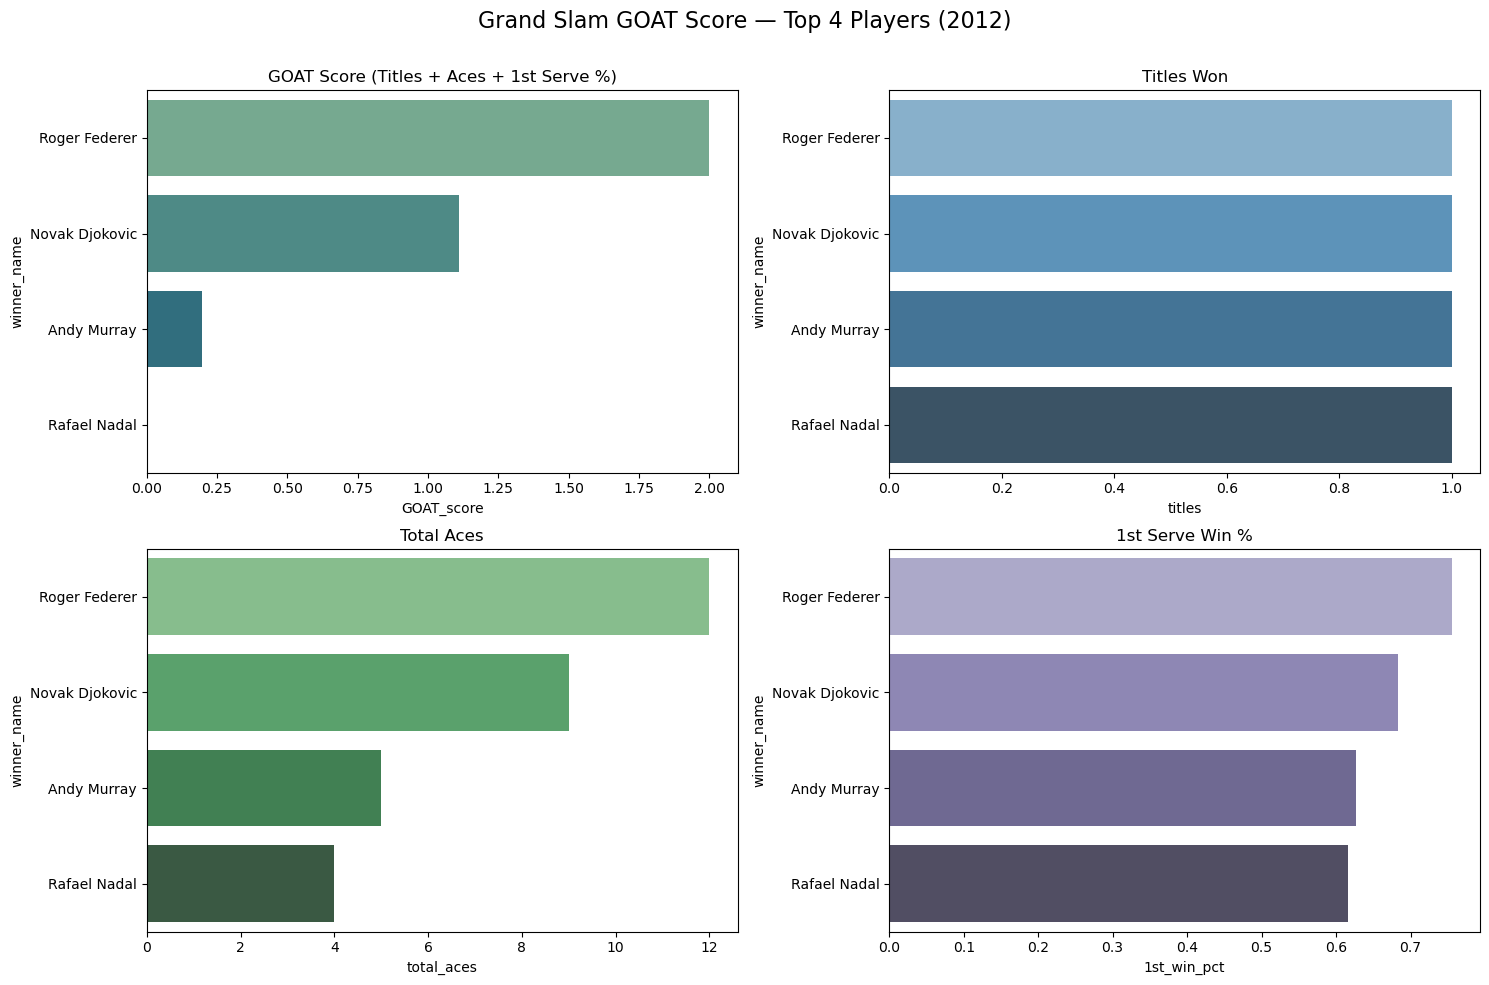

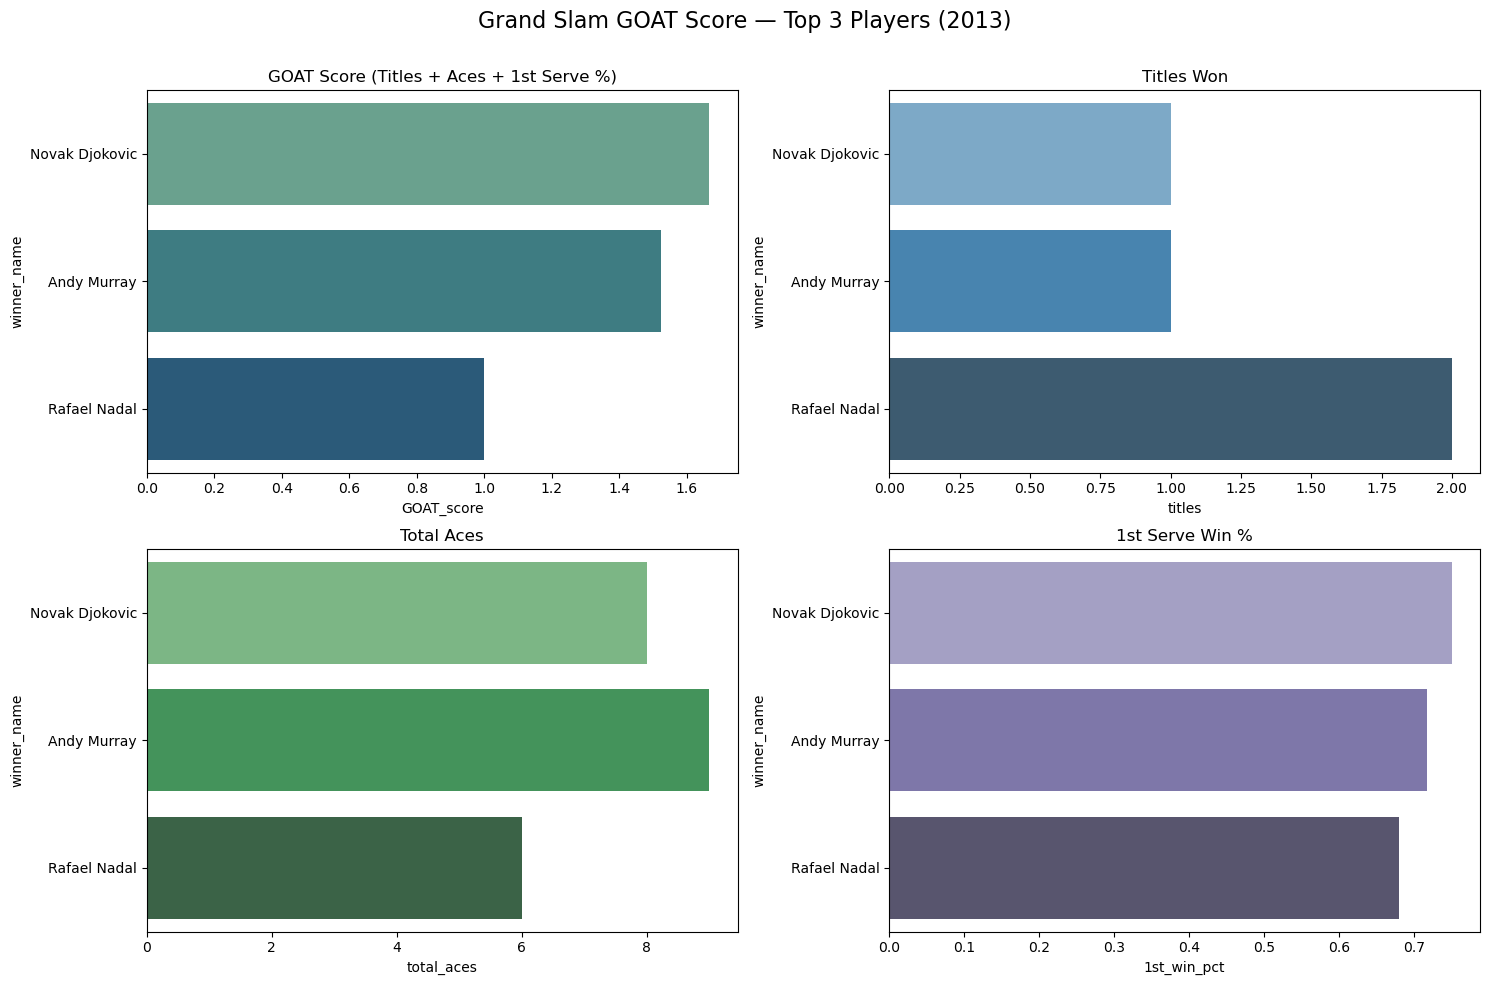

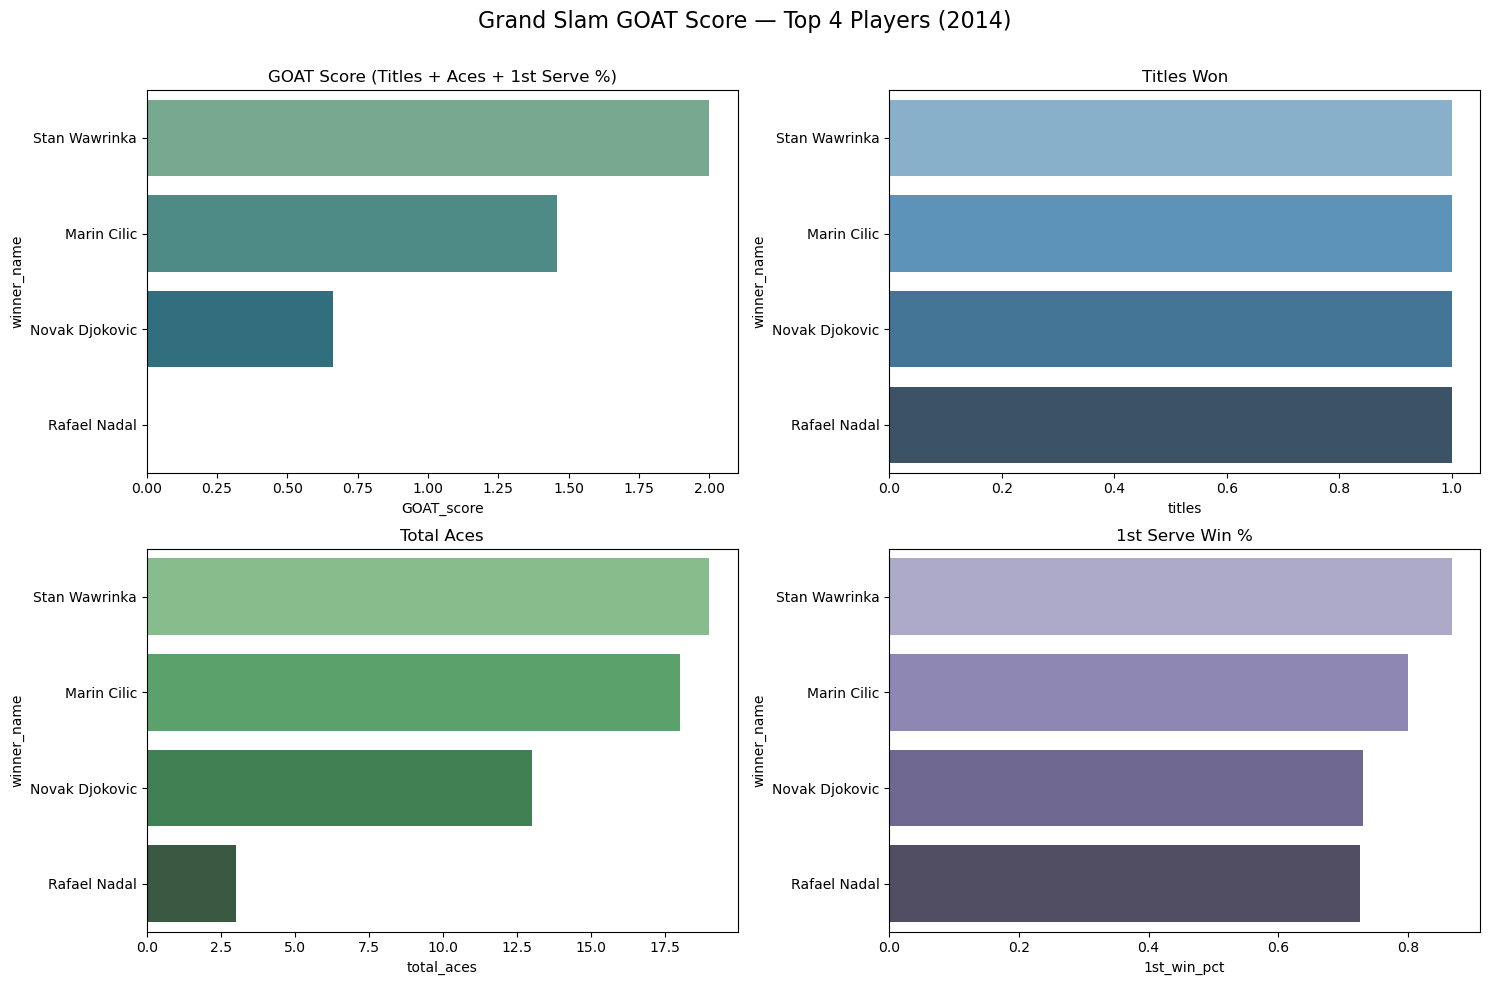

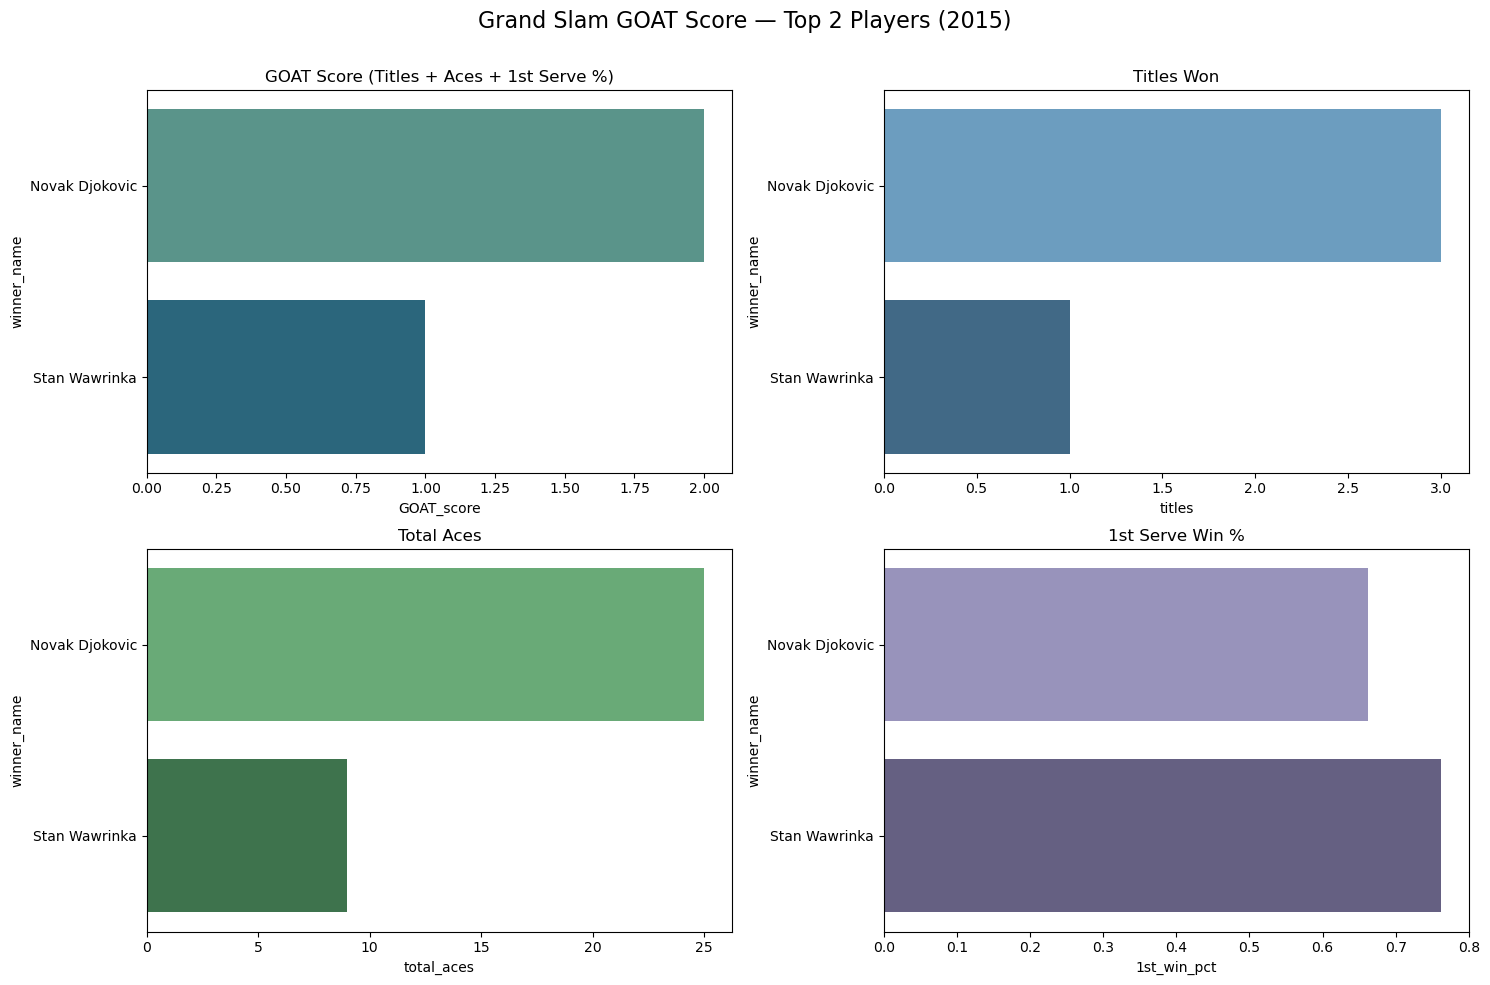

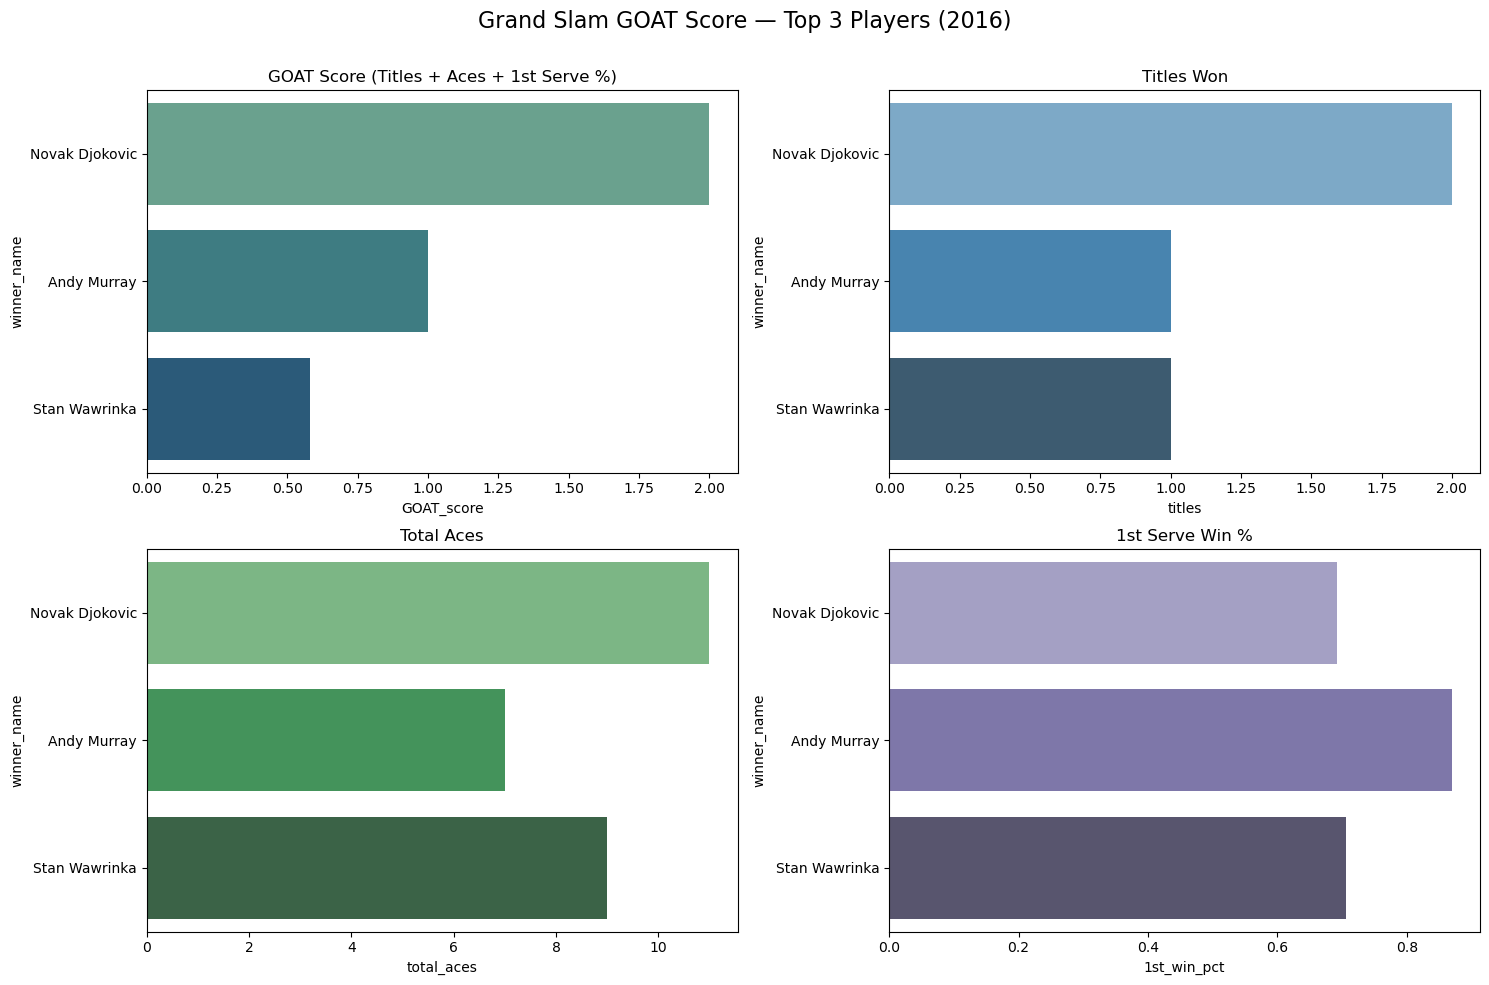

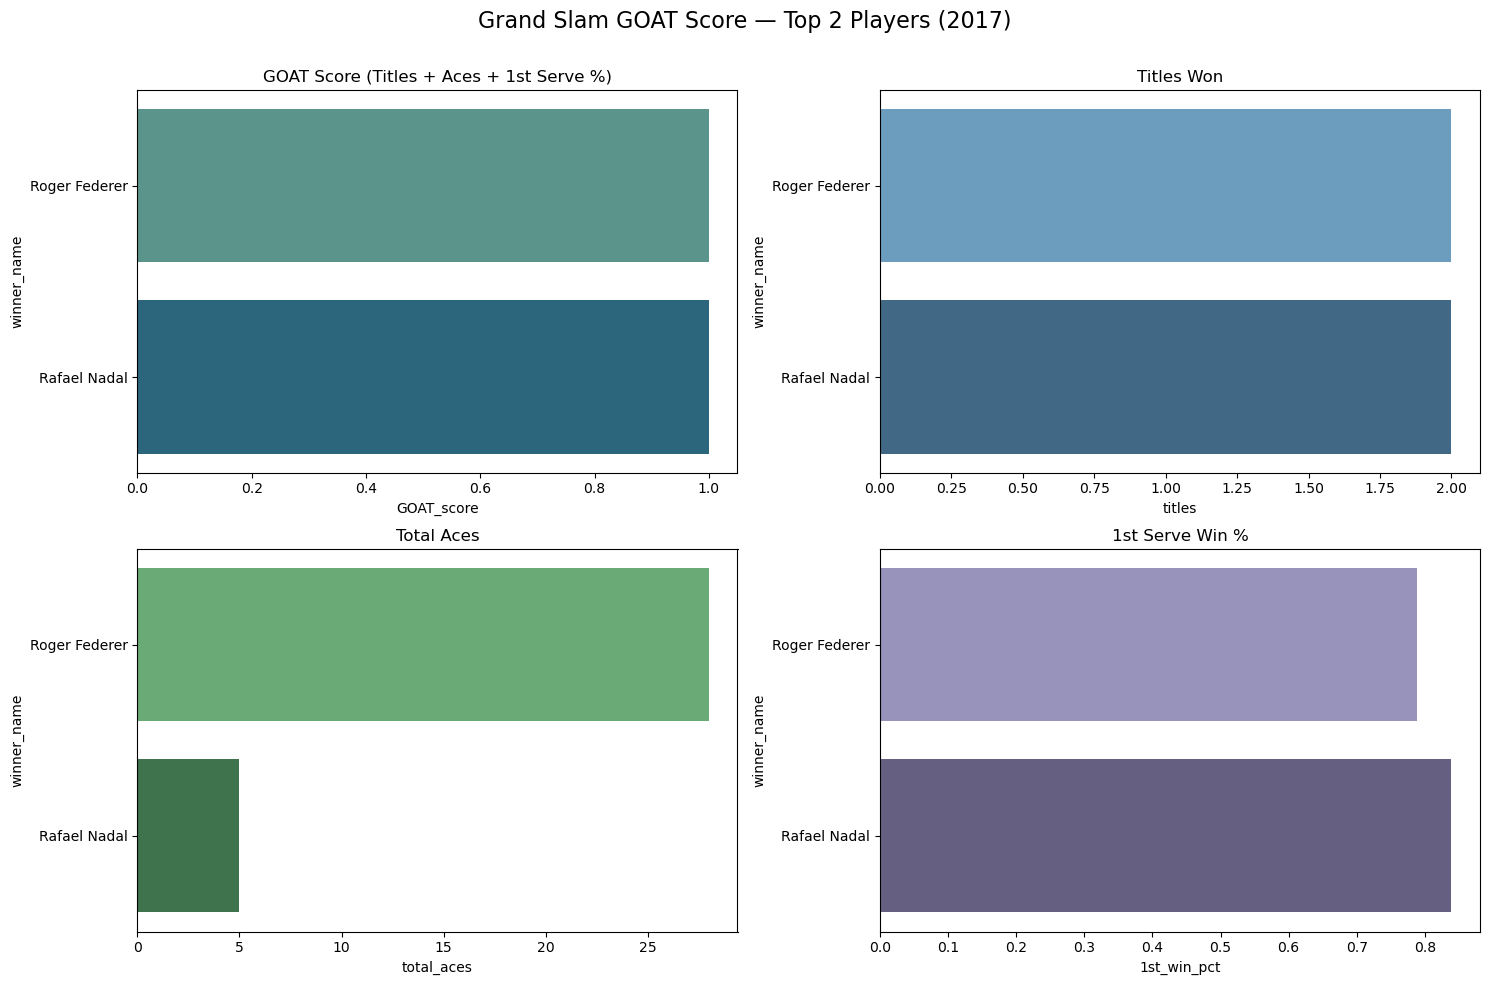

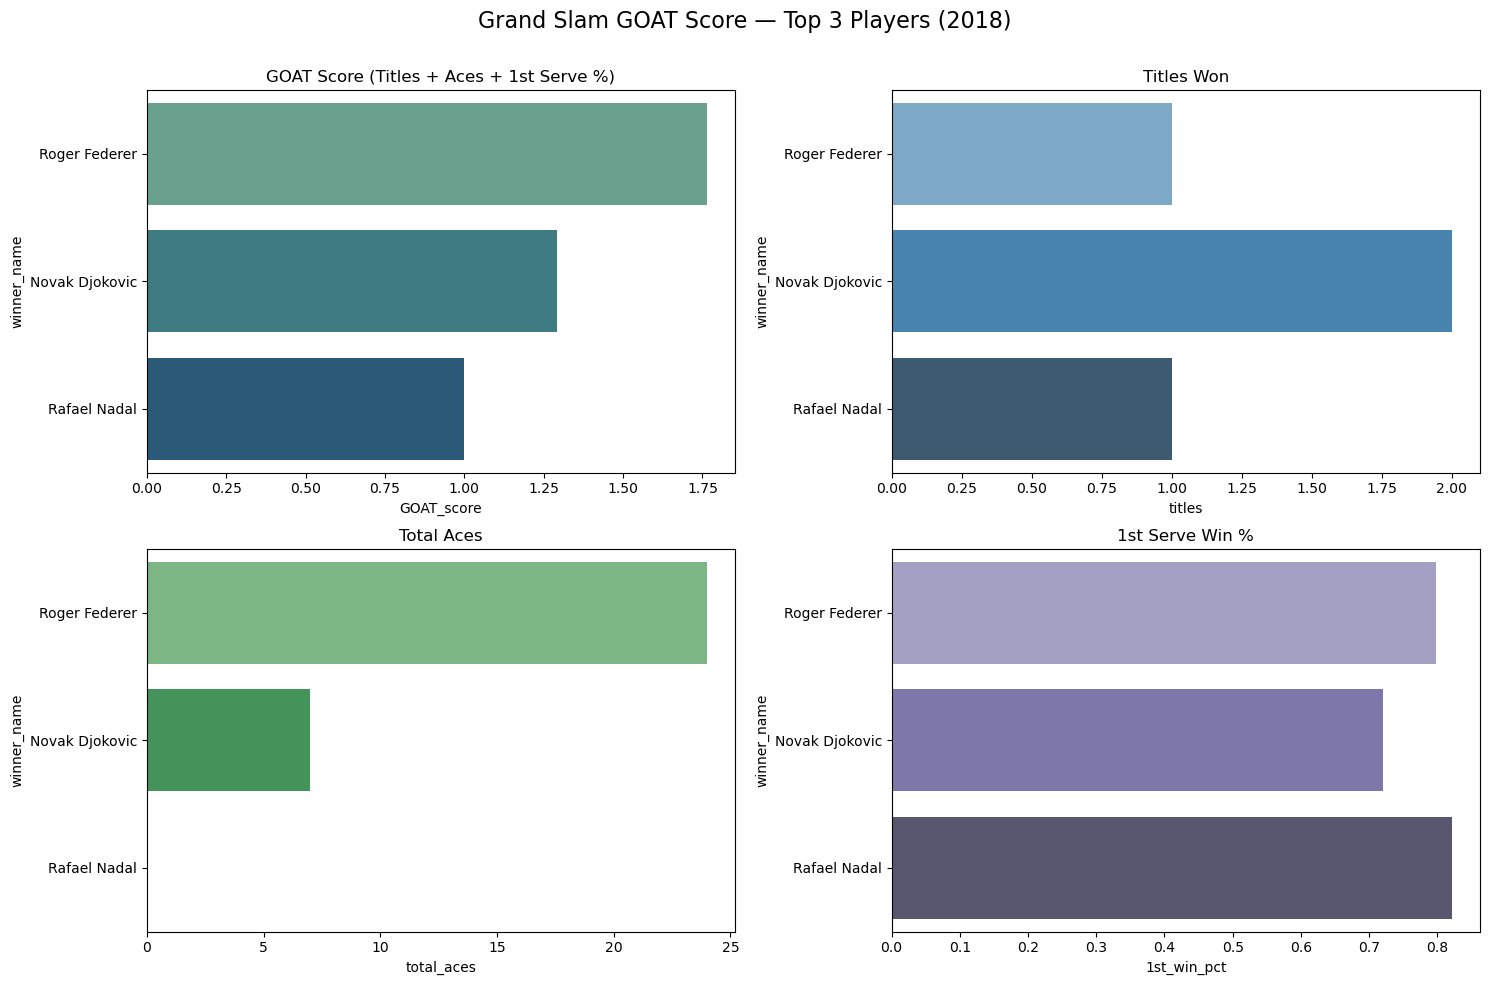

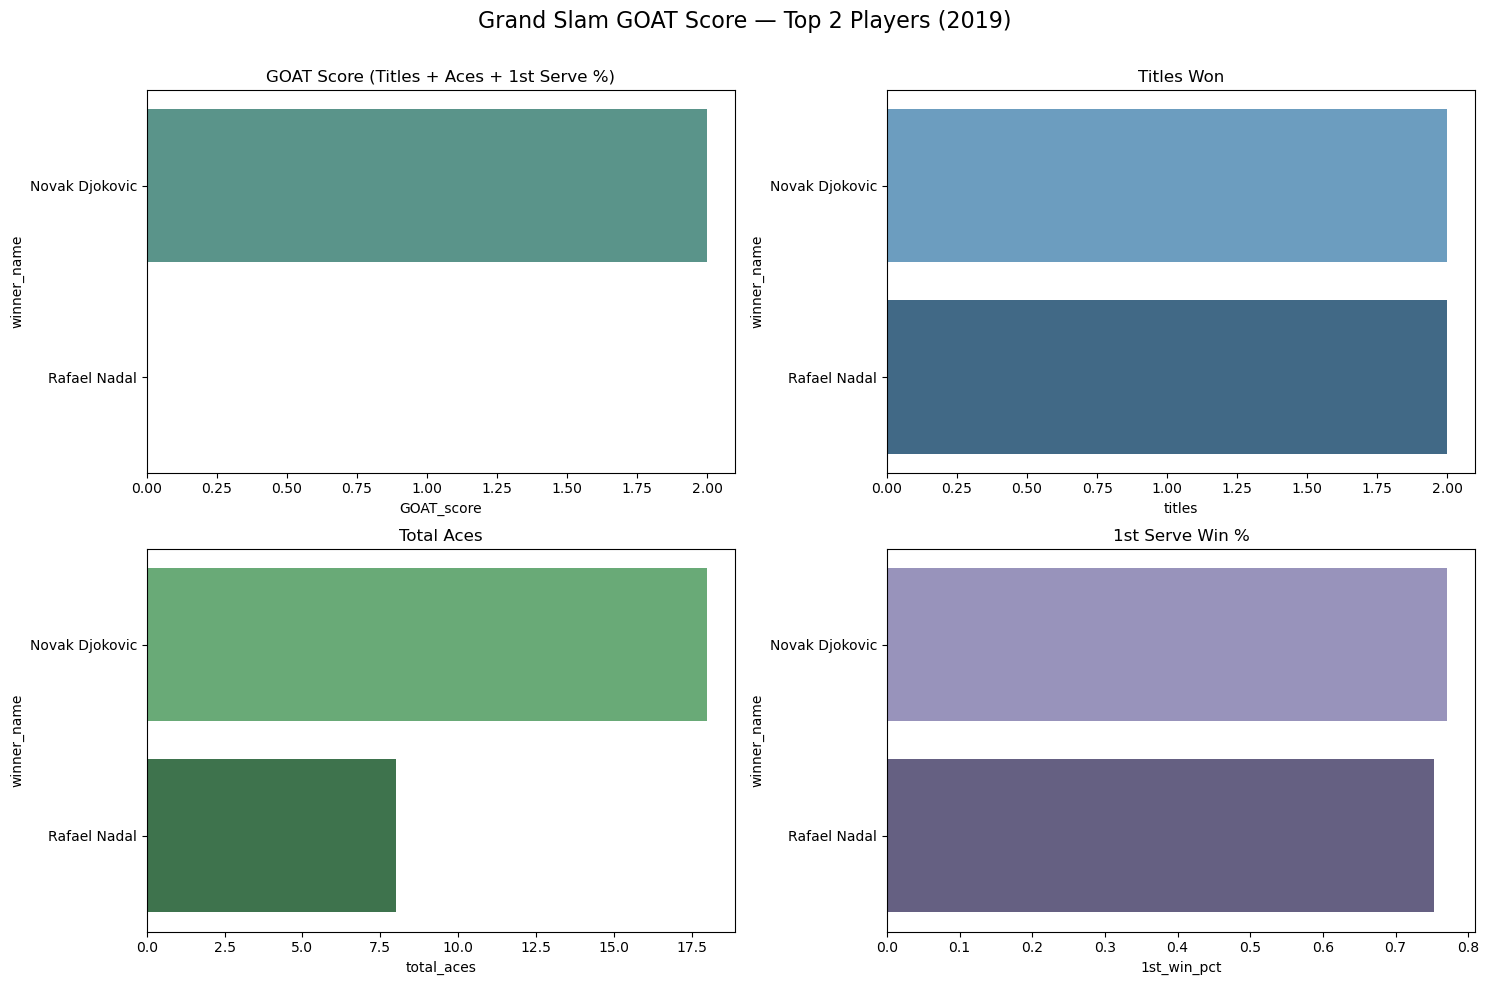

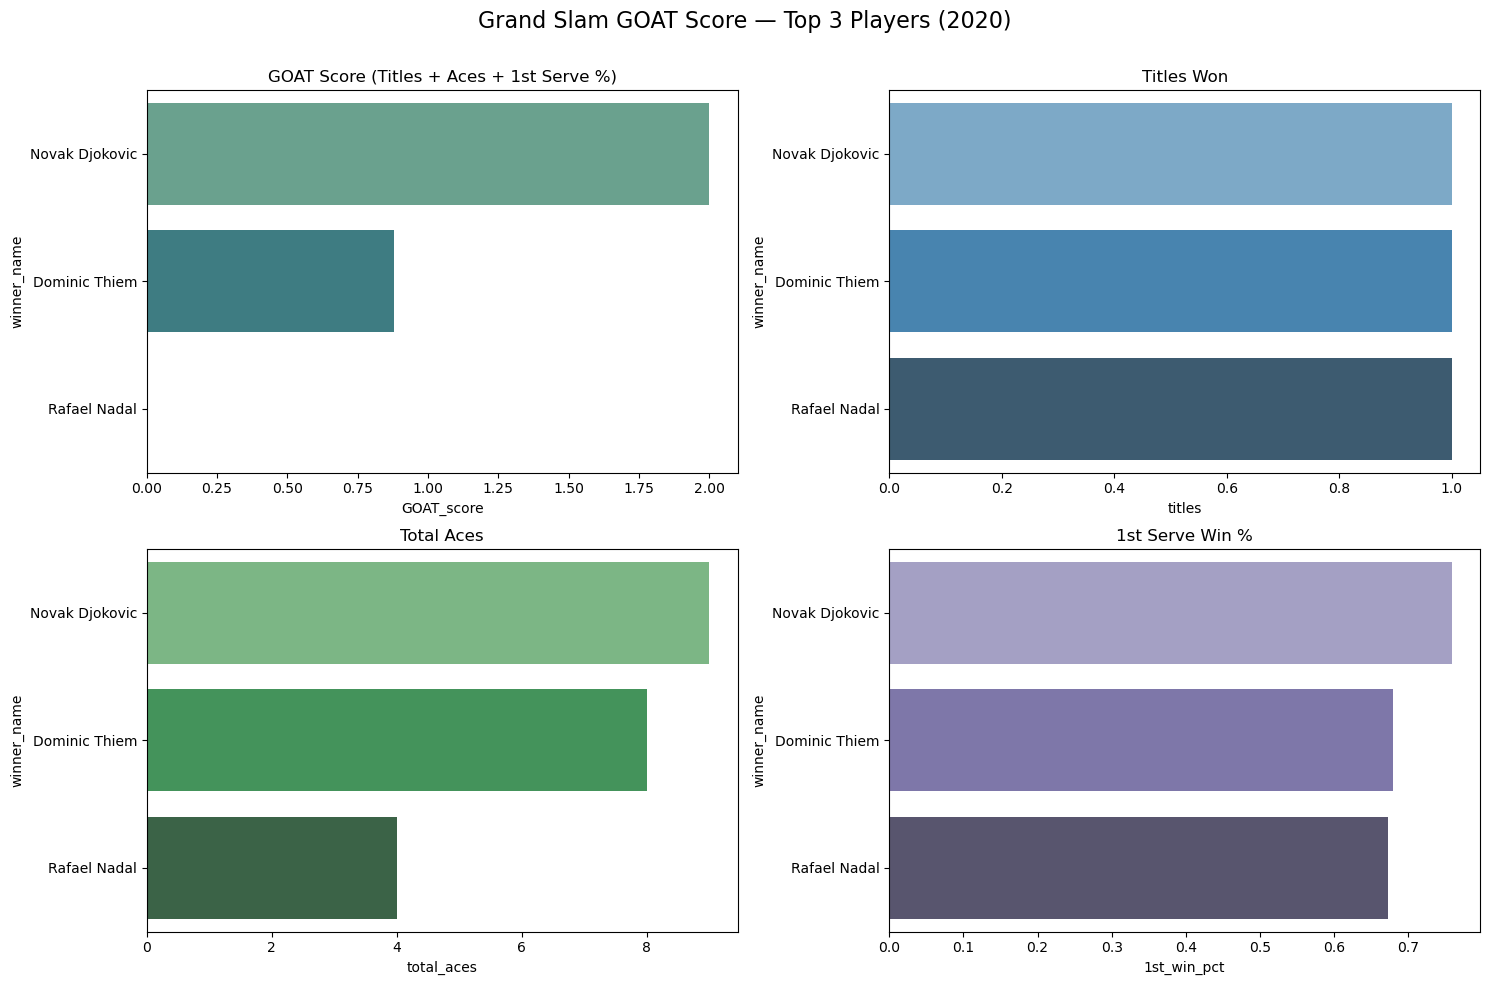

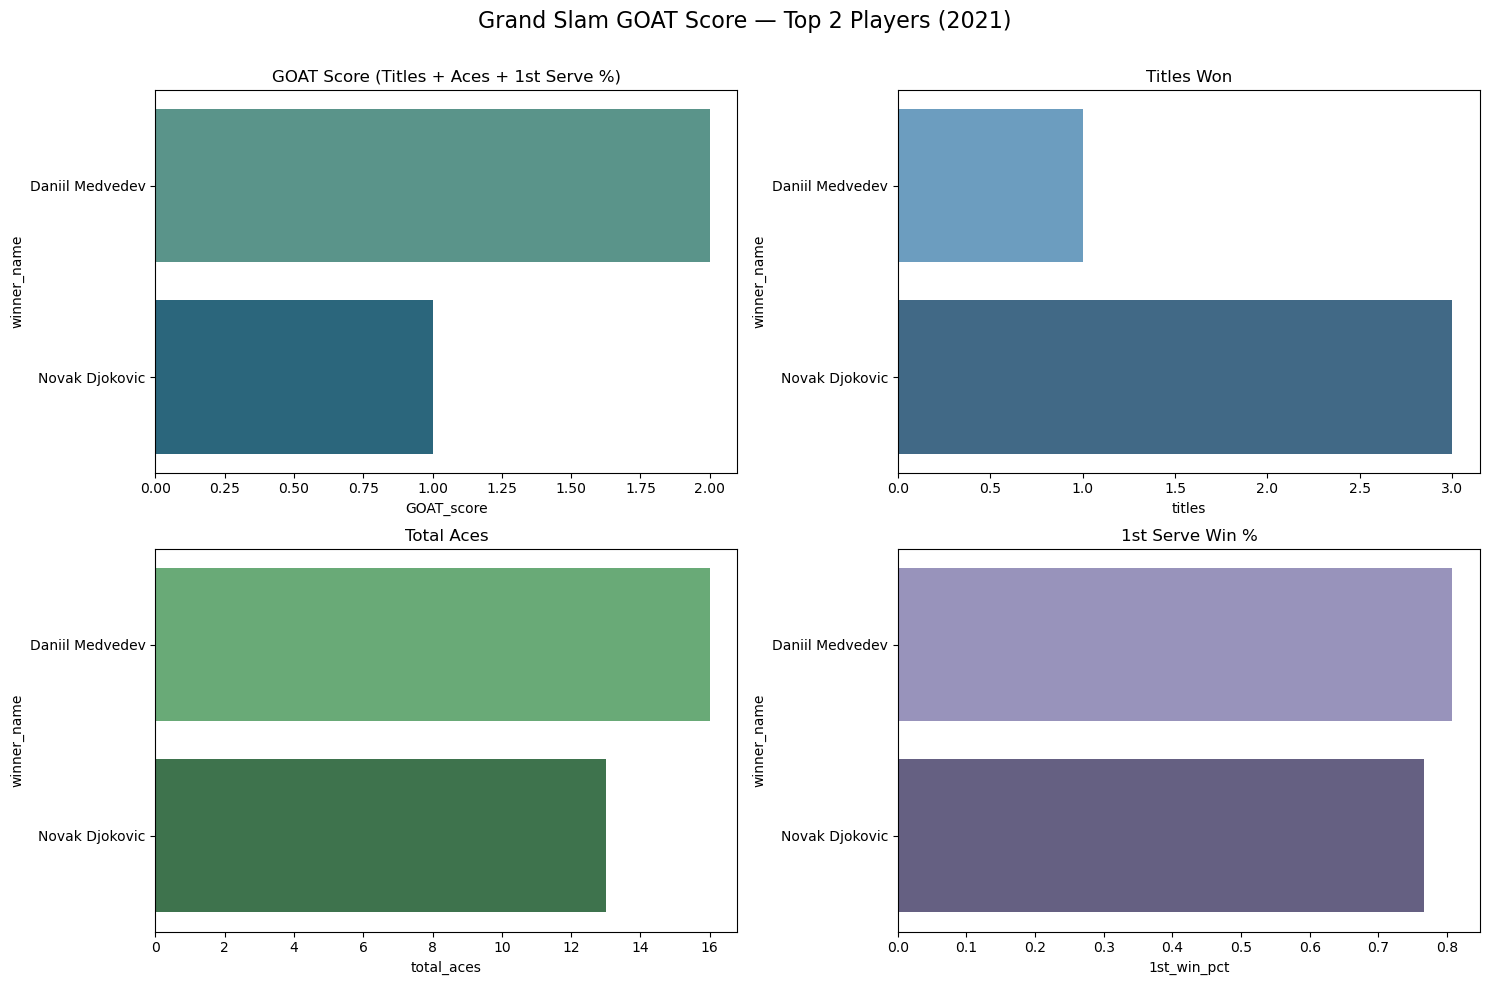

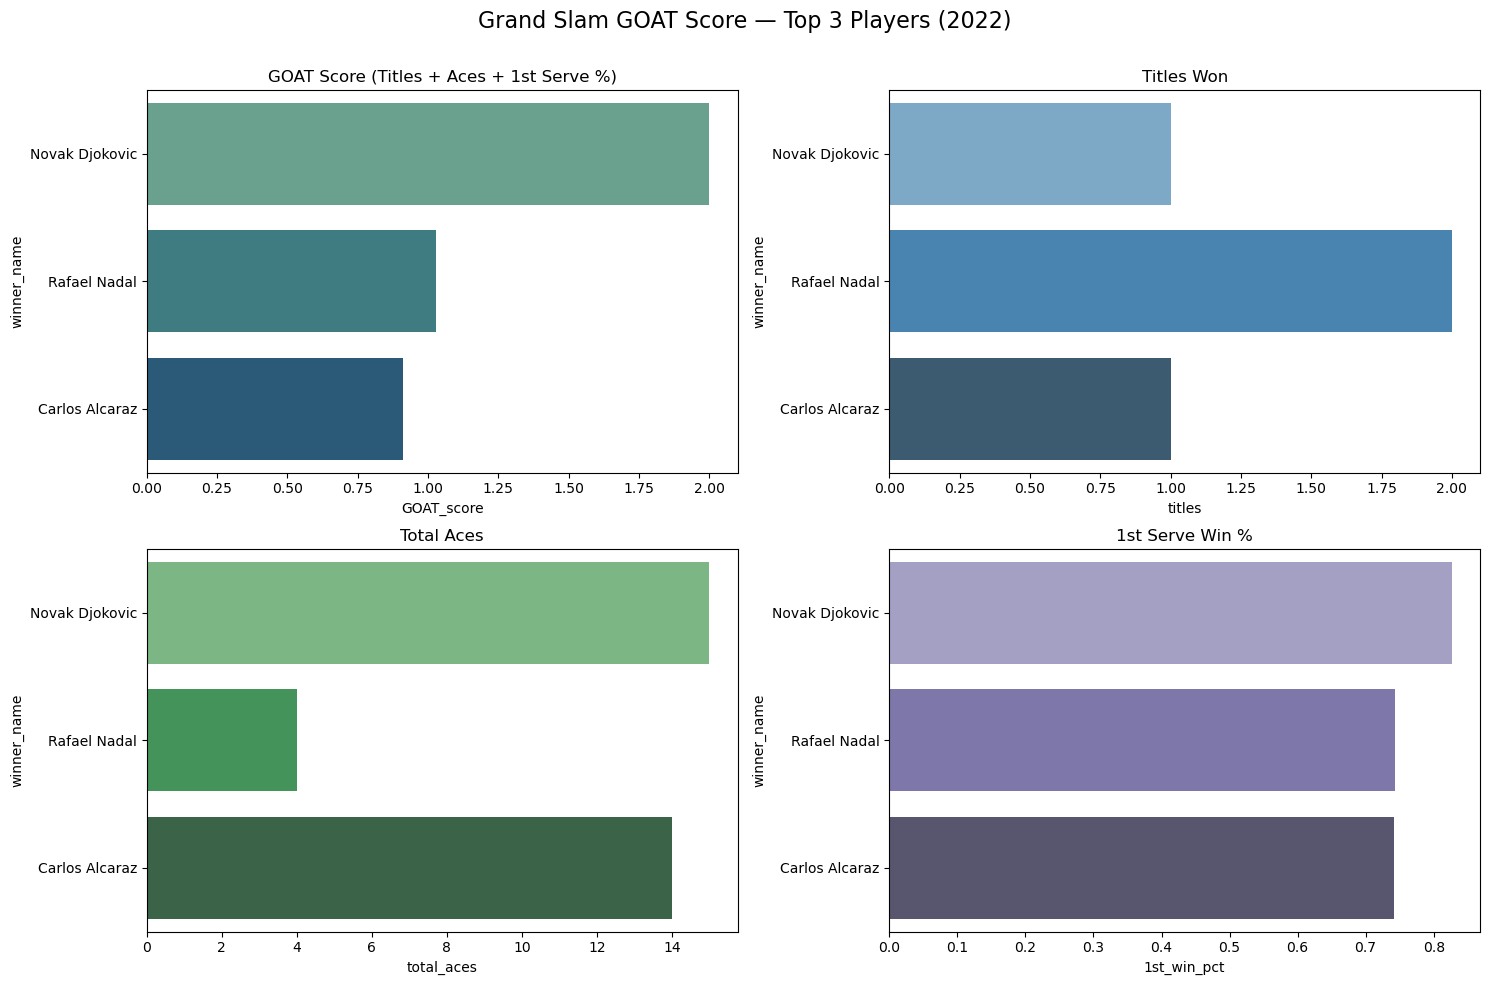

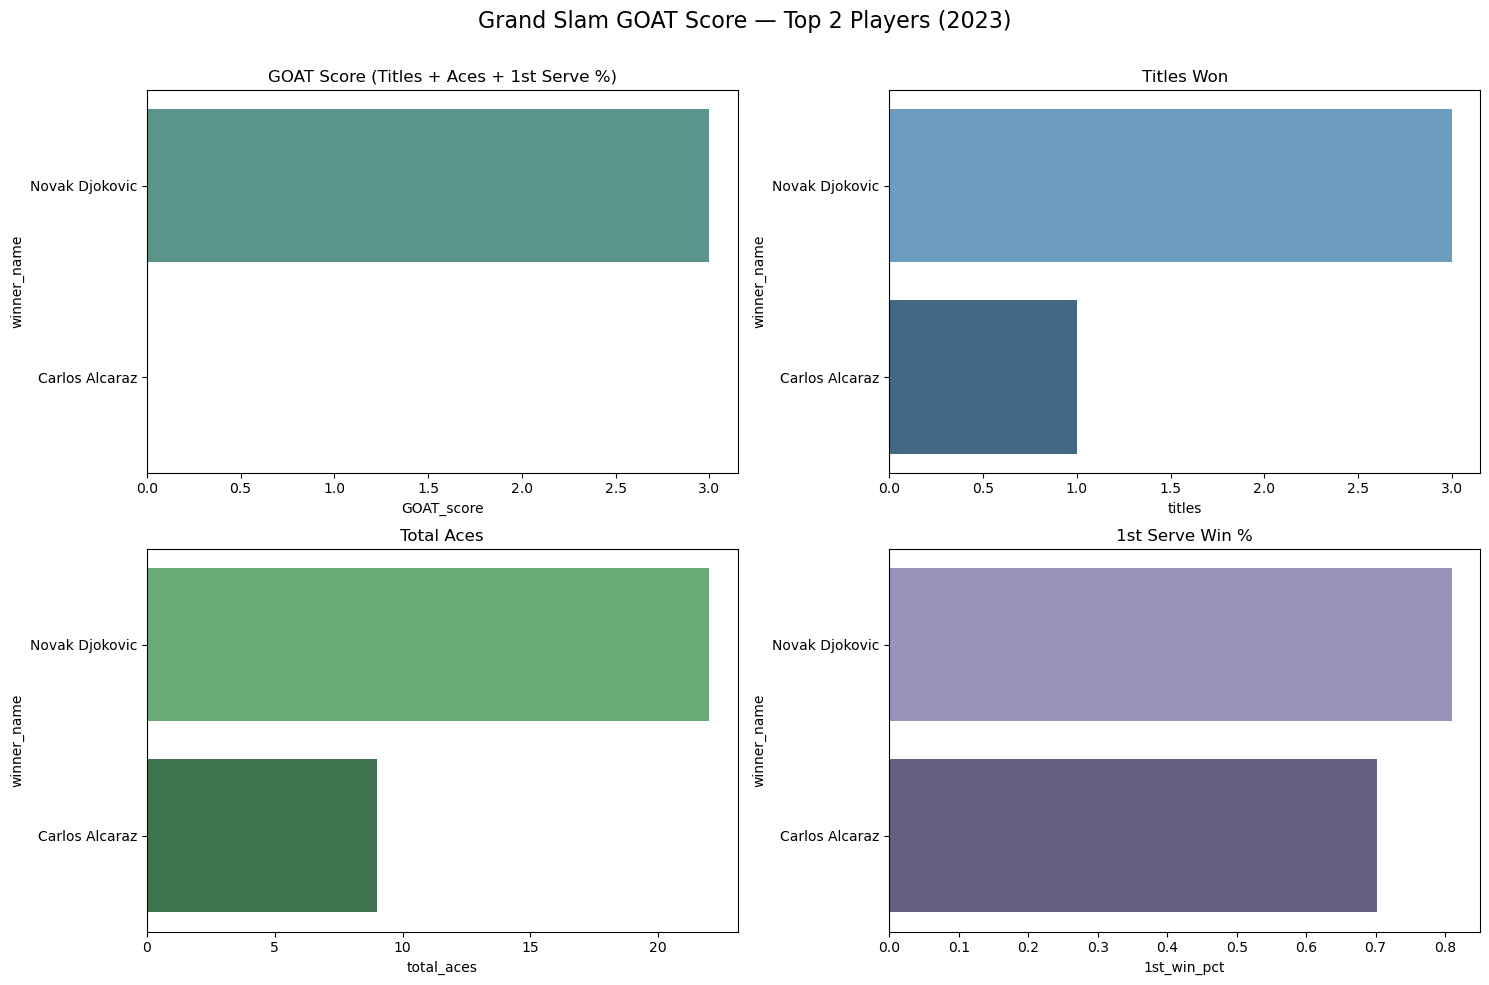

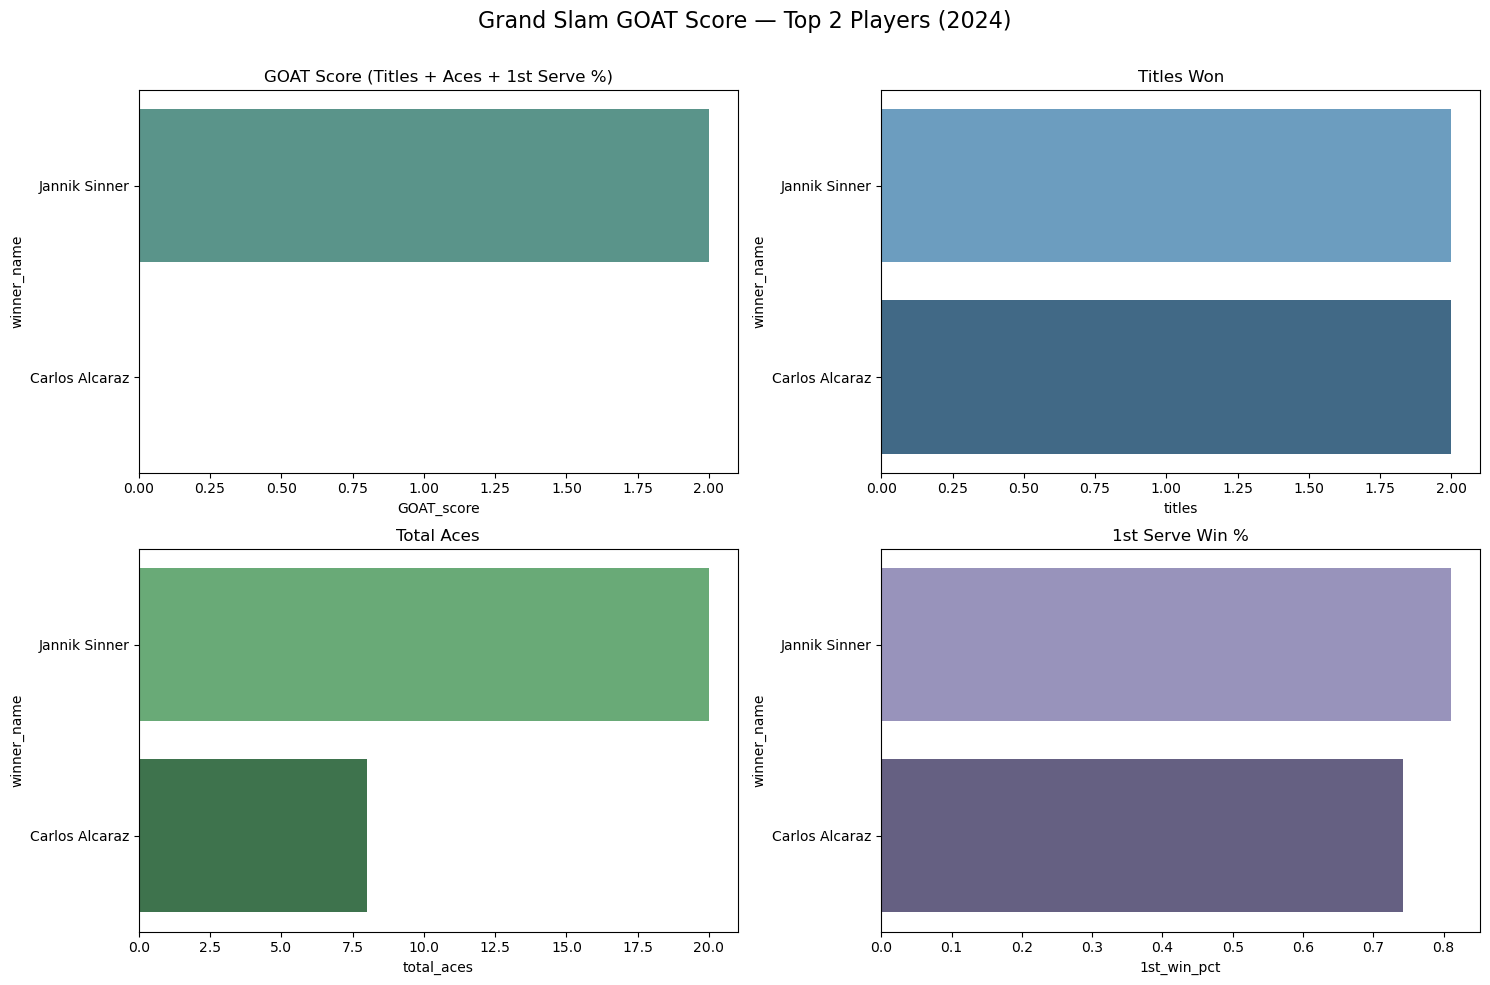

In [ ]:
# Plot GOAT score per year for all Grand Slam final winners (max 4 per year)
for year in sorted(goat_data['year'].unique()):
    yearly_data = goat_data[goat_data['year'] == year]

    num_players = len(yearly_data)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Grand Slam GOAT Score — Top {num_players} Player{"s" if num_players > 1 else ""} ({year})', fontsize=16)

    # Plot 1: GOAT Score Bar
    sns.barplot(
        data=yearly_data,
        x='GOAT_score',
        y='winner_name',
        hue='winner_name',
        palette='crest',
        dodge=False,
        ax=axes[0, 0],
        legend=False
    )
    axes[0, 0].set_title('GOAT Score (Titles + Aces + 1st Serve %)')

    # Plot 2: Titles won
    sns.barplot(
        data=yearly_data,
        x='titles',
        y='winner_name',
        hue='winner_name',
        palette='Blues_d',
        dodge=False,
        ax=axes[0, 1],
        legend=False
    )
    axes[0, 1].set_title('Titles Won')

    # Plot 3: Total Aces
    sns.barplot(
        data=yearly_data,
        x='total_aces',
        y='winner_name',
        hue='winner_name',
        palette='Greens_d',
        dodge=False,
        ax=axes[1, 0],
        legend=False
    )
    axes[1, 0].set_title('Total Aces')

    # Plot 4: 1st Serve Win Percentage
    sns.barplot(
        data=yearly_data,
        x='1st_win_pct',
        y='winner_name',
        hue='winner_name',
        palette='Purples_d',
        dodge=False,
        ax=axes[1, 1],
        legend=False
    )
    axes[1, 1].set_title('1st Serve Win %')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


## All-Time Grand Slam GOAT Rankings (Performance-Based)

This ranking evaluates players based on their **performance in Grand Slam finals**, not just titles won.

Each player's **GOAT score** is calculated from:
- Total Grand Slam titles
- Total aces in finals
- Average 1st serve win percentage in finals

All metrics are normalized and combined equally, providing a more balanced and data-driven view of Grand Slam greatness.


In [7]:
# Group by player to aggregate Grand Slam final stats
slam_goat_stats = slam_finals.groupby('winner_name').agg(
    total_titles = ('winner_name', 'count'),  # Count of finals won
    total_aces = ('w_ace', 'sum'),
    total_1st_won = ('w_1stWon', 'sum'),
    total_1st_in = ('w_1stIn', 'sum')
).reset_index()

# Derived stat: 1st serve win %
slam_goat_stats['1st_win_pct'] = slam_goat_stats['total_1st_won'] / slam_goat_stats['total_1st_in']
slam_goat_stats['1st_win_pct'] = slam_goat_stats['1st_win_pct'].fillna(0)

# Normalize and compute GOAT score
scaler = MinMaxScaler()

slam_goat_stats['titles_norm'] = scaler.fit_transform(slam_goat_stats[['total_titles']])
slam_goat_stats['aces_norm'] = scaler.fit_transform(slam_goat_stats[['total_aces']])
slam_goat_stats['serve_norm'] = scaler.fit_transform(slam_goat_stats[['1st_win_pct']])

# Combine metrics into GOAT score
slam_goat_stats['GOAT_score'] = (
    slam_goat_stats['titles_norm'] +
    slam_goat_stats['aces_norm'] +
    slam_goat_stats['serve_norm']
)

# Rank players
slam_goat_stats = slam_goat_stats.sort_values(by='GOAT_score', ascending=False)
slam_goat_stats['GOAT_rank'] = slam_goat_stats.reset_index().index + 1

# Display result
print("All-Time Grand Slam GOAT Rankings — Based on Titles, Aces, and 1st Serve Win %")
print(slam_goat_stats[['GOAT_rank', 'winner_name', 'total_titles', 'total_aces', '1st_win_pct', 'GOAT_score']])


All-Time Grand Slam GOAT Rankings — Based on Titles, Aces, and 1st Serve Win %
    GOAT_rank            winner_name  total_titles  total_aces  1st_win_pct  \
28          1          Roger Federer            20       308.0     0.778860   
22          2         Novak Djokovic            24       180.0     0.734499   
24          3           Pete Sampras            14       223.0     0.866159   
26          4           Rafael Nadal            22        80.0     0.709236   
1           5           Andre Agassi             8        53.0     0.742857   
4           6           Andy Roddick             1        23.0     0.890909   
30          7          Stan Wawrinka             3        37.0     0.764192   
31          8          Stefan Edberg             3        10.0     0.819672   
6           9         Carlos Alcaraz             4        31.0     0.719033   
23         10         Patrick Rafter             2        14.0     0.833333   
32         11       Thomas Johansson             1  

### All-Time Grand Slam GOATs — Top 10 Visualization

This visualization displays the **Top 10 players in Grand Slam finals history**, based on a **composite GOAT score** that combines:
- **Total Grand Slam titles**
- **Total aces served in finals**
- **1st serve win percentage**

Each of these metrics is **normalized** across all players for a fair comparison, ensuring that different scales of performance are accounted for equally. The **GOAT score** reflects both **achievement (titles)** and **dominance (aces and 1st serve efficiency)** in Grand Slam finals.

Additionally, smaller breakdown plots show how each player contributed to their overall **GOAT score** through:
1. **Titles won**
2. **Total aces**
3. **1st serve win %**

This provides a detailed view of each player's **performance and impact** in Grand Slam tournaments over time.


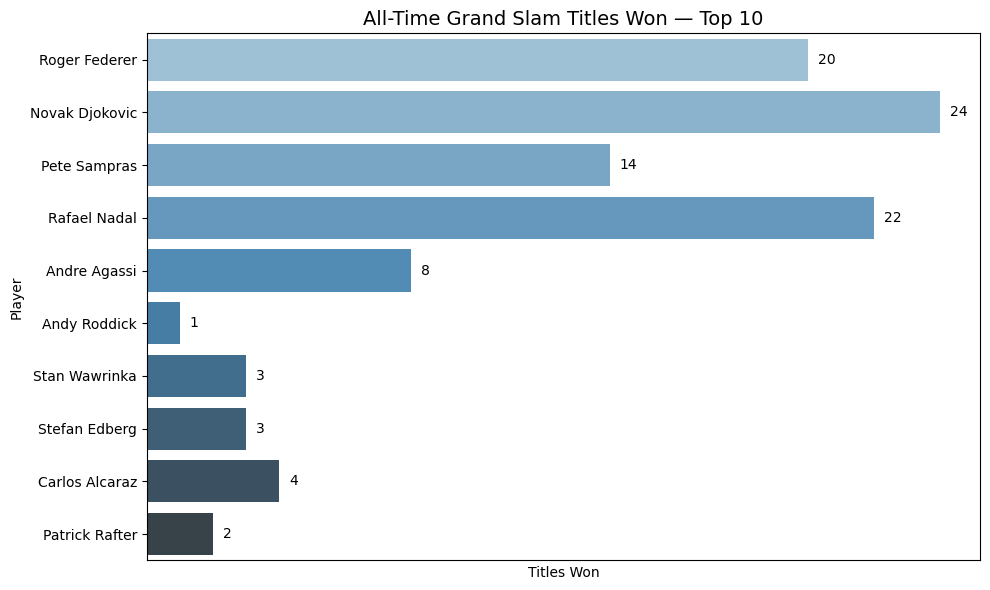

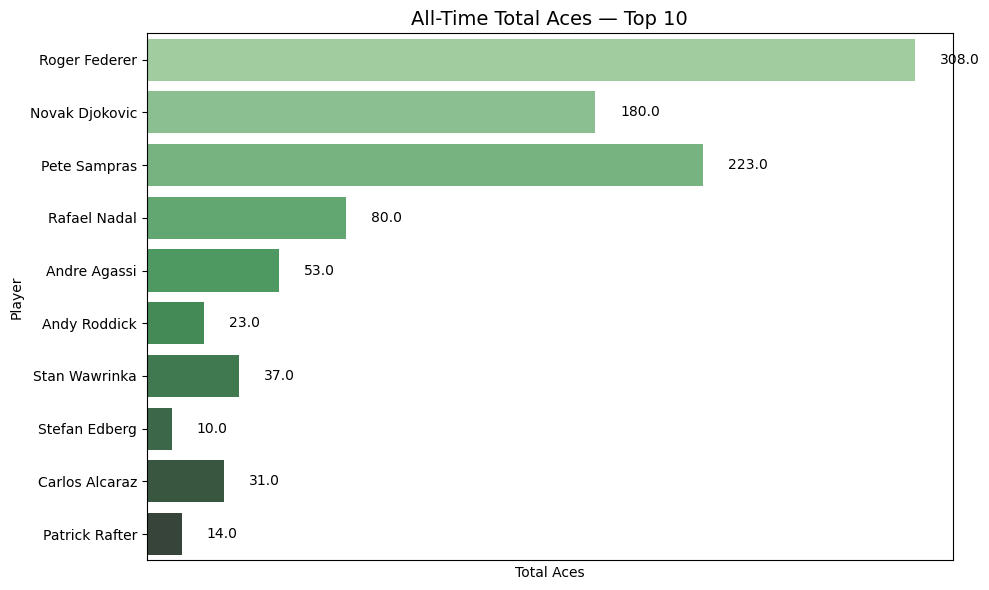

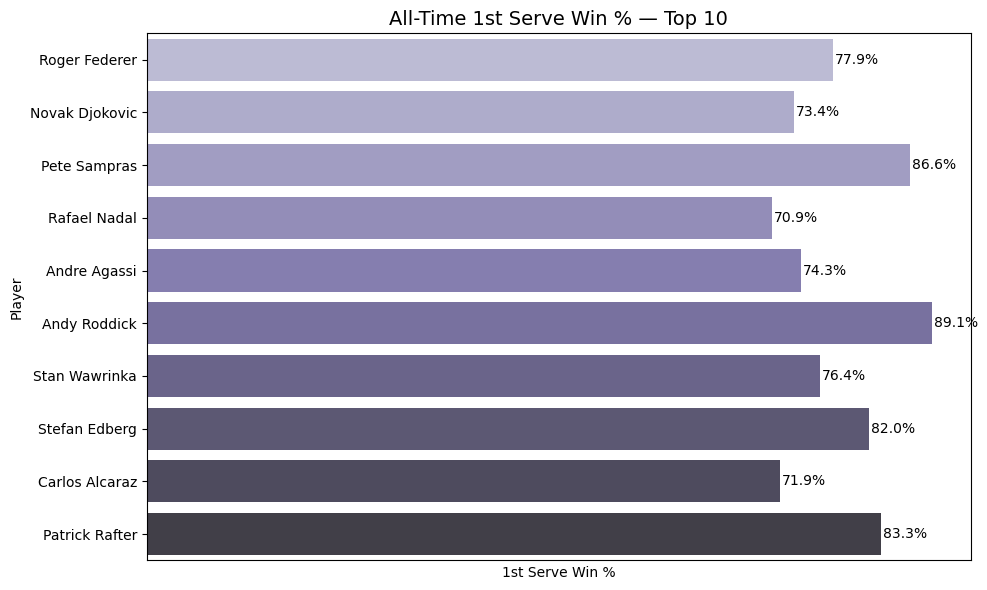

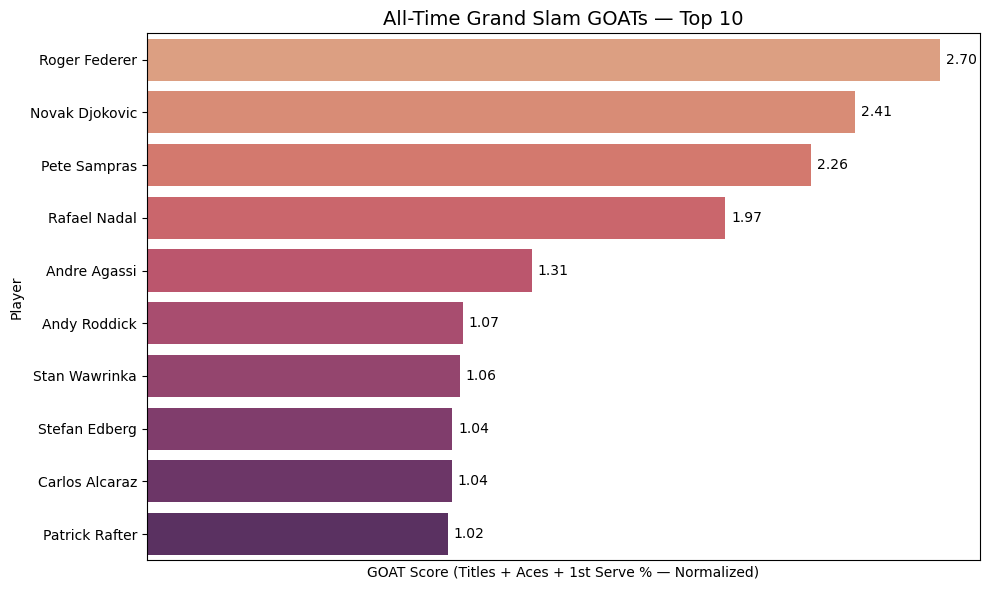

In [ ]:
# Step 1: Normalize each metric
scaler = MinMaxScaler()

slam_goat_stats['titles_norm'] = scaler.fit_transform(slam_goat_stats[['total_titles']])
slam_goat_stats['aces_norm'] = scaler.fit_transform(slam_goat_stats[['total_aces']])
slam_goat_stats['serve_norm'] = scaler.fit_transform(slam_goat_stats[['1st_win_pct']])

# Step 2: Combine normalized metrics into GOAT score
slam_goat_stats['GOAT_score'] = (
    slam_goat_stats['titles_norm'] +
    slam_goat_stats['aces_norm'] +
    slam_goat_stats['serve_norm']
)

# Step 3: Rank players based on GOAT score
slam_goat_stats = slam_goat_stats.sort_values(by='GOAT_score', ascending=False)
slam_goat_stats['GOAT_rank'] = slam_goat_stats.reset_index().index + 1

# Step 4: Select top 10 GOATs
top10_slam_goats = slam_goat_stats.head(10)

# Plotting — Titles Won
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_slam_goats,
    x='total_titles',
    y='winner_name',
    hue='winner_name',
    palette='Blues_d',
    dodge=False,
    legend=False
)
plt.title("All-Time Grand Slam Titles Won — Top 10", fontsize=14)
plt.xlabel("Titles Won")
plt.ylabel("Player")

# Add value labels
for i, (val, name) in enumerate(zip(top10_slam_goats['total_titles'], top10_slam_goats['winner_name'])):
    ax.text(val + 0.3, i, str(val), va='center', fontsize=10)

plt.xticks([])  # Remove x-ticks
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting — Total Aces
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_slam_goats,
    x='total_aces',
    y='winner_name',
    hue='winner_name',
    palette='Greens_d',
    dodge=False,
    legend=False
)
plt.title("All-Time Total Aces — Top 10", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

# Add value labels
for i, (val, name) in enumerate(zip(top10_slam_goats['total_aces'], top10_slam_goats['winner_name'])):
    ax.text(val + 10, i, str(val), va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting — 1st Serve Win %
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_slam_goats,
    x='1st_win_pct',
    y='winner_name',
    hue='winner_name',
    palette='Purples_d',
    dodge=False,
    legend=False
)
plt.title("All-Time 1st Serve Win % — Top 10", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

# Add value labels as percentages
for i, (val, name) in enumerate(zip(top10_slam_goats['1st_win_pct'], top10_slam_goats['winner_name'])):
    ax.text(val + 0.002, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting — GOAT Score
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_slam_goats,
    x='GOAT_score',
    y='winner_name',
    hue='winner_name',
    palette='flare',
    dodge=False,
    legend=False
)
plt.title("All-Time Grand Slam GOATs — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Titles + Aces + 1st Serve % — Normalized)")
plt.ylabel("Player")

# Add value labels to bars
for i, (val, name) in enumerate(zip(top10_slam_goats['GOAT_score'], top10_slam_goats['winner_name'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## Per-Year Tie-Breaker Comparison (Only Years with Title Ties)

This section visualizes performance stats for **years where two or more players won the same number of Grand Slam finals**.

For each tied year:
- Players are shown side-by-side by their **total aces** and **1st serve win %**
- These are the two metrics used to build the **combined performance score** in the GOAT ranking
- This chart helps explain how ties in title count were resolved

Note: This shows the **raw values**, not the normalized ones used in the final ranking.


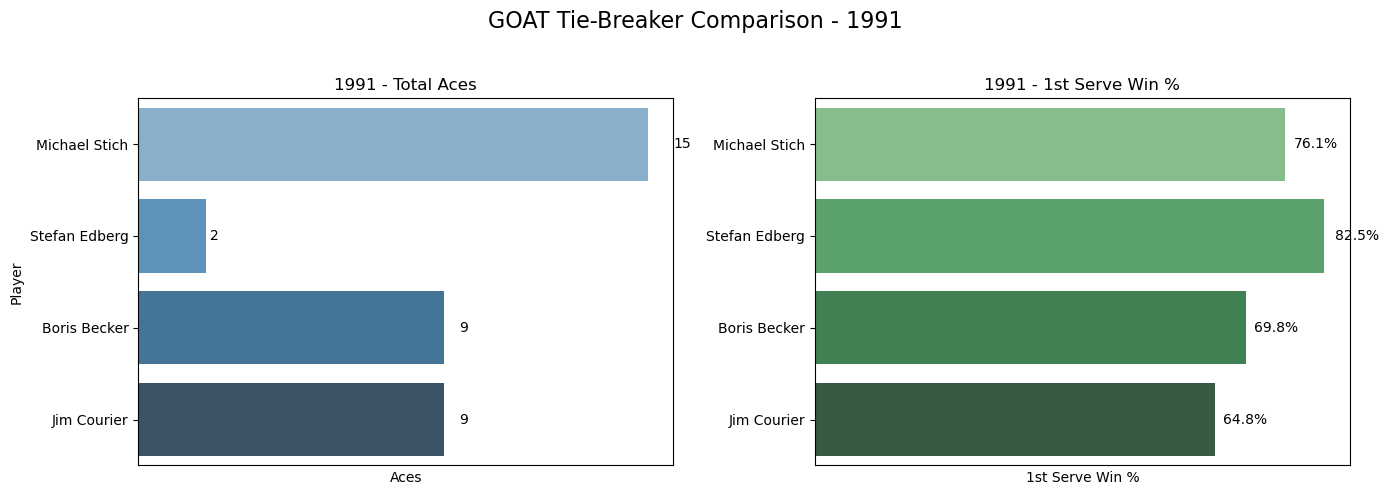

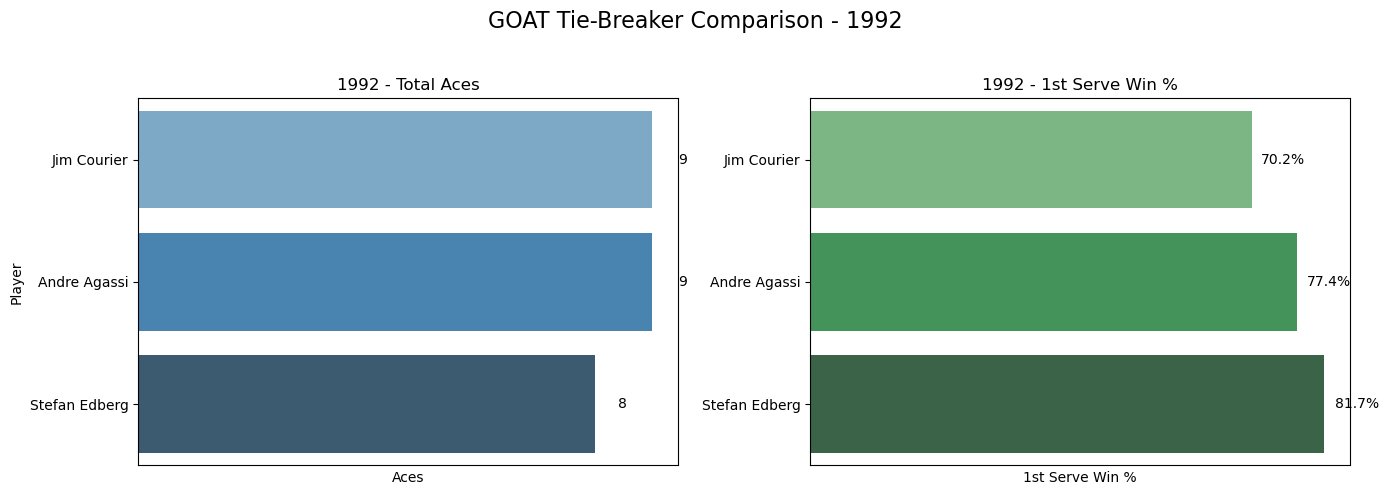

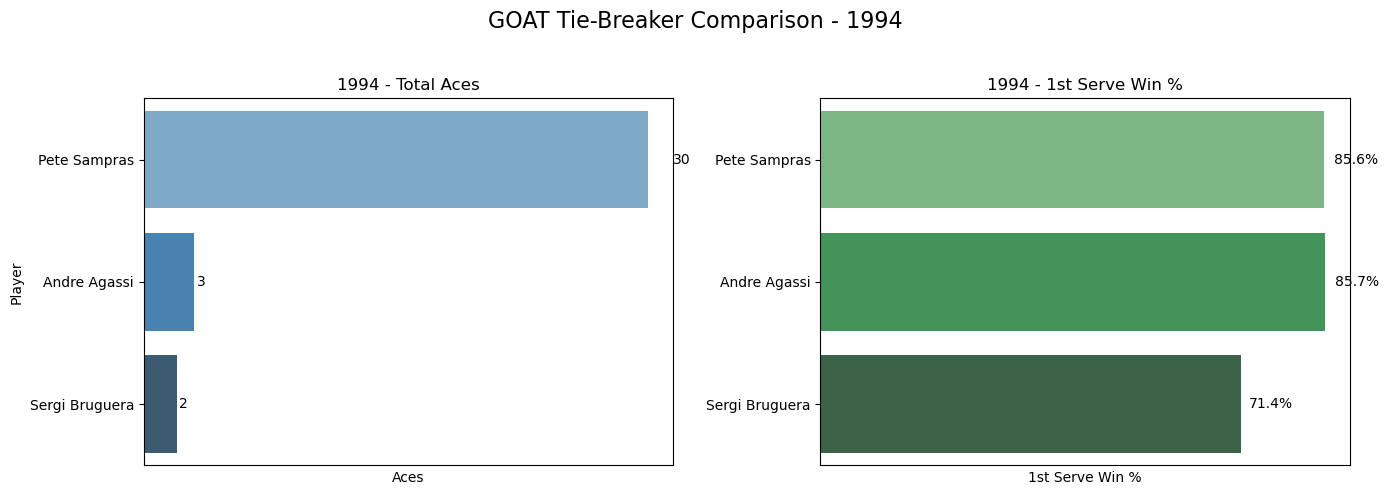

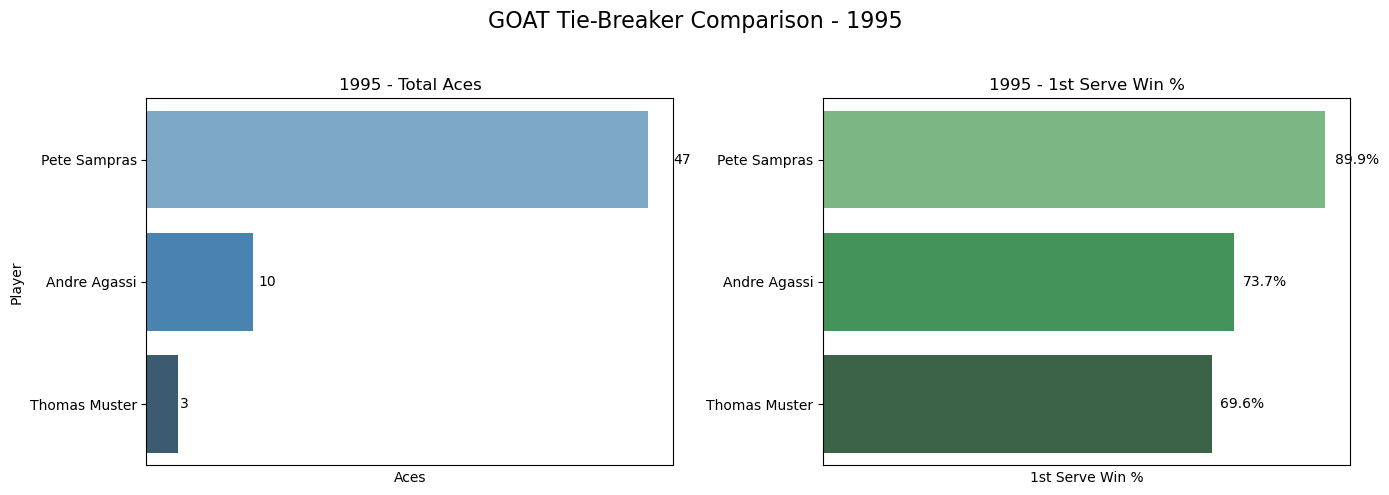

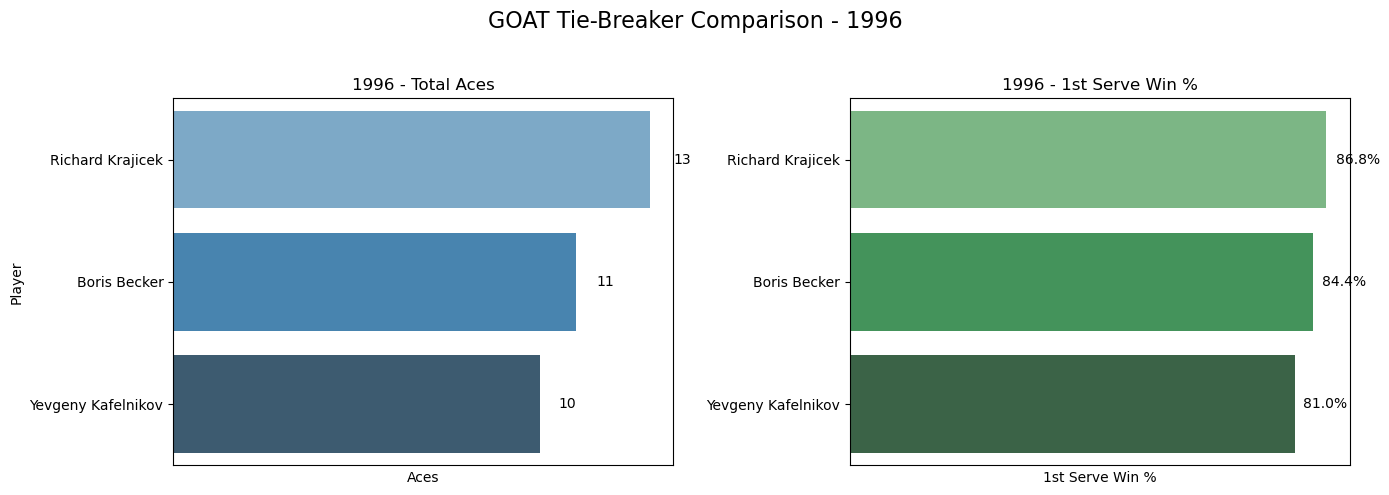

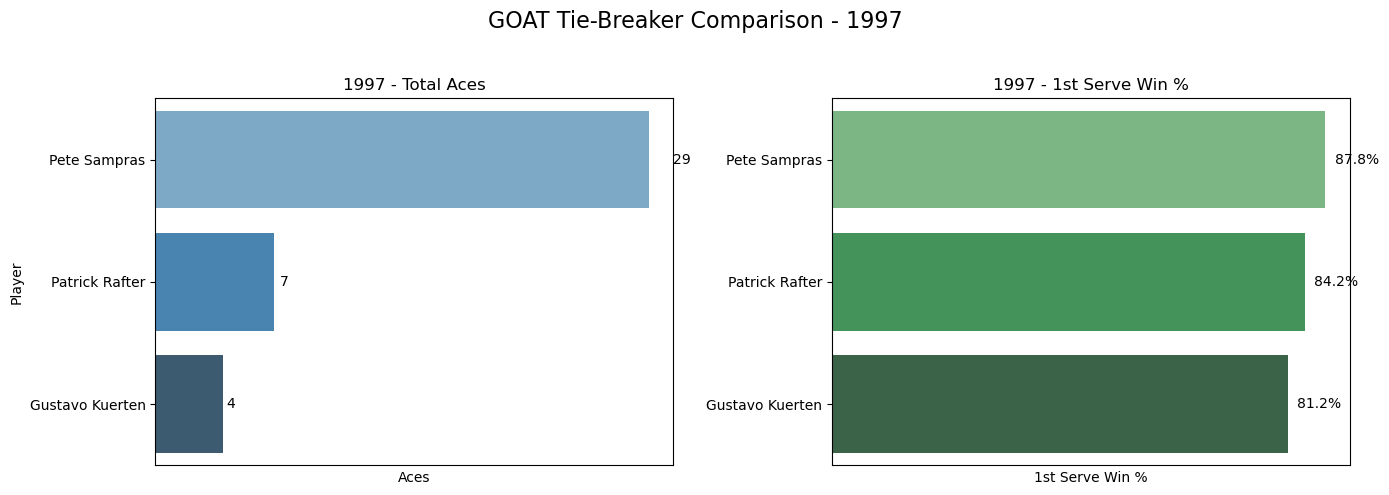

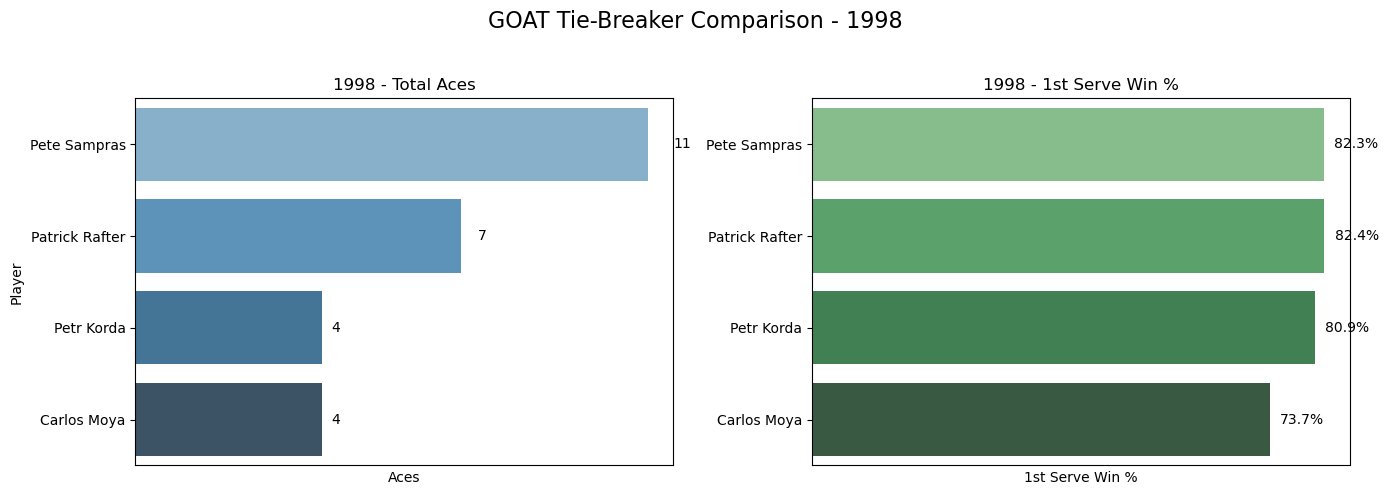

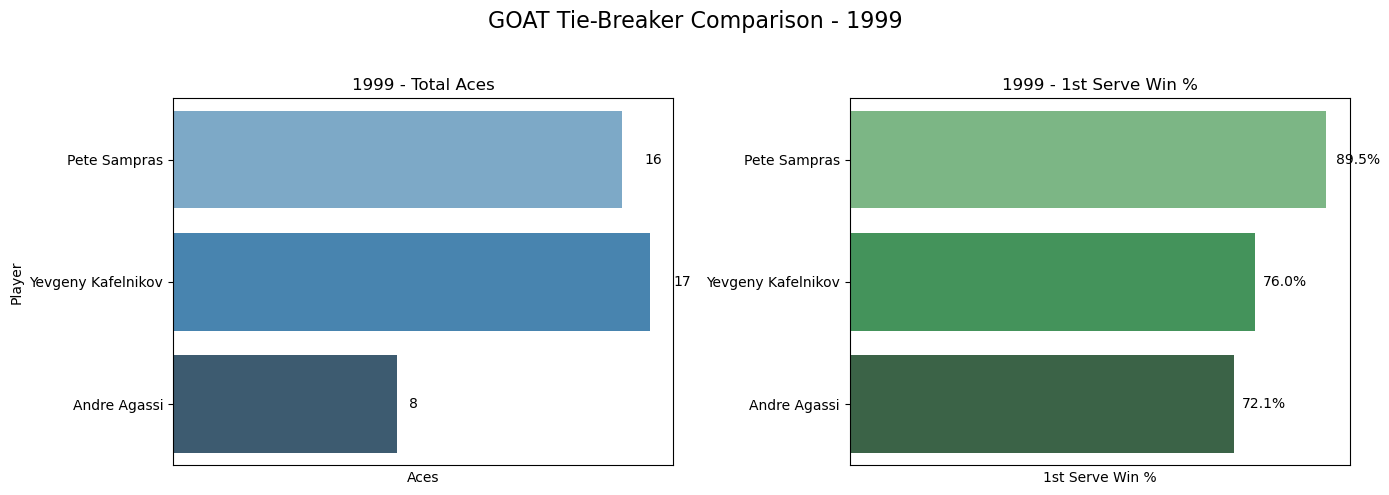

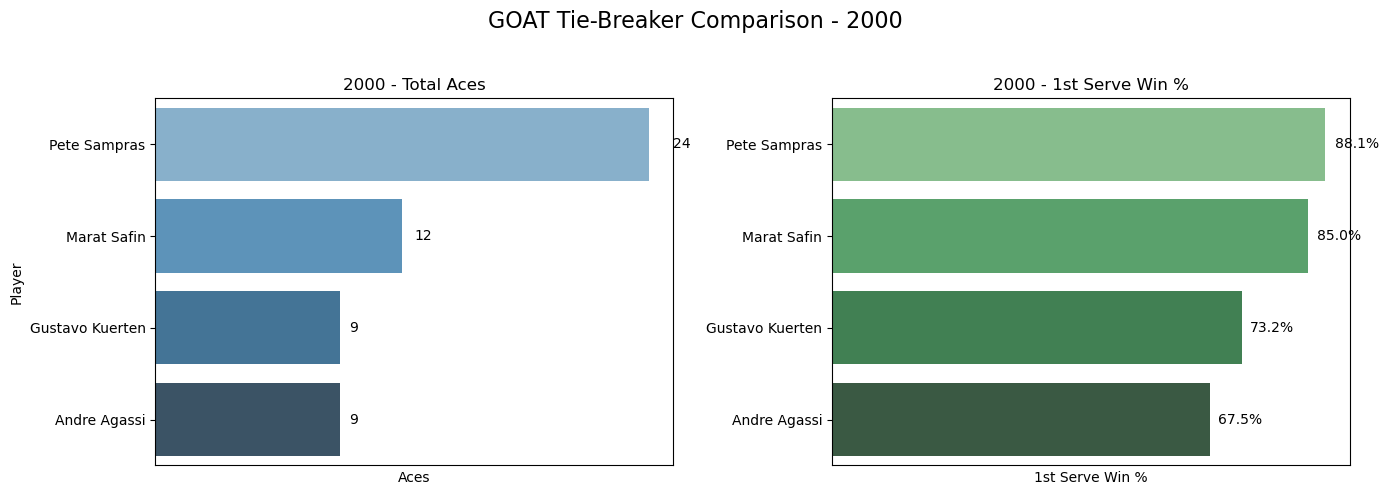

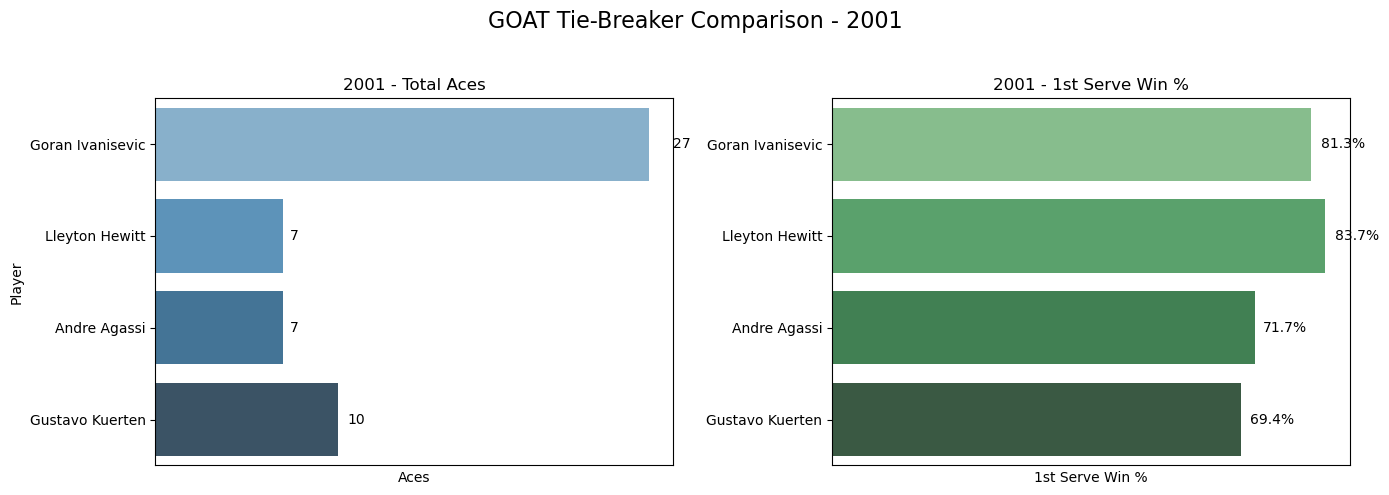

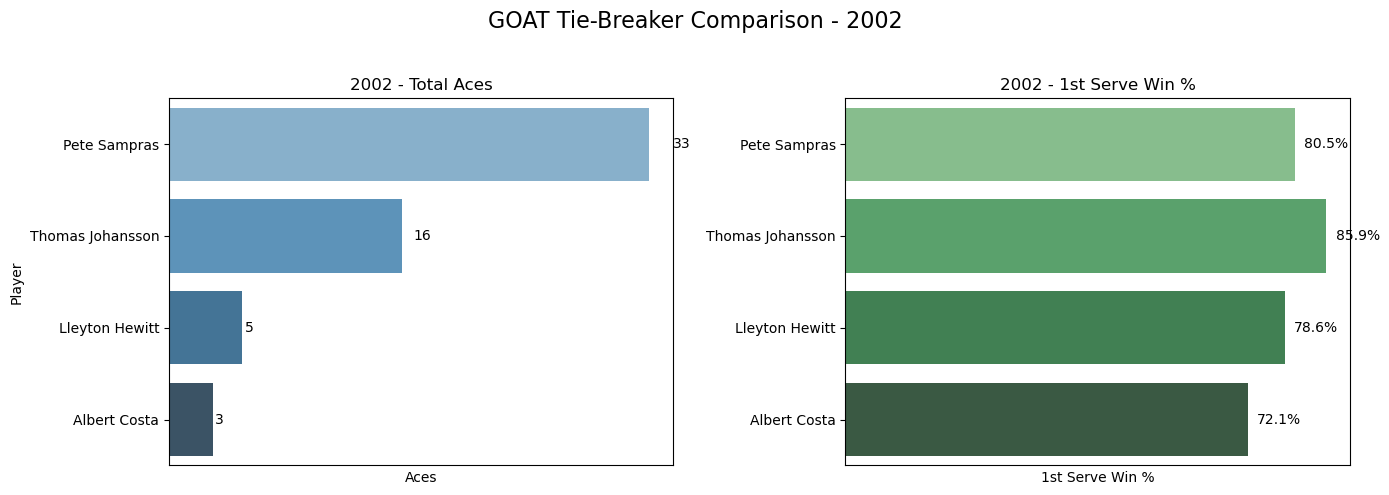

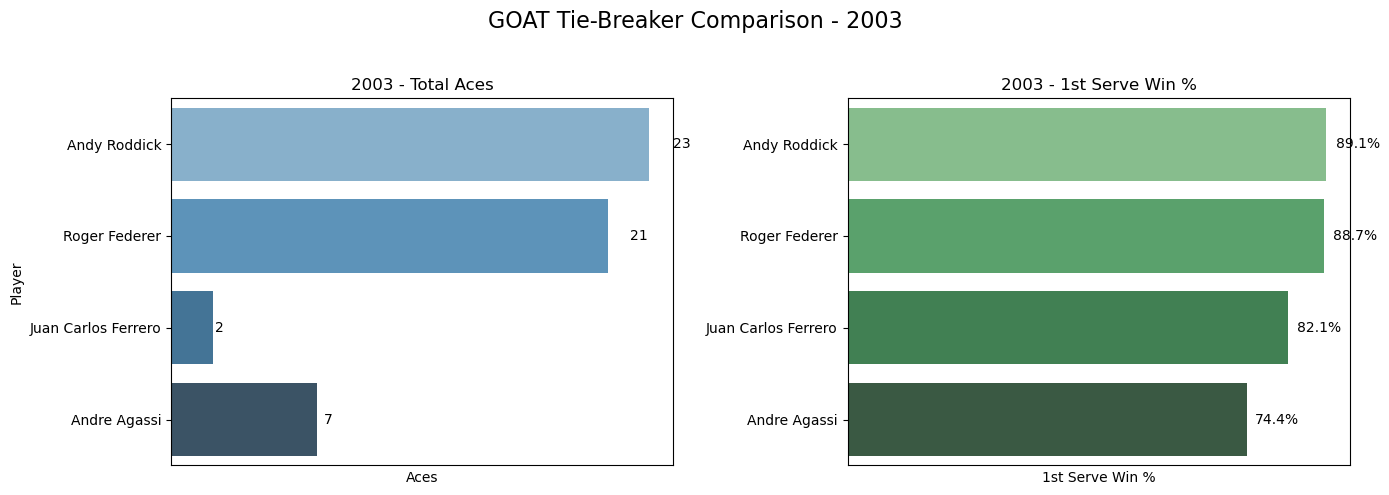

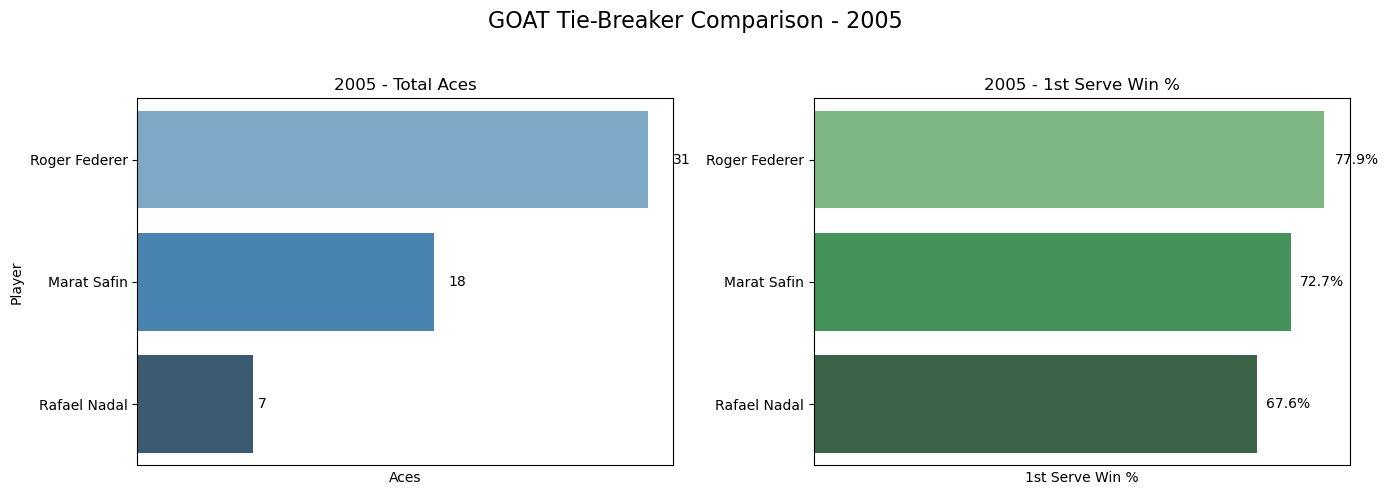

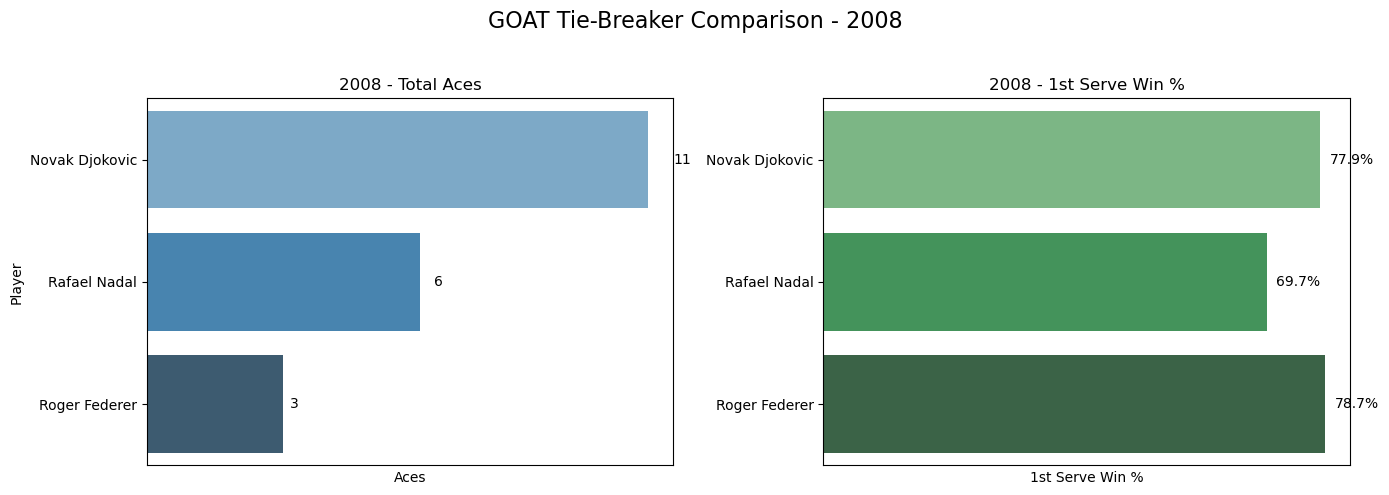

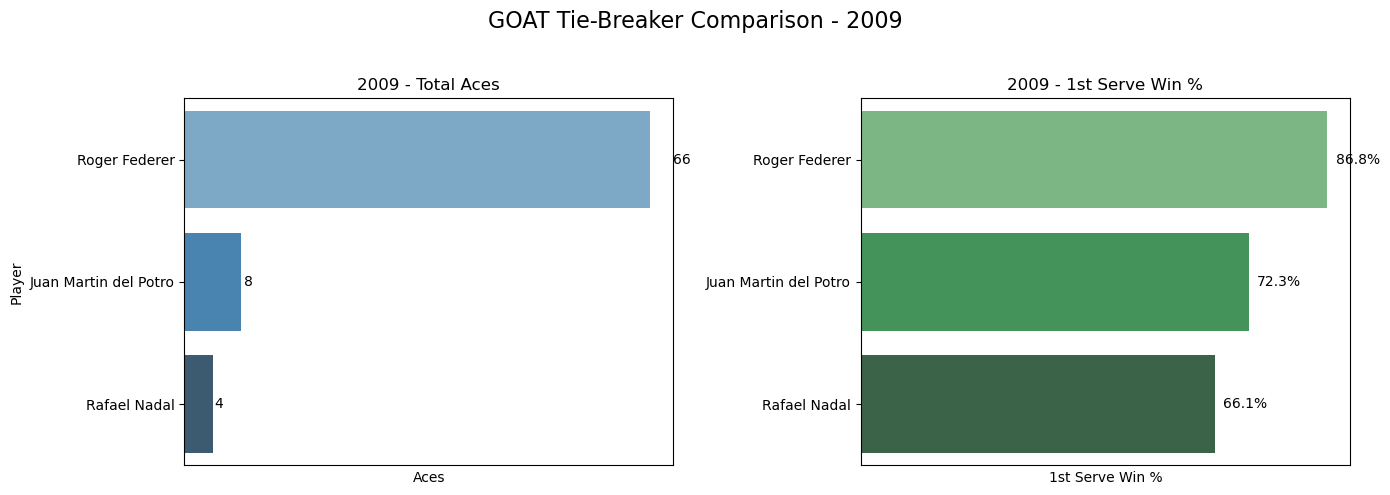

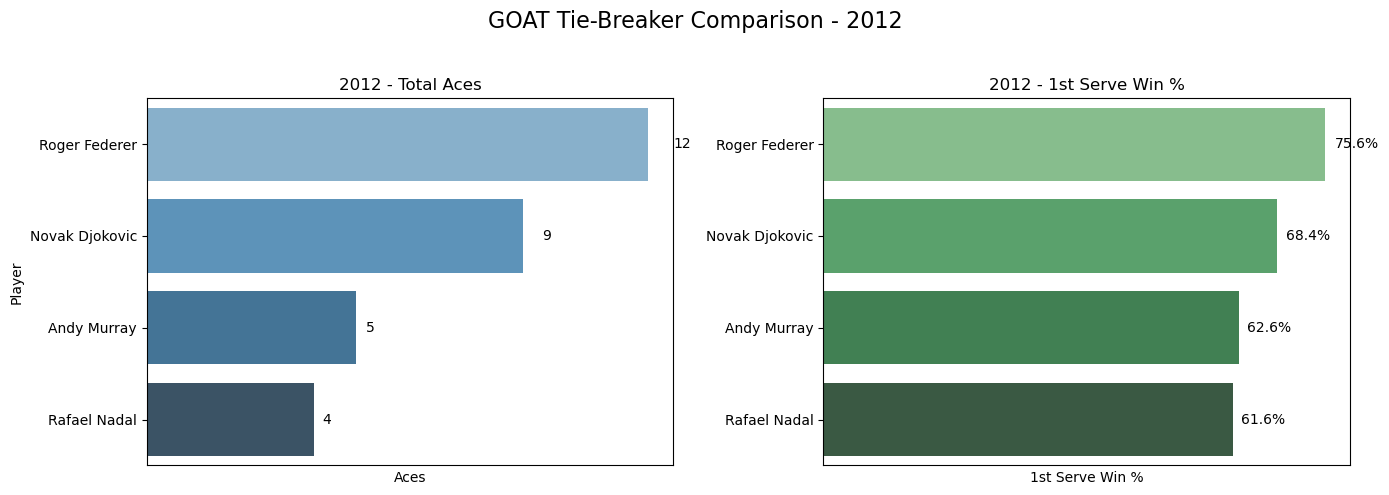

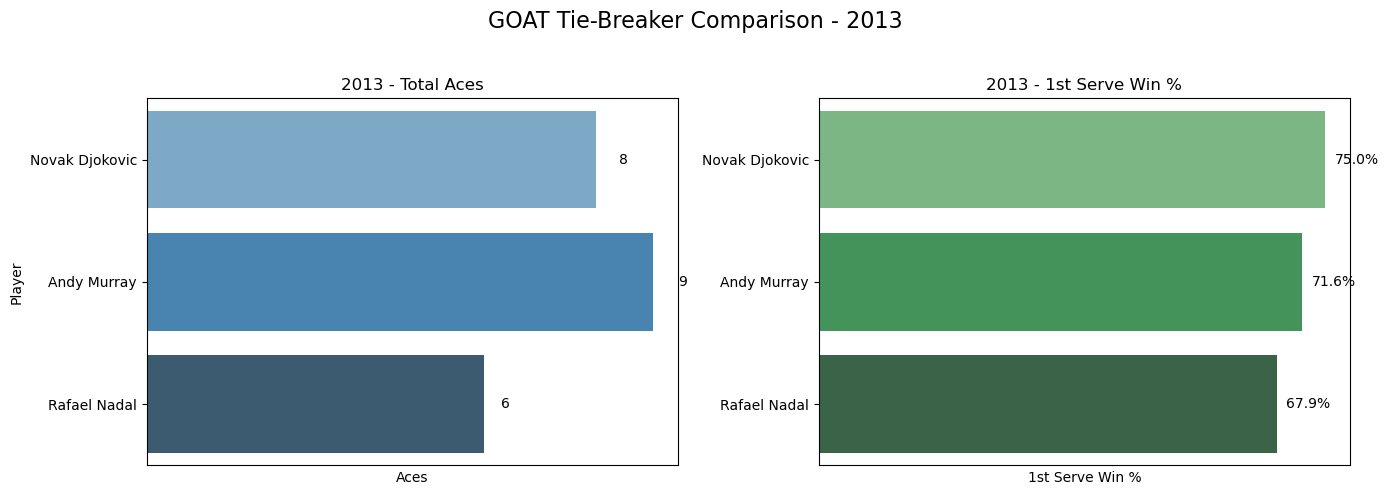

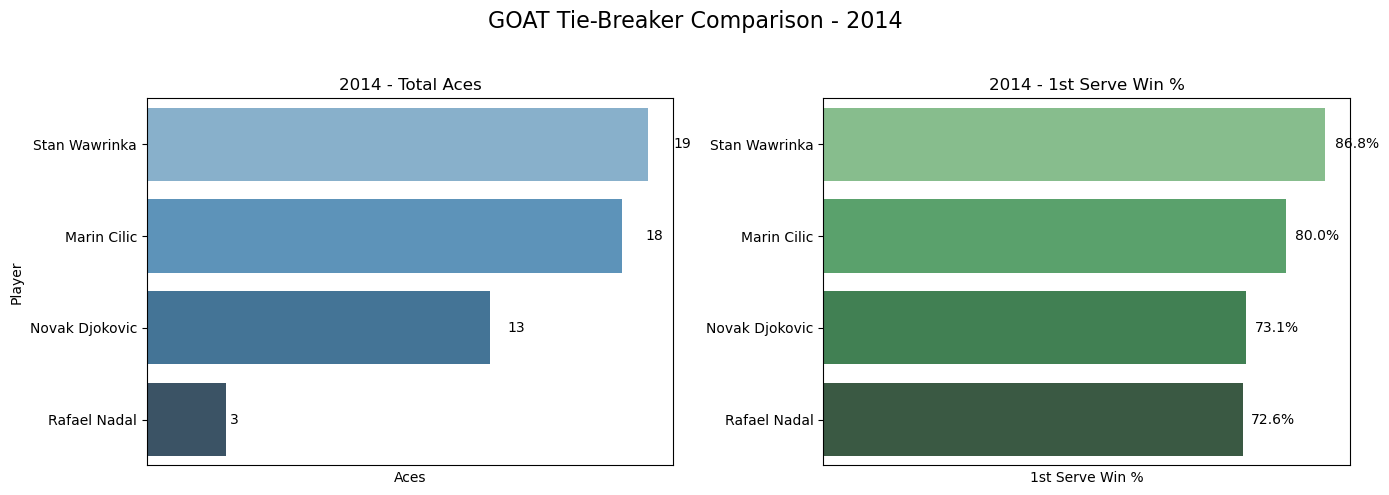

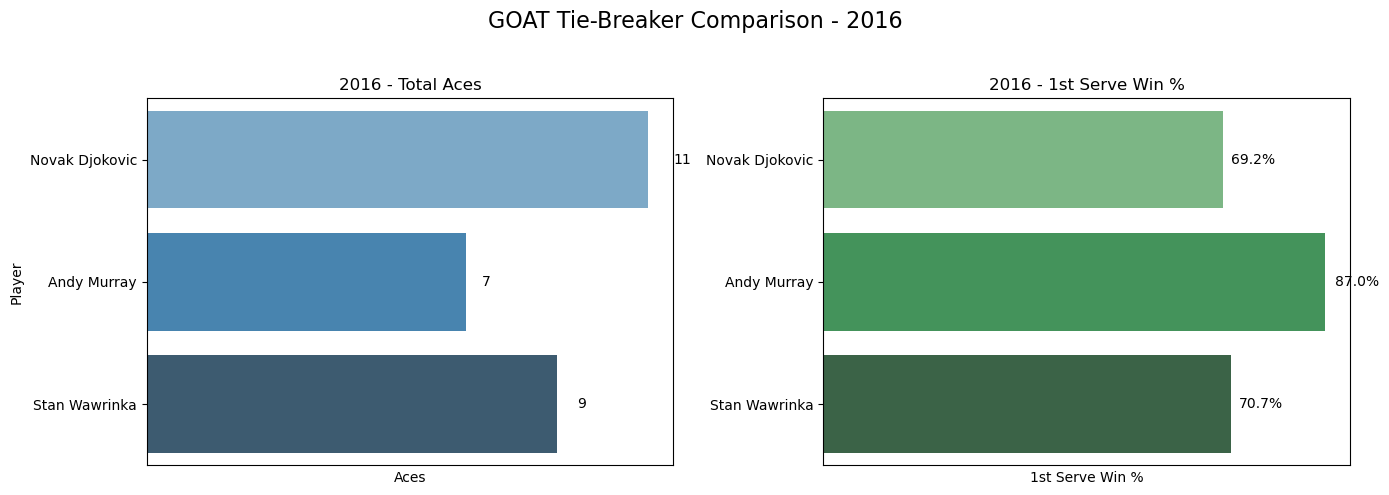

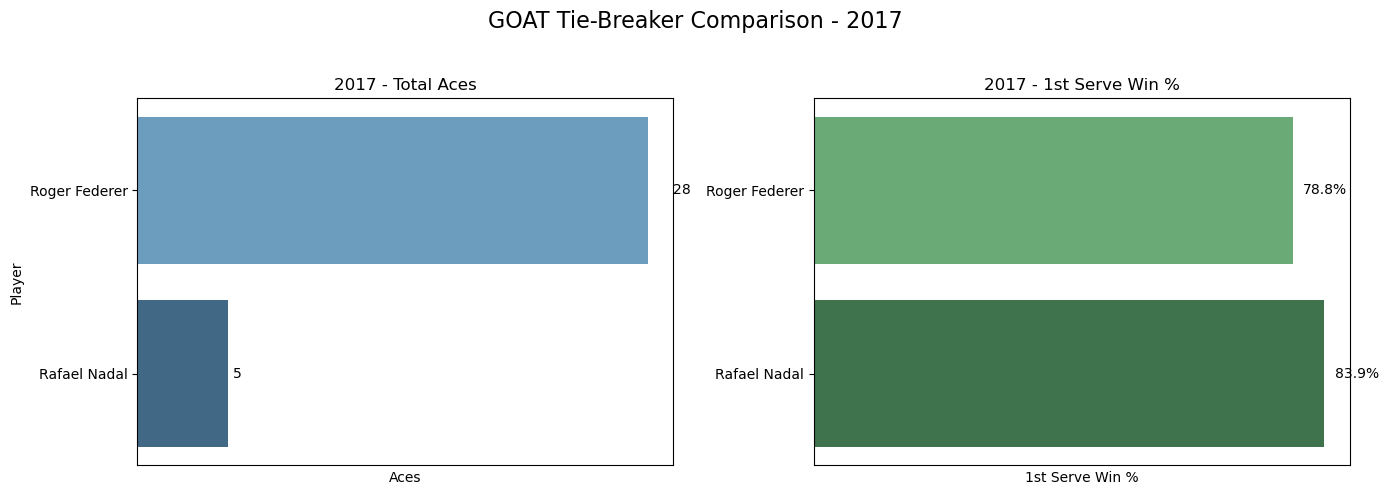

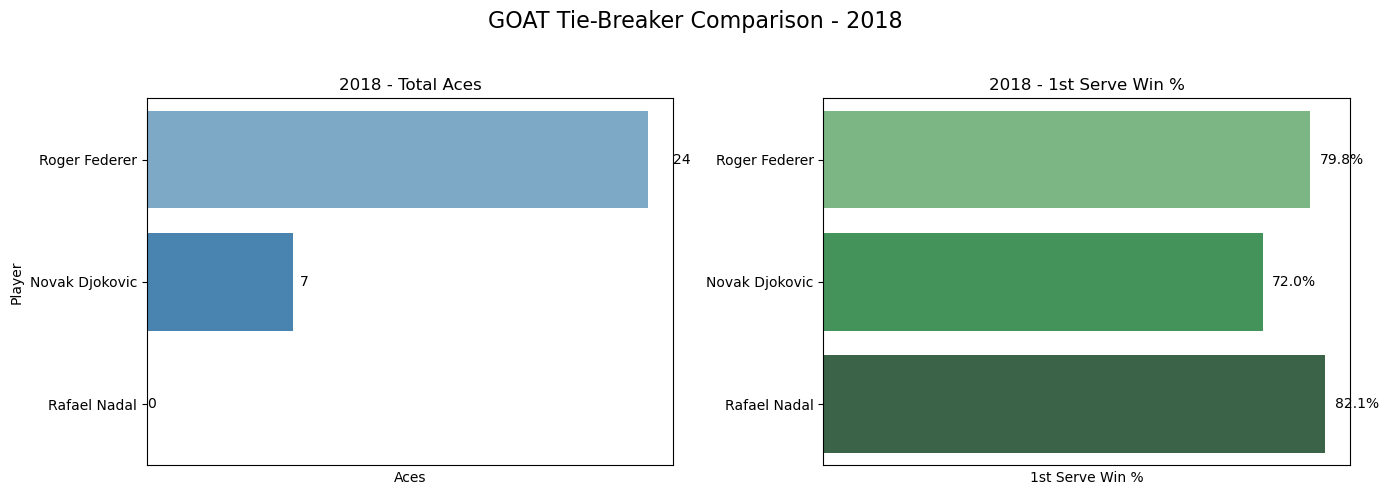

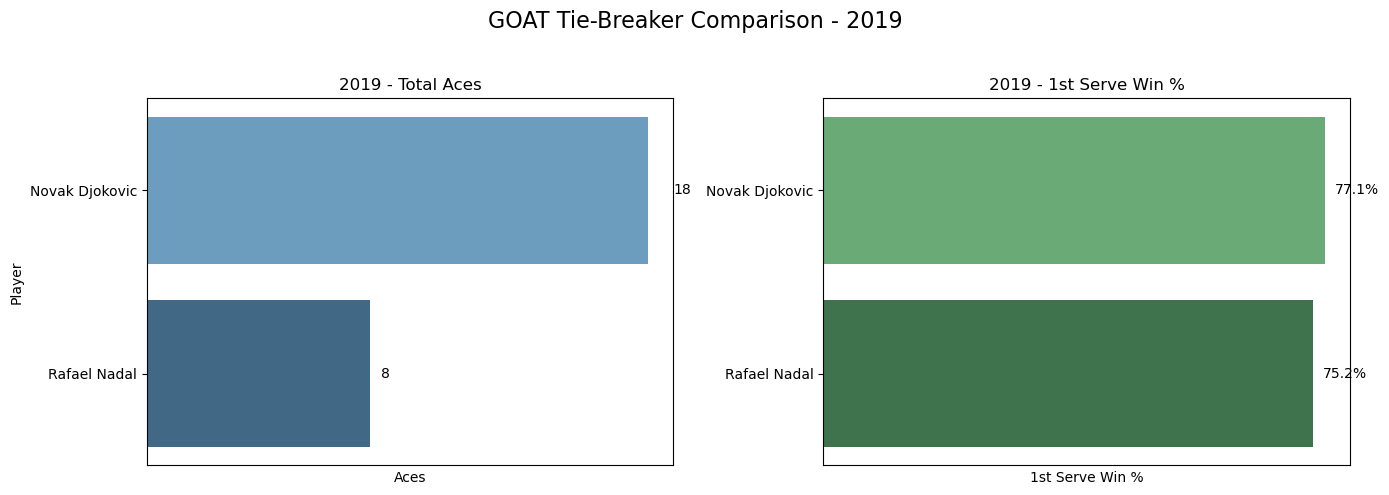

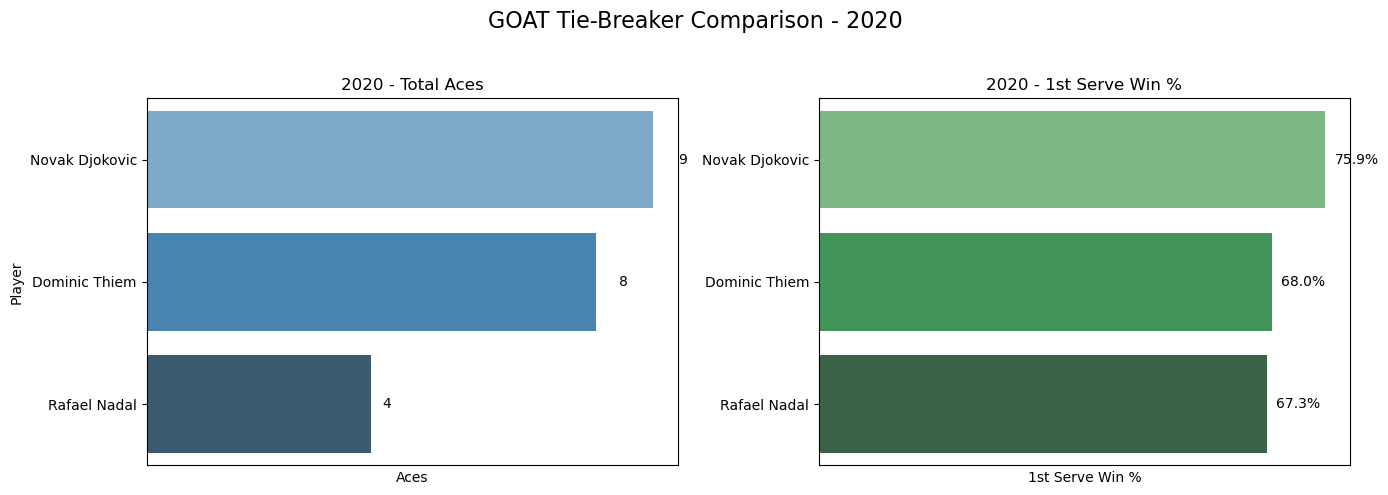

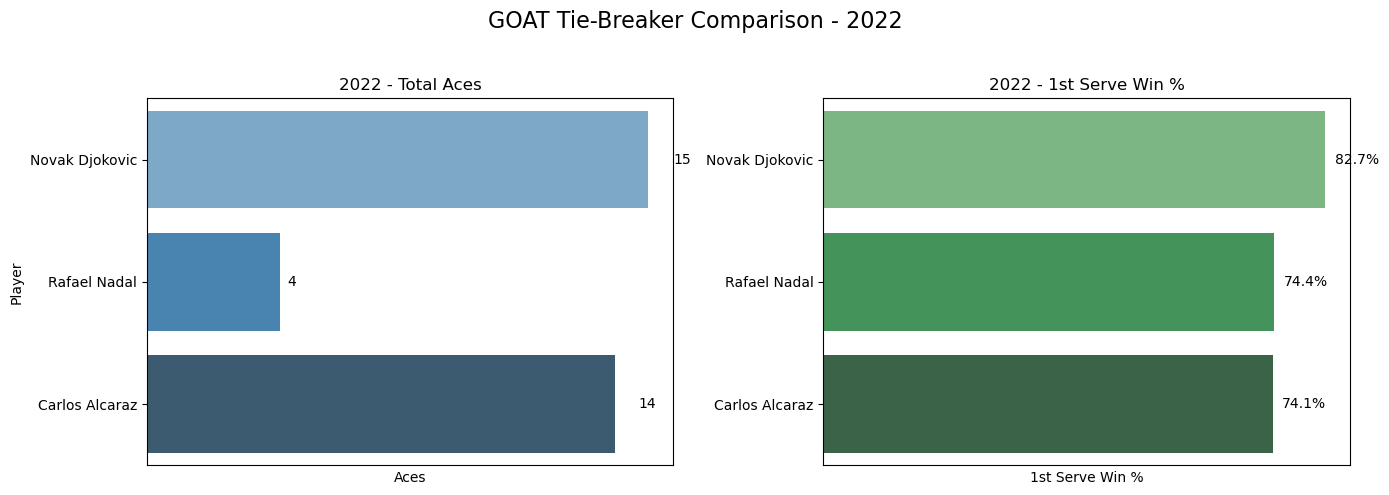

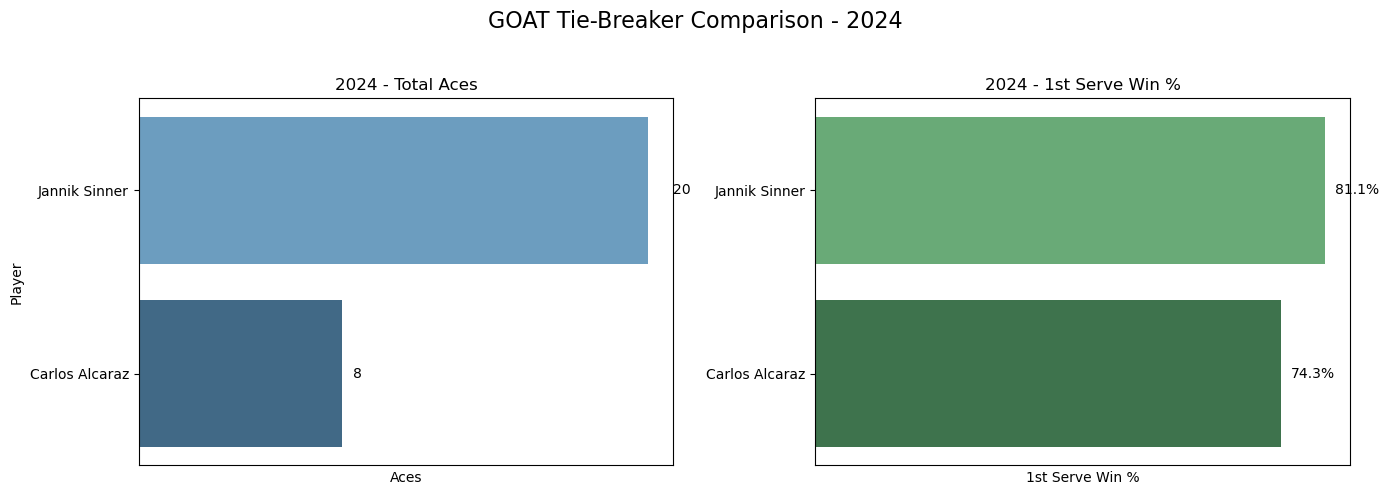

In [ ]:
# Step 1: Find years with ties in number of titles
tied_years = (
    goat_data.groupby(['year'])['titles']
    .value_counts()
    .reset_index(name='count')
    .query('count > 1')  # Only where more than 1 player had the same title count
)

# Get the years where there's a tie
years_with_ties = tied_years['year'].unique()

# Step 2: Filter only tied years from goat_data
tied_goat_data = goat_data[goat_data['year'].isin(years_with_ties)]

# Step 3: Create separate plots for each tied year
for year in sorted(years_with_ties):
    data = tied_goat_data[tied_goat_data['year'] == year].copy()

    # Skip year if all values are NaN or 0 for both tie-breakers
    if data[['total_aces', '1st_win_pct']].isna().all().all() or (
        data['total_aces'].fillna(0).sum() == 0 and data['1st_win_pct'].fillna(0).sum() == 0
    ):
        print(f"Skipping {year} — no valid stats for tie-breaker comparison.")
        continue

    # Replace NaNs with 0s to avoid empty bars
    data['total_aces'] = data['total_aces'].fillna(0)
    data['1st_win_pct'] = data['1st_win_pct'].fillna(0)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # --- Total Aces Plot ---
    sns.barplot(data=data, x='total_aces', y='winner_name', hue='winner_name',
                palette='Blues_d', ax=ax[0], dodge=False, legend=False)
    ax[0].set_title(f'{year} - Total Aces')
    ax[0].set_xlabel('Aces')
    ax[0].set_ylabel('Player')
    ax[0].grid(axis='x', linestyle='--', alpha=0.3)
    ax[0].set_xticks([])  # Remove x-axis ticks

    # Add value labels to aces
    for i, (val, name) in enumerate(zip(data['total_aces'], data['winner_name'])):
        offset = val * 0.05  # 5% of value to prevent too much gap
        ax[0].text(val + offset, i, f"{int(val)}", va='center', fontsize=10)


    # --- 1st Serve Win % Plot ---
    sns.barplot(data=data, x='1st_win_pct', y='winner_name', hue='winner_name',
                palette='Greens_d', ax=ax[1], dodge=False, legend=False)
    ax[1].set_title(f'{year} - 1st Serve Win %')
    ax[1].set_xlabel('1st Serve Win %')
    ax[1].set_ylabel('')
    ax[1].grid(axis='x', linestyle='--', alpha=0.3)
    ax[1].set_xticks([])  # Remove x-axis ticks

    # Add value labels to 1st Serve %
    for i, (val, name) in enumerate(zip(data['1st_win_pct'], data['winner_name'])):
        offset = val * 0.02  # Adjust dynamically based on % scale
        ax[1].text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)


    # Layout and display
    fig.suptitle(f"GOAT Tie-Breaker Comparison - {year}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


## Detect Calendar Grand Slam Winners

This section identifies players who achieved a **Calendar Grand Slam** — winning **all four Grand Slam tournaments** in a **single calendar year**:

- Australian Open
- Roland Garros (French Open)
- Wimbledon
- US Open

Winning all four in the same year is extremely rare and considered one of the greatest accomplishments in tennis.

The code checks, for each year and player, whether they won **all four majors**.


In [51]:
# List of Grand Slam tournaments
slam_names = ['Australian Open', 'Roland Garros', 'Wimbledon', 'US Open']

# Step 1: Filter Grand Slam finals
slam_finals = major_matches[
    (major_matches['tourney_level'] == 'G') &
    (major_matches['round'] == 'F')
].copy()

# Step 2: Group by year and winner, get set of won tournaments
player_slams_per_year = slam_finals.groupby(['year', 'winner_name'])['tourney_name'].apply(set).reset_index()

# Step 3: Check if player won all 4 Slams
player_slams_per_year['calendar_slam'] = player_slams_per_year['tourney_name'].apply(
    lambda tourneys: set(slam_names).issubset(tourneys)
)

# Step 4: Filter only true cases
calendar_slam_winners = player_slams_per_year[player_slams_per_year['calendar_slam'] == True]

# Display results
print("Calendar Grand Slam Winners:")
print(calendar_slam_winners[['year', 'winner_name']])


Calendar Grand Slam Winners:
Empty DataFrame
Columns: [year, winner_name]
Index: []


# ATP Finals 

## ATP Finals GOAT Rankings (Per Year)

This cell calculates a **GOAT score** for players at the **ATP Finals**, year by year, using detailed match-level data.

#### What this code does:
- Filters matches from the **ATP Finals** (including round-robin, semifinals, and final).
- Creates a **player-centered dataset** that includes both winners and losers of each match.
- Aggregates key performance metrics per player per year:
  - Matches played and won
  - Total aces served (only counted in wins)
  - First serve win percentage

#### How the GOAT score is calculated:
Each metric is **normalized within each year** and combined equally:
- **Match Win %**
- **Total Aces**
- **1st Serve Win %**

The final `GOAT_score` represents overall **performance and dominance** during that year’s ATP Finals.

#### About the Final Table:
The table displays, per player and year:
- Number of **matches played and won**
- **Aces** and **1st serve win %**
- **Normalized metrics**
- **GOAT score**
- Player's **GOAT rank** (1 = best performer that year)

This allows a performance-based evaluation of ATP Finals players, beyond simply who won the title.


In [52]:
atp_finals_matches = major_matches[
    (major_matches['tourney_level'] == 'F')
].copy()

atp_finals_matches['winner'] = atp_finals_matches['winner_name']
atp_finals_matches['loser'] = atp_finals_matches['loser_name']

# Create a long-form table to evaluate both players (winner and loser) in each match
winners_df = atp_finals_matches.copy()
winners_df['player'] = winners_df['winner']
winners_df['won'] = 1

losers_df = atp_finals_matches.copy()
losers_df['player'] = losers_df['loser']
losers_df['won'] = 0

# Combine
player_stats = pd.concat([winners_df, losers_df], ignore_index=True)

# Calculate player performance in ATP Finals per year
player_year_stats = player_stats.groupby(['year', 'player']).agg(
    matches_played = ('won', 'count'),
    matches_won = ('won', 'sum'),
    aces = ('w_ace', 'sum'),  # Aces when they won
    total_1st_in = ('w_1stIn', 'sum'),
    total_1st_won = ('w_1stWon', 'sum'),
).reset_index()

# Calculate derived stats
player_year_stats['win_pct'] = player_year_stats['matches_won'] / player_year_stats['matches_played']
player_year_stats['1st_win_pct'] = player_year_stats['total_1st_won'] / player_year_stats['total_1st_in']
player_year_stats['1st_win_pct'] = player_year_stats['1st_win_pct'].fillna(0)

scaler = MinMaxScaler()

# Normalize per year
player_year_stats['aces_norm'] = player_year_stats.groupby('year')['aces'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
player_year_stats['serve_norm'] = player_year_stats.groupby('year')['1st_win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
player_year_stats['win_norm'] = player_year_stats.groupby('year')['win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Combine the score
player_year_stats['GOAT_score'] = (
    player_year_stats['aces_norm'] +
    player_year_stats['serve_norm'] +
    player_year_stats['win_norm']
)

# Rank players per year based on the GOAT score
player_year_stats = player_year_stats.sort_values(['year', 'GOAT_score'], ascending=[True, False])
player_year_stats['GOAT_rank'] = player_year_stats.groupby('year').cumcount() + 1

# Get year range dynamically
start_year = player_year_stats['year'].min()
end_year = player_year_stats['year'].max()

# Print result with title
print(f"ATP Finals GOAT Rankings ({start_year}–{end_year}) — Based on Match Wins, Aces, and 1st Serve Win %")
print(player_year_stats[['year', 'player', 'matches_played', 'matches_won', 'aces', '1st_win_pct', 'win_pct', 'GOAT_score', 'GOAT_rank']])


ATP Finals GOAT Rankings (1990–2024) — Based on Match Wins, Aces, and 1st Serve Win %
     year          player  matches_played  matches_won  aces  1st_win_pct  \
0    1990    Andre Agassi               5            4   0.0     0.000000   
6    1990   Stefan Edberg               5            4   0.0     0.000000   
2    1990    Boris Becker               4            3   0.0     0.000000   
4    1990      Ivan Lendl               4            2   0.0     0.000000   
5    1990    Pete Sampras               3            1   0.0     0.000000   
..    ...             ...             ...          ...   ...          ...   
310  2024  Alex De Minaur               3            0  17.0     0.833333   
314  2024     Arthur Fils               3            1  19.0     0.767606   
315  2024  Carlos Alcaraz               3            1  24.0     0.744966   
321  2024  Juncheng Shang               3            0  26.0     0.737288   
318  2024    Jakub Mensik               3            0  18.0     0.

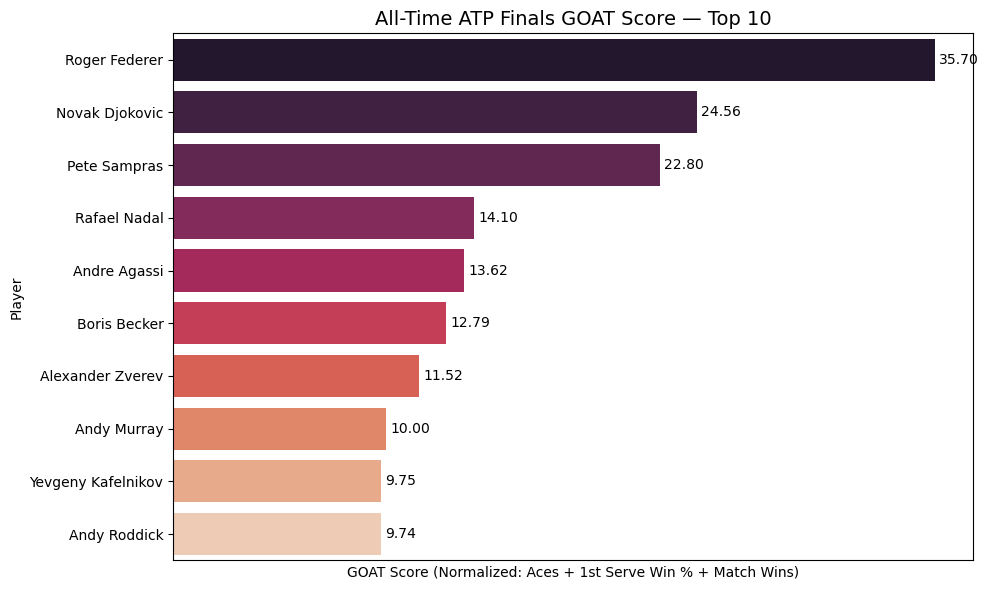

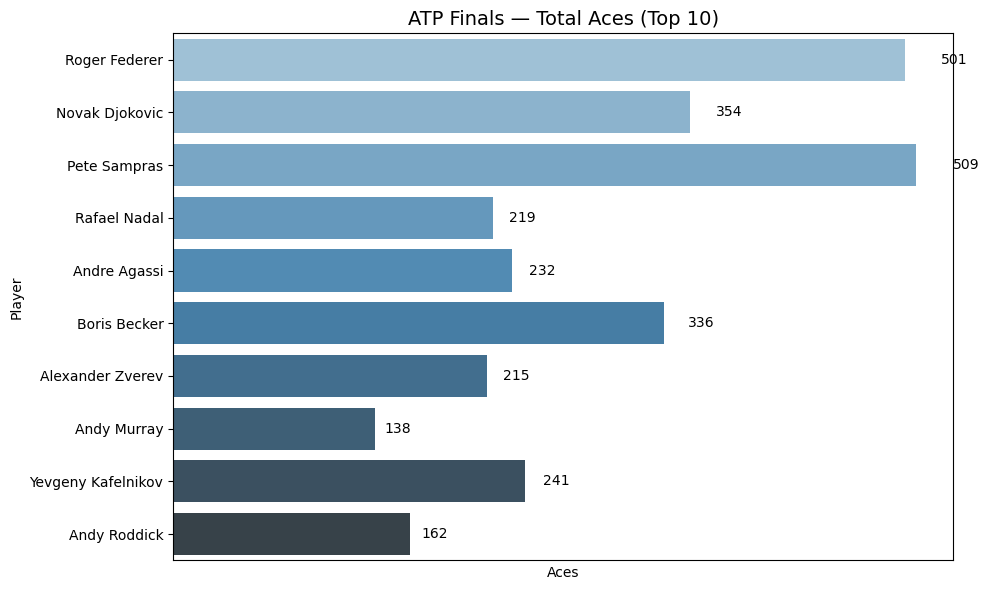

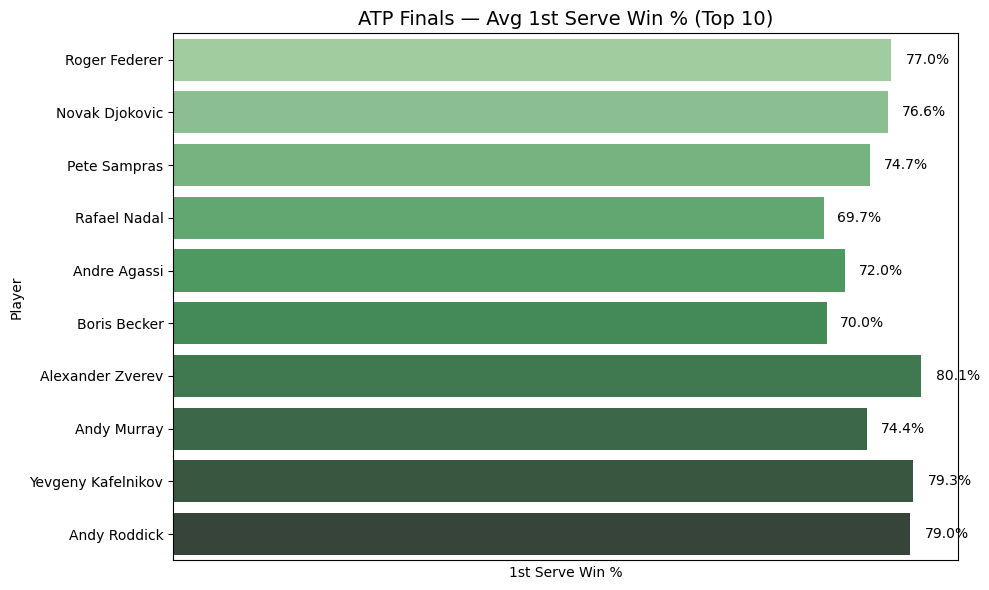

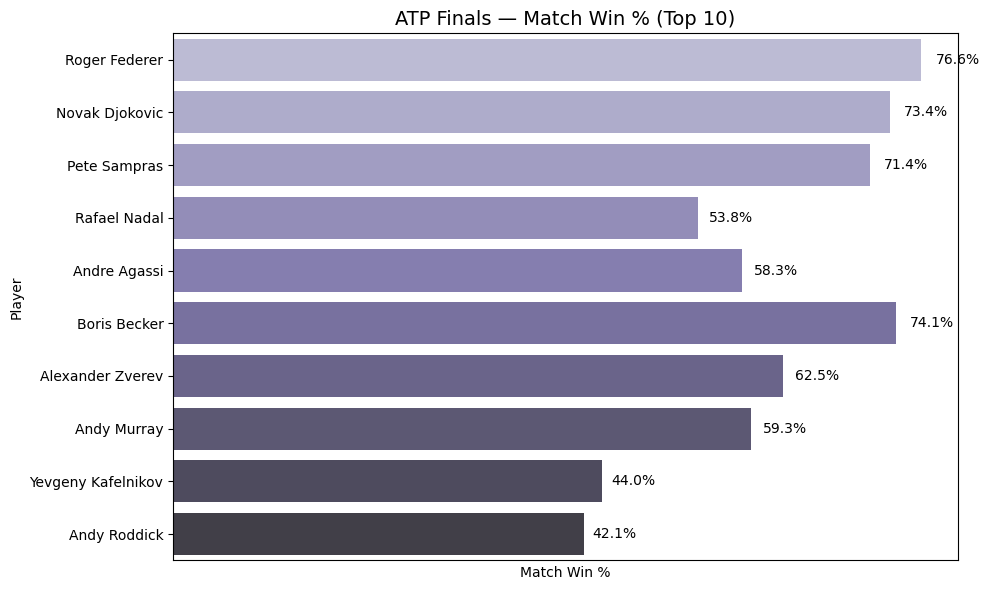

In [57]:

# Aggregate across all years
atp_goat_summary = player_year_stats.groupby('player').agg(
    total_aces=('aces', 'sum'),
    avg_1st_win_pct=('1st_win_pct', 'mean'),
    total_matches=('matches_played', 'sum'),
    total_wins=('matches_won', 'sum'),
    total_goat_score=('GOAT_score', 'sum')
).reset_index()

# Sort and take top 10
top10_atp_goats = atp_goat_summary.sort_values(by='total_goat_score', ascending=False).head(10)

# --- Plot: Total GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_atp_goats,
    x='total_goat_score',
    y='player',
    hue='player',
    palette='rocket',
    dodge=False,
    legend=False
)
plt.title("All-Time ATP Finals GOAT Score — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Normalized: Aces + 1st Serve Win % + Match Wins)")
plt.ylabel("Player")

for i, (score, name) in enumerate(zip(top10_atp_goats['total_goat_score'], top10_atp_goats['player'])):
    ax.text(score + 0.2, i, f"{score:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_atp_goats,
    x='total_aces',
    y='player',
    hue='player',
    palette='Blues_d',
    dodge=False,
    legend=False
)
plt.title("ATP Finals — Total Aces (Top 10)", fontsize=14)
plt.xlabel("Aces")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_atp_goats['total_aces'], top10_atp_goats['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_atp_goats,
    x='avg_1st_win_pct',
    y='player',
    hue='player',
    palette='Greens_d',
    dodge=False,
    legend=False
)
plt.title("ATP Finals — Avg 1st Serve Win % (Top 10)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_atp_goats['avg_1st_win_pct'], top10_atp_goats['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: Match Win % ---
top10_atp_goats['win_pct'] = top10_atp_goats['total_wins'] / top10_atp_goats['total_matches']

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_atp_goats,
    x='win_pct',
    y='player',
    hue='player',
    palette='Purples_d',
    dodge=False,
    legend=False
)
plt.title("ATP Finals — Match Win % (Top 10)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_atp_goats['win_pct'], top10_atp_goats['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## All-Time ATP Finals GOAT Rankings

This section ranks players based on their **cumulative performance** across all years at the **ATP Finals**, using match-level data.

#### Metrics calculated per player:
- **Total years** participated in the ATP Finals
- **Total matches played and won**
- **Career win %**
- **Total aces**
- **Career 1st serve win %**
- **Average GOAT score** from per-year rankings

#### GOAT Score Logic:
Each metric is **normalized across all players**, then combined into a final `GOAT_score`:
- Normalized **total aces**
- Normalized **career 1st serve win %**
- Normalized **career match win %**
- Average of **per-year GOAT scores**

The final table ranks players based on this cumulative performance-based score, giving a broader view of ATP Finals greatness beyond just titles won.


In [59]:
all_time_stats = player_year_stats.groupby('player').agg(
    total_years = ('year', 'count'),
    total_matches = ('matches_played', 'sum'),
    total_wins = ('matches_won', 'sum'),
    total_aces = ('aces', 'sum'),
    total_1st_won = ('total_1st_won', 'sum'),
    total_1st_in = ('total_1st_in', 'sum'),
    avg_goat_score = ('GOAT_score', 'mean')
).reset_index()

all_time_stats['career_win_pct'] = all_time_stats['total_wins'] / all_time_stats['total_matches']
all_time_stats['career_1st_win_pct'] = all_time_stats['total_1st_won'] / all_time_stats['total_1st_in']

# Normalize metrics across all players
scaler = MinMaxScaler()

all_time_stats['aces_norm'] = scaler.fit_transform(all_time_stats[['total_aces']])
all_time_stats['serve_norm'] = scaler.fit_transform(all_time_stats[['career_1st_win_pct']])
all_time_stats['win_norm'] = scaler.fit_transform(all_time_stats[['career_win_pct']])
all_time_stats['GOAT_score'] = (
    all_time_stats['aces_norm'] +
    all_time_stats['serve_norm'] +
    all_time_stats['win_norm'] +
    all_time_stats['avg_goat_score']
)

all_time_stats = all_time_stats.sort_values(by='GOAT_score', ascending=False)
all_time_stats['GOAT_rank'] = all_time_stats.reset_index().index + 1

# Print final all-time GOAT rankings for ATP Finals
print("All-Time ATP Finals GOAT Rankings — Based on Cumulative Performance Across All Years")
print(all_time_stats[['GOAT_rank', 'player', 'total_years', 'total_matches', 'total_wins', 
                      'career_win_pct', 'total_aces', 'career_1st_win_pct', 'avg_goat_score', 'GOAT_score']])

All-Time ATP Finals GOAT Rankings — Based on Cumulative Performance Across All Years
     GOAT_rank            player  total_years  total_matches  total_wins  \
45           1  Hamad Medjedovic            1              5           5   
95           2      Pete Sampras           11             49          35   
103          3     Roger Federer           17             77          59   
15           4      Boris Becker            6             27          20   
41           5   Grigor Dimitrov            1              5           5   
..         ...               ...          ...            ...         ...   
97         116    Radek Stepanek            1              2           0   
68         117      Karol Kucera            1              3           0   
51         118      Jakub Mensik            1              3           0   
10         119      Andres Gomez            1              3           0   
29         120    Emilio Sanchez            1              3           0   

  

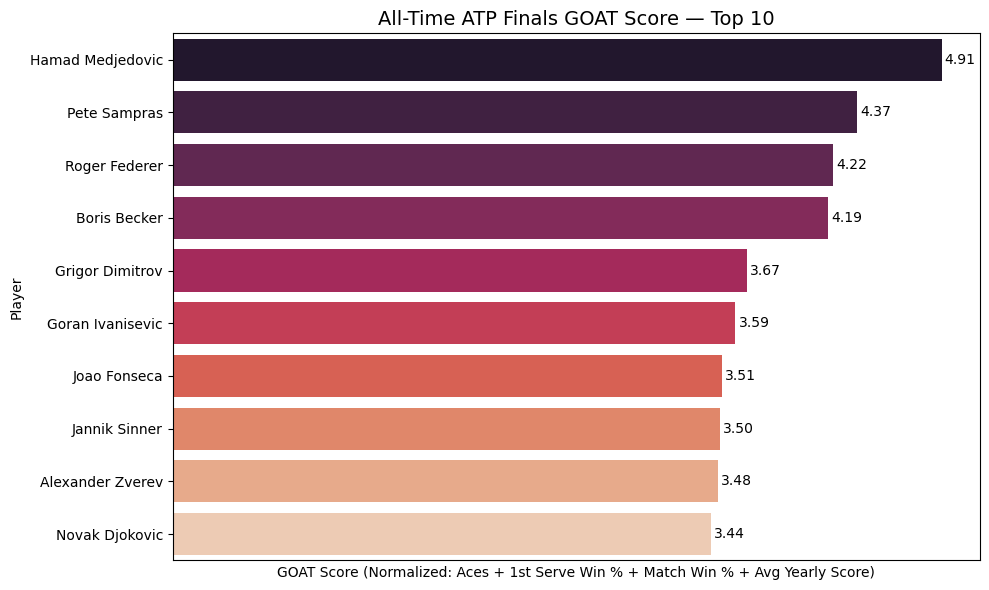

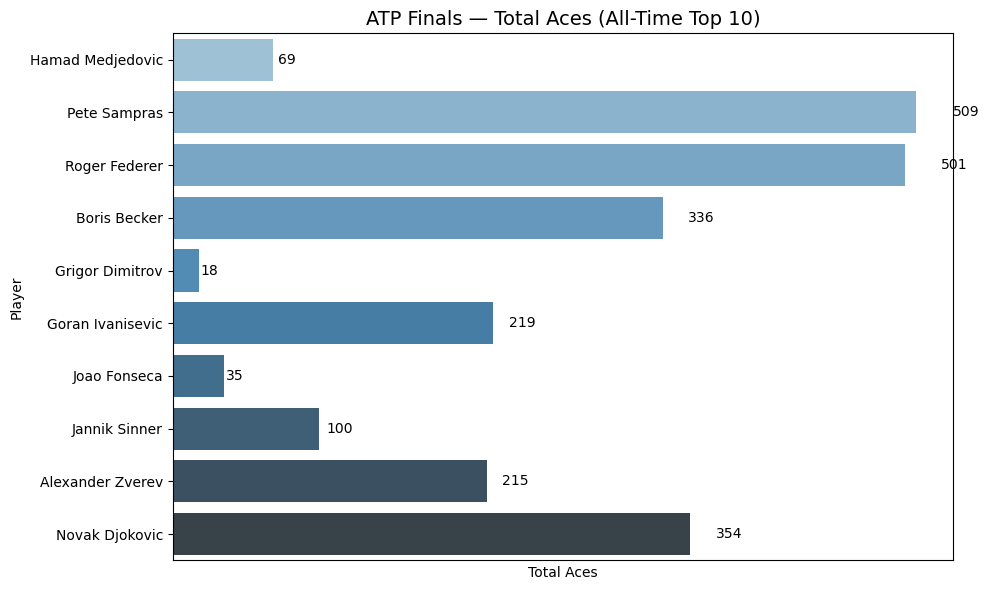

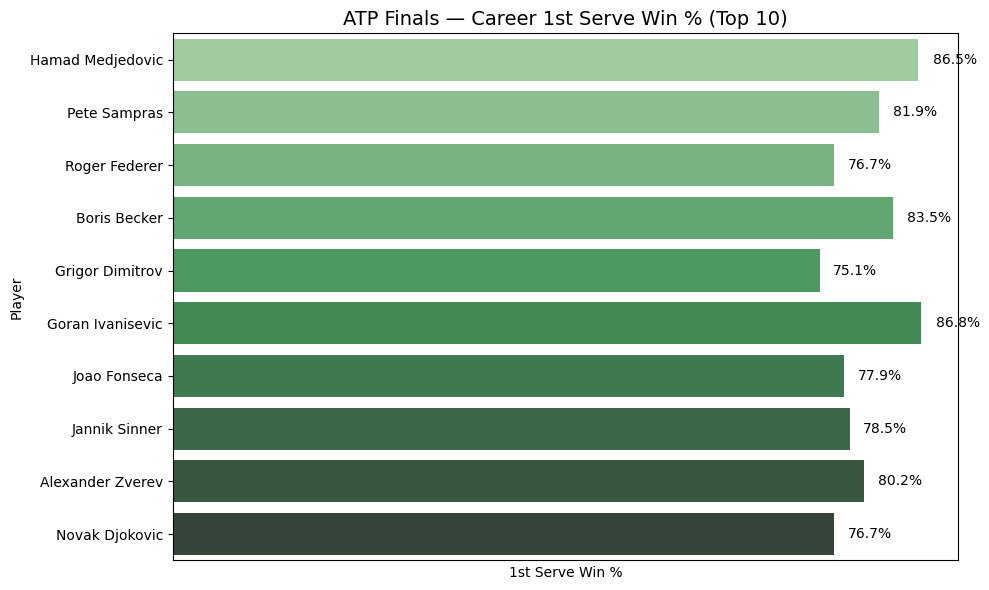

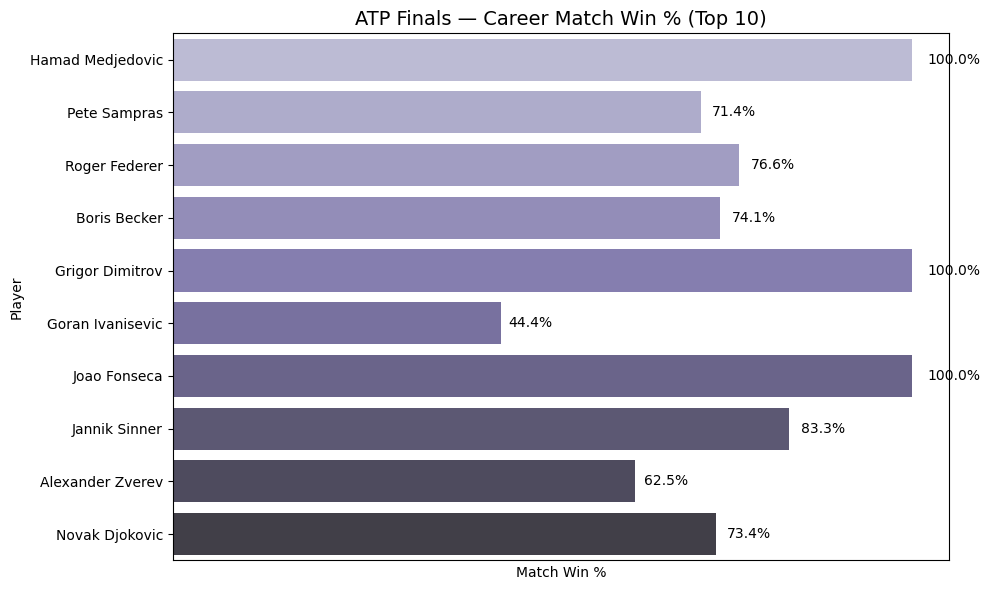

In [60]:
# Take Top 10 All-Time ATP Finals GOATs
top10_all_time = all_time_stats.head(10).copy()

# --- GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_all_time,
    x='GOAT_score',
    y='player',
    hue='player',
    palette='rocket',
    dodge=False,
    legend=False
)
plt.title("All-Time ATP Finals GOAT Score — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Normalized: Aces + 1st Serve Win % + Match Win % + Avg Yearly Score)")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_all_time['GOAT_score'], top10_all_time['player'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_all_time,
    x='total_aces',
    y='player',
    hue='player',
    palette='Blues_d',
    dodge=False,
    legend=False
)
plt.title("ATP Finals — Total Aces (All-Time Top 10)", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_all_time['total_aces'], top10_all_time['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Career 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_all_time,
    x='career_1st_win_pct',
    y='player',
    hue='player',
    palette='Greens_d',
    dodge=False,
    legend=False
)
plt.title("ATP Finals — Career 1st Serve Win % (Top 10)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_all_time['career_1st_win_pct'], top10_all_time['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Career Match Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10_all_time,
    x='career_win_pct',
    y='player',
    hue='player',
    palette='Purples_d',
    dodge=False,
    legend=False
)
plt.title("ATP Finals — Career Match Win % (Top 10)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_all_time['career_win_pct'], top10_all_time['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Olympic 

## Olympic Tennis GOAT Rankings (Per Year)

This section ranks players based on their **performance at each Olympic tennis tournament**, using match-level data.

#### What the code does:
- Filters all **Olympic matches** using:
  - `tourney_name` containing "Olympics"
  - or `tourney_level == 'O'` if present in the dataset
- Builds a **player-centric dataset** by combining match info for winners and losers
- Aggregates key performance stats per player per Olympic year:
  - Matches played and won
  - Total aces
  - 1st serve win %

#### GOAT Score Calculation:
Each player’s stats are **normalized within each Olympic year**, and a **GOAT score** is calculated based on:
- **Match win percentage**
- **Total aces**
- **1st serve win percentage**

Players are then ranked within each Olympic year using this combined performance score.

#### Output:
The final table shows:
- Each player’s performance per Olympic year
- Their normalized stats
- Their **GOAT score**
- Their **rank** within that year’s Olympic tournament


In [ ]:
# Filter matches from Olympic tournaments
olympics_matches = major_matches[
    (major_matches['tourney_name'].str.contains("Olympics", na=False)) |
    (major_matches['tourney_level'] == 'O')  # if available
].copy()

# Add winner/loser flags
olympics_matches['winner'] = olympics_matches['winner_name']
olympics_matches['loser'] = olympics_matches['loser_name']

# Create player-centric dataset
winners_df = olympics_matches.copy()
winners_df['player'] = winners_df['winner']
winners_df['won'] = 1

losers_df = olympics_matches.copy()
losers_df['player'] = losers_df['loser']
losers_df['won'] = 0

# Combine both sides
olympics_stats = pd.concat([winners_df, losers_df], ignore_index=True)

# Player performance per Olympic year
olympics_yearly = olympics_stats.groupby(['year', 'player']).agg(
    matches_played = ('won', 'count'),
    matches_won = ('won', 'sum'),
    aces = ('w_ace', 'sum'),
    total_1st_in = ('w_1stIn', 'sum'),
    total_1st_won = ('w_1stWon', 'sum')
).reset_index()

# Derived stats
olympics_yearly['win_pct'] = olympics_yearly['matches_won'] / olympics_yearly['matches_played']
olympics_yearly['1st_win_pct'] = olympics_yearly['total_1st_won'] / olympics_yearly['total_1st_in']
olympics_yearly['1st_win_pct'] = olympics_yearly['1st_win_pct'].fillna(0)

scaler = MinMaxScaler()

olympics_yearly['aces_norm'] = olympics_yearly.groupby('year')['aces'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
olympics_yearly['serve_norm'] = olympics_yearly.groupby('year')['1st_win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
olympics_yearly['win_norm'] = olympics_yearly.groupby('year')['win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# GOAT score = combination of all 3
olympics_yearly['GOAT_score'] = (
    olympics_yearly['aces_norm'] +
    olympics_yearly['serve_norm'] +
    olympics_yearly['win_norm']
)

olympics_yearly = olympics_yearly.sort_values(['year', 'GOAT_score'], ascending=[True, False])
olympics_yearly['GOAT_rank'] = olympics_yearly.groupby('year').cumcount() + 1

# Print results
start_year = olympics_yearly['year'].min()
end_year = olympics_yearly['year'].max()

print(f"Olympic Tennis GOAT Rankings ({start_year}–{end_year}) — Based on Match Wins, Aces, and 1st Serve Win %")
print(olympics_yearly[['year', 'player', 'matches_played', 'matches_won', 'aces', '1st_win_pct', 'win_pct', 'GOAT_score', 'GOAT_rank']])

Olympic Tennis GOAT Rankings (1992–2024) — Based on Match Wins, Aces, and 1st Serve Win %
     year              player  matches_played  matches_won  aces  1st_win_pct  \
41   1992         Marc Rosset               6            6   0.0     0.000000   
31   1992        Jordi Arrese               6            5   0.0     0.000000   
1    1992    Andrei Cherkasov               5            4   0.0     0.000000   
20   1992    Goran Ivanisevic               5            4   0.0     0.000000   
15   1992      Emilio Sanchez               4            3   0.0     0.000000   
..    ...                 ...             ...          ...   ...          ...   
527  2024       Dusan Lajovic               1            0   4.0     0.686567   
574  2024       Zhizhen Zhang               1            0   4.0     0.676923   
543  2024    Marton Fucsovics               1            0   1.0     0.696970   
569  2024  Tomas Barrios Vera               1            0   1.0     0.636364   
575  2024         Z

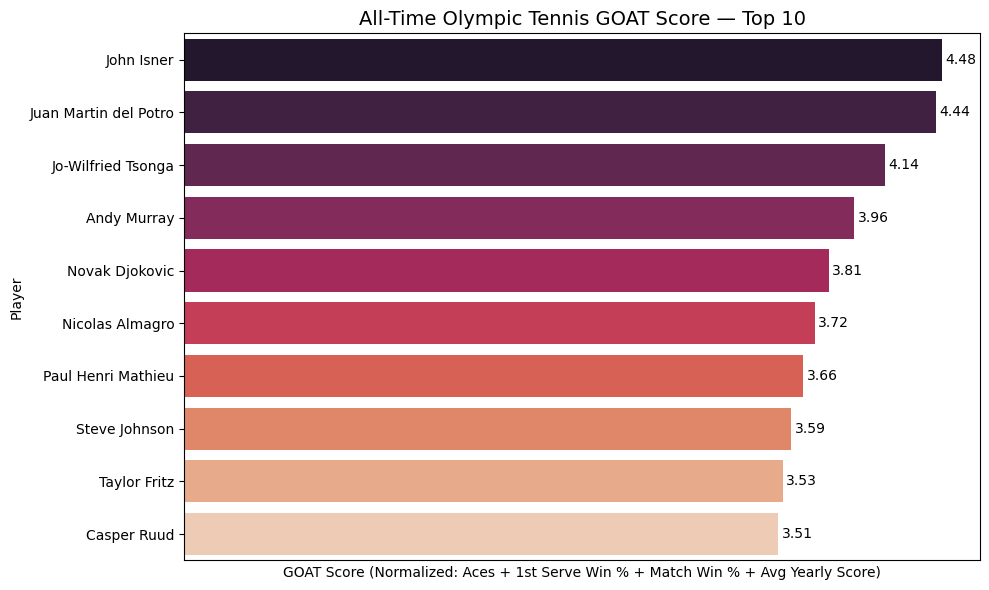

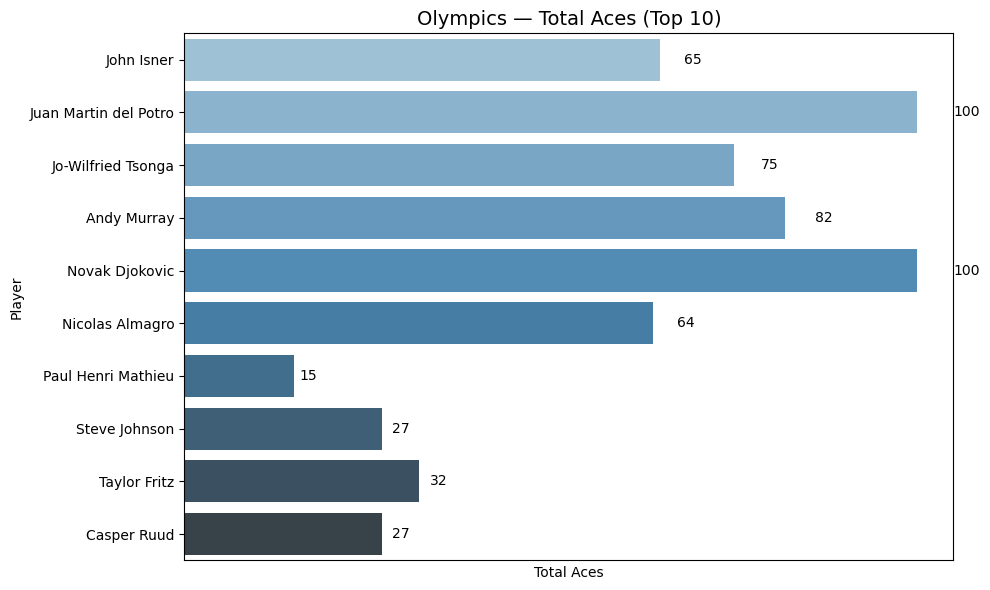

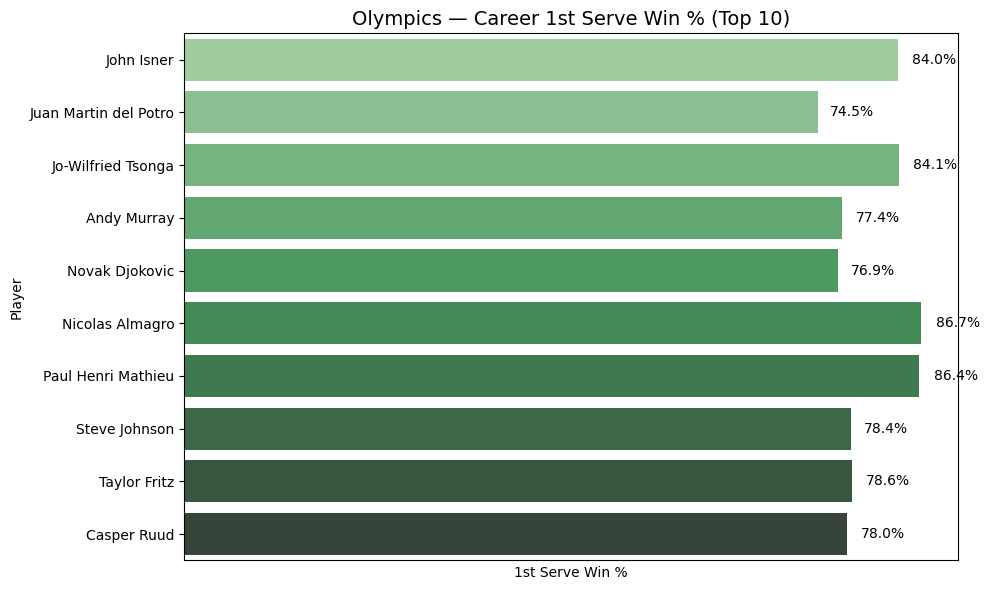

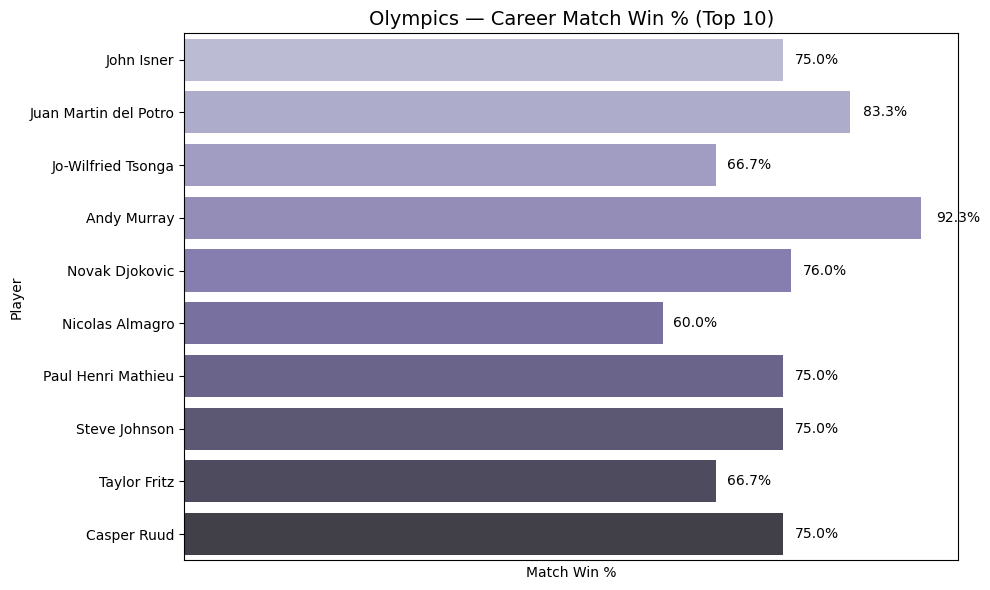

In [61]:
# Aggregate all Olympic data by player across all years
olympics_all_time = olympics_yearly.groupby('player').agg(
    total_years=('year', 'count'),
    total_matches=('matches_played', 'sum'),
    total_wins=('matches_won', 'sum'),
    total_aces=('aces', 'sum'),
    total_1st_won=('total_1st_won', 'sum'),
    total_1st_in=('total_1st_in', 'sum'),
    avg_goat_score=('GOAT_score', 'mean')
).reset_index()

# Derived stats
olympics_all_time['career_win_pct'] = olympics_all_time['total_wins'] / olympics_all_time['total_matches']
olympics_all_time['career_1st_win_pct'] = olympics_all_time['total_1st_won'] / olympics_all_time['total_1st_in']

# Normalize all-time
scaler = MinMaxScaler()
olympics_all_time['aces_norm'] = scaler.fit_transform(olympics_all_time[['total_aces']])
olympics_all_time['serve_norm'] = scaler.fit_transform(olympics_all_time[['career_1st_win_pct']])
olympics_all_time['win_norm'] = scaler.fit_transform(olympics_all_time[['career_win_pct']])

# Combine final GOAT score
olympics_all_time['GOAT_score'] = (
    olympics_all_time['aces_norm'] +
    olympics_all_time['serve_norm'] +
    olympics_all_time['win_norm'] +
    olympics_all_time['avg_goat_score']
)

olympics_all_time = olympics_all_time.sort_values(by='GOAT_score', ascending=False)
olympics_all_time['GOAT_rank'] = olympics_all_time.reset_index().index + 1

# Take Top 10
top10_olympics = olympics_all_time.head(10).copy()

import matplotlib.pyplot as plt
import seaborn as sns

# --- GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics, x='GOAT_score', y='player',
                 hue='player', palette='rocket', dodge=False, legend=False)
plt.title("All-Time Olympic Tennis GOAT Score — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Normalized: Aces + 1st Serve Win % + Match Win % + Avg Yearly Score)")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics['GOAT_score'], top10_olympics['player'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics, x='total_aces', y='player',
                 hue='player', palette='Blues_d', dodge=False, legend=False)
plt.title("Olympics — Total Aces (Top 10)", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics['total_aces'], top10_olympics['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics, x='career_1st_win_pct', y='player',
                 hue='player', palette='Greens_d', dodge=False, legend=False)
plt.title("Olympics — Career 1st Serve Win % (Top 10)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics['career_1st_win_pct'], top10_olympics['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Match Win % ---
top10_olympics['career_win_pct'] = top10_olympics['total_wins'] / top10_olympics['total_matches']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics, x='career_win_pct', y='player',
                 hue='player', palette='Purples_d', dodge=False, legend=False)
plt.title("Olympics — Career Match Win % (Top 10)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics['career_win_pct'], top10_olympics['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## All-Time Olympic Tennis GOAT Rankings

This section ranks players based on their **cumulative performance across all Olympic tournaments**.

#### Aggregated Stats:
For each player who participated in Olympic tennis events, the following metrics are calculated:
- **Total years** participated
- **Total matches played and won**
- **Total aces**
- **Career match win %**
- **Career 1st serve win %**
- **Average per-year GOAT score**

#### GOAT Score Calculation:
To ensure fair comparison across all players, the following metrics are **normalized across the entire dataset**:
- Total aces
- Career 1st serve win %
- Career win %
- Average yearly GOAT score

These are then combined into a final `GOAT_score`, representing **overall Olympic dominance**.

#### Final Output:
The resulting table displays:
- Each player's **all-time GOAT score**
- Their rank among all Olympic participants
- Key stats like total wins, aces, and serve performance

This provides a data-driven view of who performed best at the Olympic level, beyond just medal counts.


In [14]:
olympics_all_time = olympics_yearly.groupby('player').agg(
    total_years = ('year', 'count'),
    total_matches = ('matches_played', 'sum'),
    total_wins = ('matches_won', 'sum'),
    total_aces = ('aces', 'sum'),
    total_1st_won = ('total_1st_won', 'sum'),
    total_1st_in = ('total_1st_in', 'sum'),
    avg_goat_score = ('GOAT_score', 'mean')
).reset_index()

olympics_all_time['career_win_pct'] = olympics_all_time['total_wins'] / olympics_all_time['total_matches']
olympics_all_time['career_1st_win_pct'] = olympics_all_time['total_1st_won'] / olympics_all_time['total_1st_in']

# Normalize across all players
olympics_all_time['aces_norm'] = scaler.fit_transform(olympics_all_time[['total_aces']])
olympics_all_time['serve_norm'] = scaler.fit_transform(olympics_all_time[['career_1st_win_pct']])
olympics_all_time['win_norm'] = scaler.fit_transform(olympics_all_time[['career_win_pct']])

# Final GOAT score
olympics_all_time['GOAT_score'] = (
    olympics_all_time['aces_norm'] +
    olympics_all_time['serve_norm'] +
    olympics_all_time['win_norm'] +
    olympics_all_time['avg_goat_score']
)

olympics_all_time = olympics_all_time.sort_values(by='GOAT_score', ascending=False)
olympics_all_time['GOAT_rank'] = olympics_all_time.reset_index().index + 1

# Display top players
print("All-Time Olympic Tennis GOAT Rankings")
print(olympics_all_time[['GOAT_rank', 'player', 'total_years', 'total_matches', 'total_wins', 'career_win_pct', 'total_aces', 'career_1st_win_pct', 'GOAT_score']])

All-Time Olympic Tennis GOAT Rankings
     GOAT_rank                 player  total_years  total_matches  total_wins  \
180          1             John Isner            1              4           3   
188          2  Juan Martin del Potro            2             12          10   
176          3     Jo-Wilfried Tsonga            2              6           4   
30           4            Andy Murray            3             13          12   
275          5         Novak Djokovic            5             25          19   
..         ...                    ...          ...            ...         ...   
385        391         Wayne Ferreira            3              7           4   
386        392         Xavier Malisse            1              1           0   
389        393     Yevgeny Kafelnikov            1              6           6   
390        394     Yoshihito Nishioka            1              1           0   
391        395      Younes El Aynaoui            2              3      

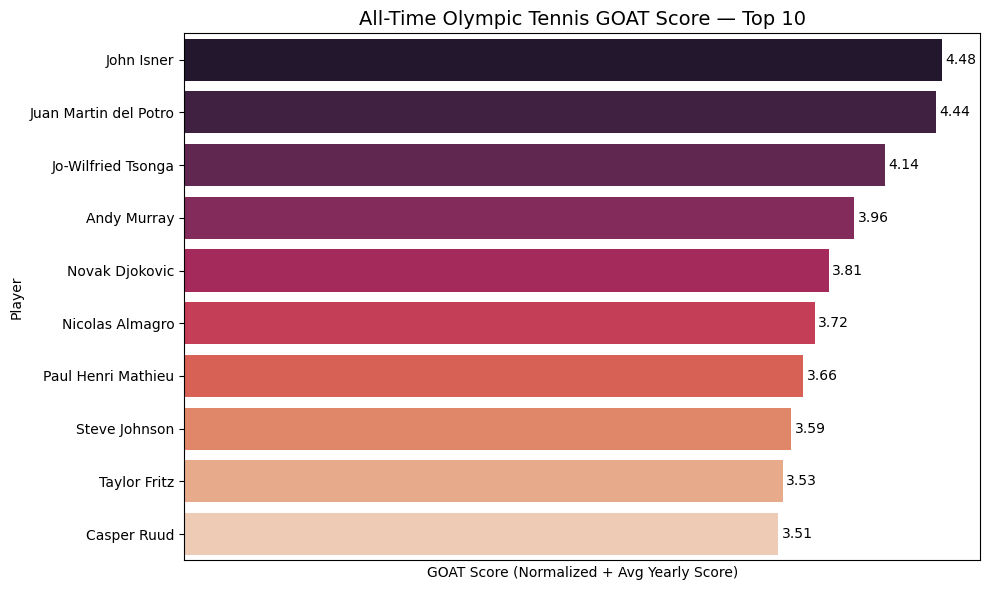

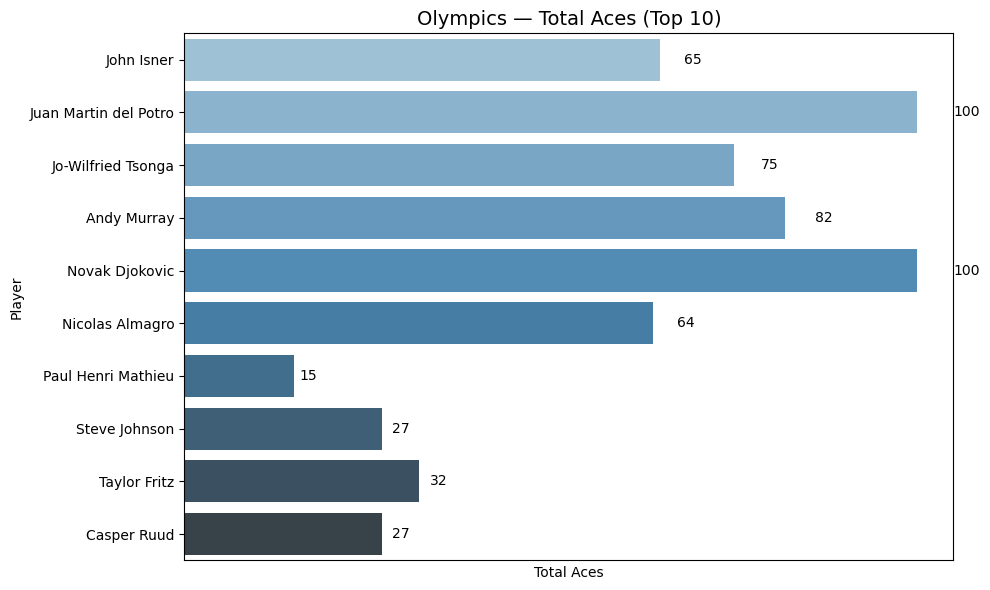

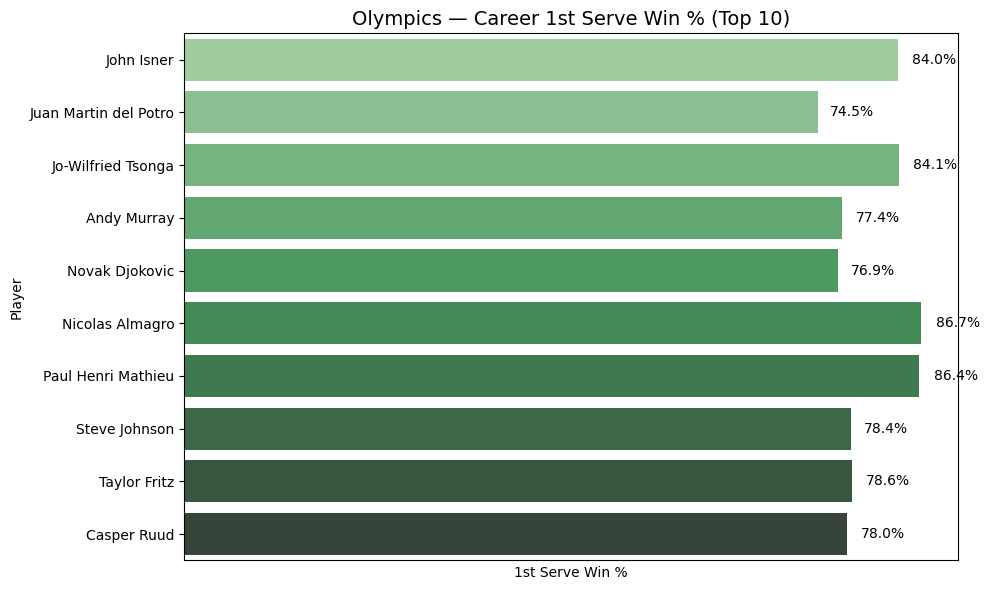

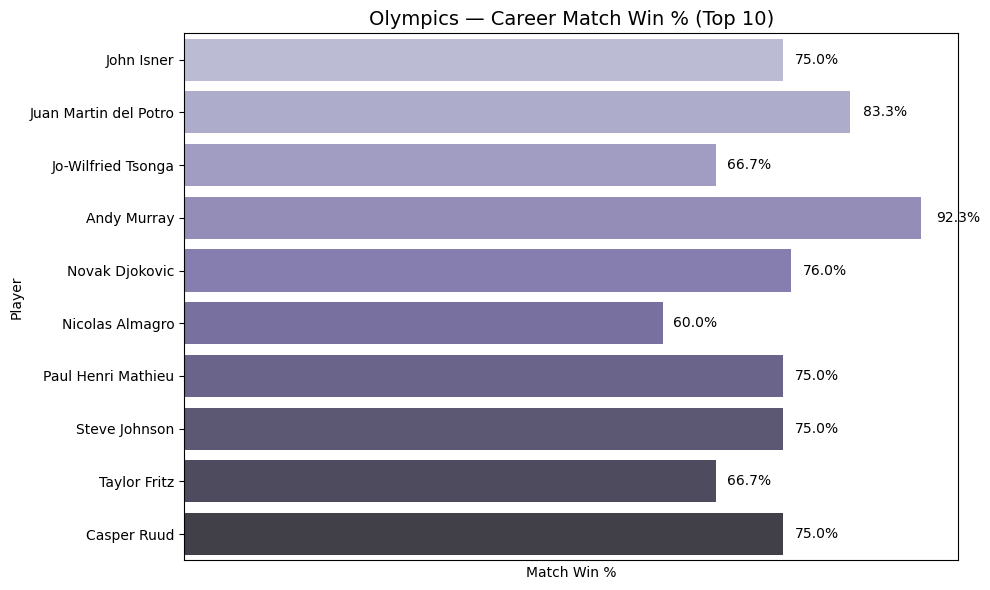

In [ ]:
# Take top 10 all-time Olympic GOATs
top10_olympics = olympics_all_time.head(10).copy()

# --- GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics, x='GOAT_score', y='player',
                 hue='player', palette='rocket', dodge=False, legend=False)
plt.title("All-Time Olympic Tennis GOAT Score — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Normalized + Avg Yearly Score)")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics['GOAT_score'], top10_olympics['player'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics, x='total_aces', y='player',
                 hue='player', palette='Blues_d', dodge=False, legend=False)
plt.title("Olympics — Total Aces (Top 10)", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics['total_aces'], top10_olympics['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics, x='career_1st_win_pct', y='player',
                 hue='player', palette='Greens_d', dodge=False, legend=False)
plt.title("Olympics — Career 1st Serve Win % (Top 10)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics['career_1st_win_pct'], top10_olympics['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Match Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_olympics, x='career_win_pct', y='player',
                 hue='player', palette='Purples_d', dodge=False, legend=False)
plt.title("Olympics — Career Match Win % (Top 10)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_olympics['career_win_pct'], top10_olympics['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## Masters 1000 GOAT Rankings (Per Year)

This section ranks players based on their performance in **ATP Masters 1000 tournaments**, calculated for **each year** using match-level data.

### What the code does:
- Filters matches from **Masters 1000 events** (`tourney_level == 'M'`)
- Builds a **player-centric dataset** combining both winners and losers
- Aggregates key performance stats per player per year:
  - Matches played and won
  - Total aces
  - First serve stats

### GOAT Score Calculation:
For each player in each year, the following metrics are calculated and **normalized within that year**:
- **Match win percentage**
- **Total aces**
- **1st serve win percentage**

These normalized values are then **combined into a single `GOAT_score`**, representing the player's overall performance and dominance across all Masters 1000 tournaments that season.

### Final Output:
Each player receives a `GOAT_rank` within their year, based on their total GOAT score.  
The final printed table displays:
- Year
- Player name
- Matches played and won
- Serve performance stats
- GOAT score and ranking

This allows for a more nuanced comparison of Masters 1000 performance beyond just counting titles.


In [15]:
masters_matches = major_matches[major_matches['tourney_level'] == 'M'].copy()

# Add outcome flags
masters_matches['winner'] = masters_matches['winner_name']
masters_matches['loser'] = masters_matches['loser_name']

# Create player-centric dataset
winners_df = masters_matches.copy()
winners_df['player'] = winners_df['winner']
winners_df['won'] = 1

losers_df = masters_matches.copy()
losers_df['player'] = losers_df['loser']
losers_df['won'] = 0

# Combine
masters_stats = pd.concat([winners_df, losers_df], ignore_index=True)

masters_yearly = masters_stats.groupby(['year', 'player']).agg(
    matches_played = ('won', 'count'),
    matches_won = ('won', 'sum'),
    aces = ('w_ace', 'sum'),
    total_1st_in = ('w_1stIn', 'sum'),
    total_1st_won = ('w_1stWon', 'sum')
).reset_index()

masters_yearly['win_pct'] = masters_yearly['matches_won'] / masters_yearly['matches_played']
masters_yearly['1st_win_pct'] = masters_yearly['total_1st_won'] / masters_yearly['total_1st_in']
masters_yearly['1st_win_pct'] = masters_yearly['1st_win_pct'].fillna(0)

scaler = MinMaxScaler()

masters_yearly['aces_norm'] = masters_yearly.groupby('year')['aces'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
masters_yearly['serve_norm'] = masters_yearly.groupby('year')['1st_win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)
masters_yearly['win_norm'] = masters_yearly.groupby('year')['win_pct'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

masters_yearly['GOAT_score'] = (
    masters_yearly['aces_norm'] +
    masters_yearly['serve_norm'] +
    masters_yearly['win_norm']
)

masters_yearly = masters_yearly.sort_values(['year', 'GOAT_score'], ascending=[True, False])
masters_yearly['GOAT_rank'] = masters_yearly.groupby('year').cumcount() + 1

start_year = masters_yearly['year'].min()
end_year = masters_yearly['year'].max()

print(f"Masters 1000 GOAT Rankings ({start_year}–{end_year}) — Based on Match Wins, Aces, and 1st Serve Win %")
print(masters_yearly[['year', 'player', 'matches_played', 'matches_won', 'aces', '1st_win_pct', 'win_pct', 'GOAT_score', 'GOAT_rank']])



Masters 1000 GOAT Rankings (1990–2024) — Based on Match Wins, Aces, and 1st Serve Win %
      year                   player  matches_played  matches_won  aces  \
166   1990            Thomas Muster              12           11   0.0   
161   1990            Stefan Edberg              28           25   0.0   
13    1990             Boris Becker              24           19   0.0   
129   1990            Nicklas Kulti               4            3   0.0   
131   1990           Omar Camporese               4            3   0.0   
...    ...                      ...             ...          ...   ...   
4991  2024           Federico Coria               1            0   3.0   
5007  2024              Hugo Gaston               1            0   1.0   
4956  2024  Bernabe Zapata Miralles               1            0   3.0   
4978  2024              Denis Kudla               1            0   5.0   
5088  2024           Vasek Pospisil               1            0   0.0   

      1st_win_pct   win

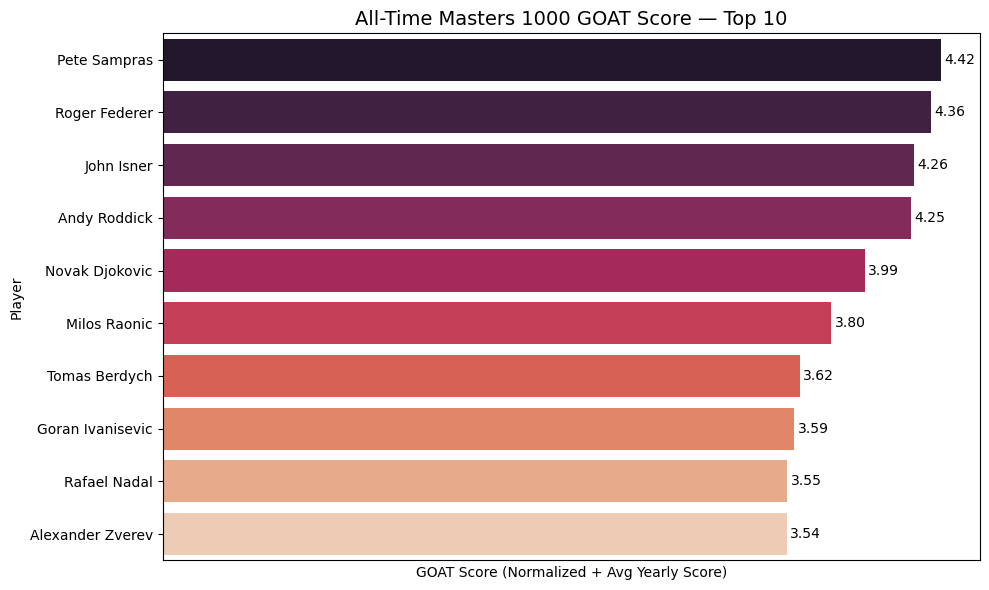

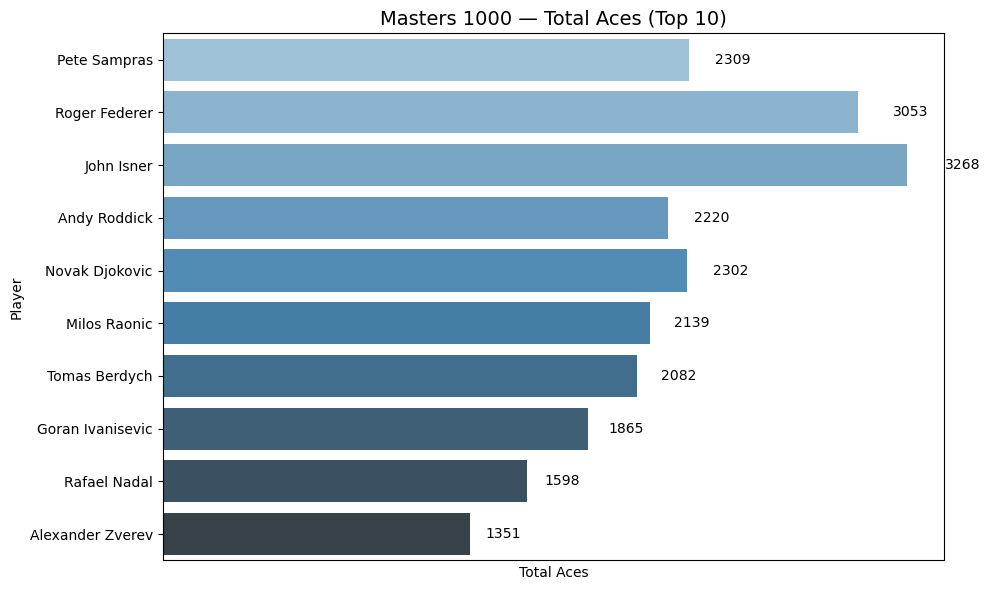

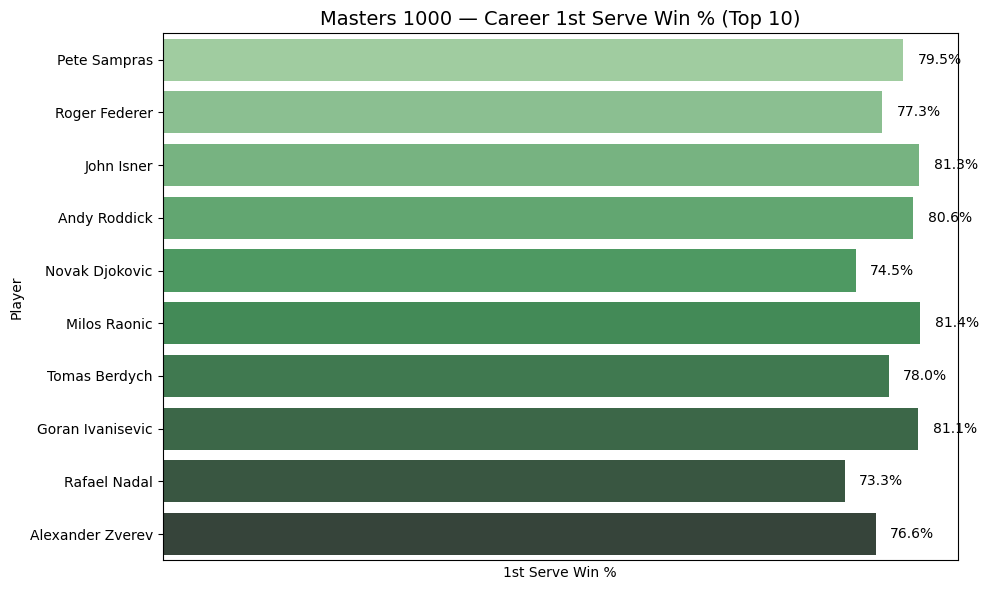

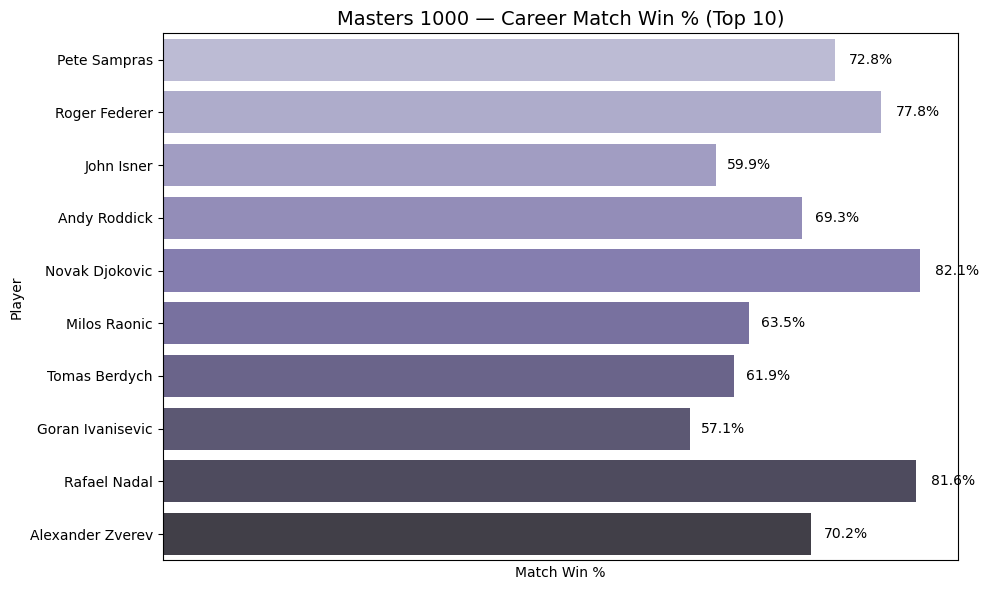

In [63]:
masters_all_time = masters_yearly.groupby('player').agg(
    total_years=('year', 'count'),
    total_matches=('matches_played', 'sum'),
    total_wins=('matches_won', 'sum'),
    total_aces=('aces', 'sum'),
    total_1st_won=('total_1st_won', 'sum'),
    total_1st_in=('total_1st_in', 'sum'),
    avg_goat_score=('GOAT_score', 'mean')
).reset_index()

# Derived career stats
masters_all_time['career_win_pct'] = masters_all_time['total_wins'] / masters_all_time['total_matches']
masters_all_time['career_1st_win_pct'] = masters_all_time['total_1st_won'] / masters_all_time['total_1st_in']

# Normalize across all players
scaler = MinMaxScaler()
masters_all_time['aces_norm'] = scaler.fit_transform(masters_all_time[['total_aces']])
masters_all_time['serve_norm'] = scaler.fit_transform(masters_all_time[['career_1st_win_pct']])
masters_all_time['win_norm'] = scaler.fit_transform(masters_all_time[['career_win_pct']])

# Final GOAT Score
masters_all_time['GOAT_score'] = (
    masters_all_time['aces_norm'] +
    masters_all_time['serve_norm'] +
    masters_all_time['win_norm'] +
    masters_all_time['avg_goat_score']
)

# Rank
masters_all_time = masters_all_time.sort_values(by='GOAT_score', ascending=False)
masters_all_time['GOAT_rank'] = masters_all_time.reset_index().index + 1

# Top 10
top10_masters = masters_all_time.head(10).copy()

import matplotlib.pyplot as plt
import seaborn as sns

# --- GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_masters, x='GOAT_score', y='player',
                 hue='player', palette='rocket', dodge=False, legend=False)
plt.title("All-Time Masters 1000 GOAT Score — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Normalized + Avg Yearly Score)")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_masters['GOAT_score'], top10_masters['player'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_masters, x='total_aces', y='player',
                 hue='player', palette='Blues_d', dodge=False, legend=False)
plt.title("Masters 1000 — Total Aces (Top 10)", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_masters['total_aces'], top10_masters['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_masters, x='career_1st_win_pct', y='player',
                 hue='player', palette='Greens_d', dodge=False, legend=False)
plt.title("Masters 1000 — Career 1st Serve Win % (Top 10)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_masters['career_1st_win_pct'], top10_masters['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Match Win % ---
top10_masters['career_win_pct'] = top10_masters['total_wins'] / top10_masters['total_matches']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_masters, x='career_win_pct', y='player',
                 hue='player', palette='Purples_d', dodge=False, legend=False)
plt.title("Masters 1000 — Career Match Win % (Top 10)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_masters['career_win_pct'], top10_masters['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## All-Time Masters 1000 GOAT Rankings

This section ranks players based on their **cumulative performance** across all **Masters 1000 tournaments** in the dataset.

### Aggregated Metrics per Player:
The code calculates long-term performance using the following:
- `total_years`: Number of years the player appeared in Masters 1000 events
- `total_matches` and `total_wins`: Used to compute career **match win %**
- `total_aces`: Total aces served in all matches
- `career_1st_win_pct`: Efficiency on 1st serve, across all years
- `avg_goat_score`: Average of the player’s yearly GOAT scores (from per-year analysis)

### GOAT Score Calculation:
Each metric is **normalized across all players** using `MinMaxScaler`, and the final GOAT score is computed as:



In [ ]:
masters_all_time = masters_yearly.groupby('player').agg(
    total_years = ('year', 'count'),
    total_matches = ('matches_played', 'sum'),
    total_wins = ('matches_won', 'sum'),
    total_aces = ('aces', 'sum'),
    total_1st_won = ('total_1st_won', 'sum'),
    total_1st_in = ('total_1st_in', 'sum'),
    avg_goat_score = ('GOAT_score', 'mean')
).reset_index()

masters_all_time['career_win_pct'] = masters_all_time['total_wins'] / masters_all_time['total_matches']
masters_all_time['career_1st_win_pct'] = masters_all_time['total_1st_won'] / masters_all_time['total_1st_in']
masters_all_time['career_1st_win_pct'] = masters_all_time['career_1st_win_pct'].fillna(0)

masters_all_time['aces_norm'] = scaler.fit_transform(masters_all_time[['total_aces']])
masters_all_time['serve_norm'] = scaler.fit_transform(masters_all_time[['career_1st_win_pct']])
masters_all_time['win_norm'] = scaler.fit_transform(masters_all_time[['career_win_pct']])

masters_all_time['GOAT_score'] = (
    masters_all_time['aces_norm'] +
    masters_all_time['serve_norm'] +
    masters_all_time['win_norm'] +
    masters_all_time['avg_goat_score']
)

masters_all_time = masters_all_time.sort_values(by='GOAT_score', ascending=False)
masters_all_time['GOAT_rank'] = masters_all_time.reset_index().index + 1

print("All-Time Masters 1000 GOAT Rankings")
print(masters_all_time[['GOAT_rank', 'player', 'total_years', 'total_matches', 'total_wins', 'career_win_pct', 'total_aces', 'career_1st_win_pct', 'GOAT_score']])


All-Time Masters 1000 GOAT Rankings
     GOAT_rank                 player  total_years  total_matches  total_wins  \
791          1           Pete Sampras           13            265         193   
855          2          Roger Federer           21            496         386   
499          3             John Isner           17            242         145   
87           4           Andy Roddick           13            228         158   
747          5         Novak Djokovic           20            507         416   
..         ...                    ...          ...            ...         ...   
958       1032           Tim Wilkison            1              1           0   
320       1033  Francesco Cancellotti            1              1           0   
564       1034        Krister Wedenby            1              1           0   
140       1035           Brian Gyetko            1              1           0   
503       1036              John Ross            1              1        

### All-Time Masters 1000 GOATs — Top 10 Visualization

This section generates a **horizontal bar chart** displaying the **Top 10 players** in Masters 1000 history based on their final GOAT score.

#### What the code does:
- Selects the **top 10 players** from the all-time Masters 1000 GOAT rankings
- Sorts them by `GOAT_score` in descending order
- Plots a horizontal bar chart using:
  - `GOAT_score` on the x-axis
  - Player names on the y-axis
  - Distinct colors via `hue='player'` and `palette='viridis'`

#### Purpose:
This chart provides a **visual summary** of the most dominant players in Masters 1000 tournaments, based on a combined metric that accounts for:
- Aces
- 1st serve win %
- Match win %
- Average yearly performance

It makes it easy to compare how the legends of the sport stack up against each other over the course of their careers.


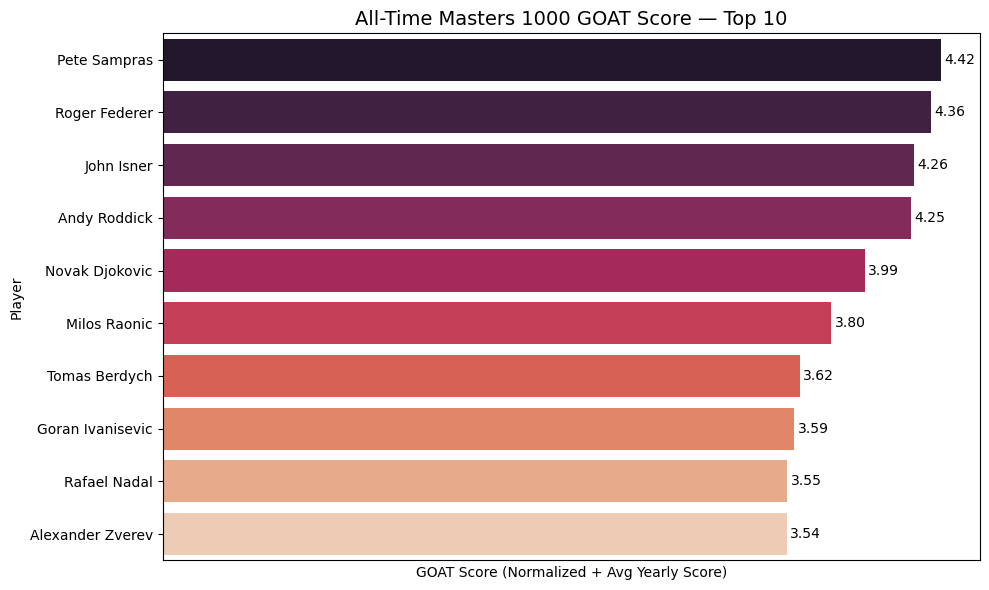

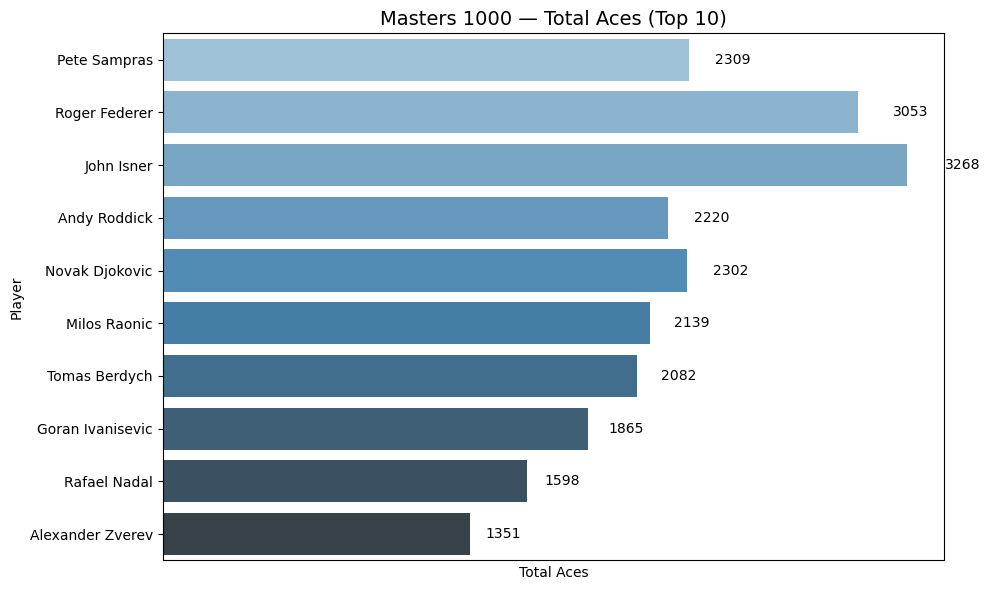

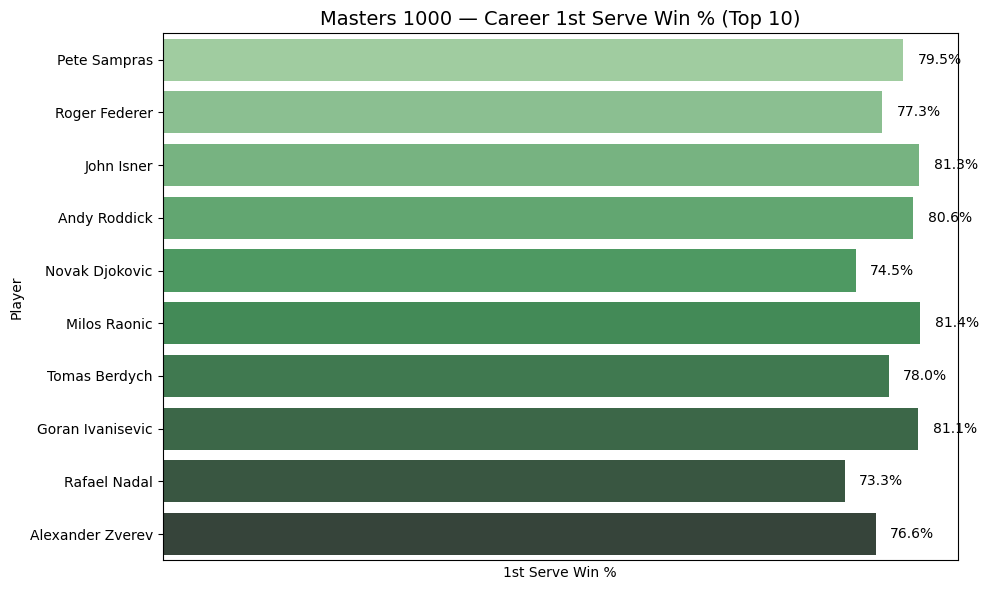

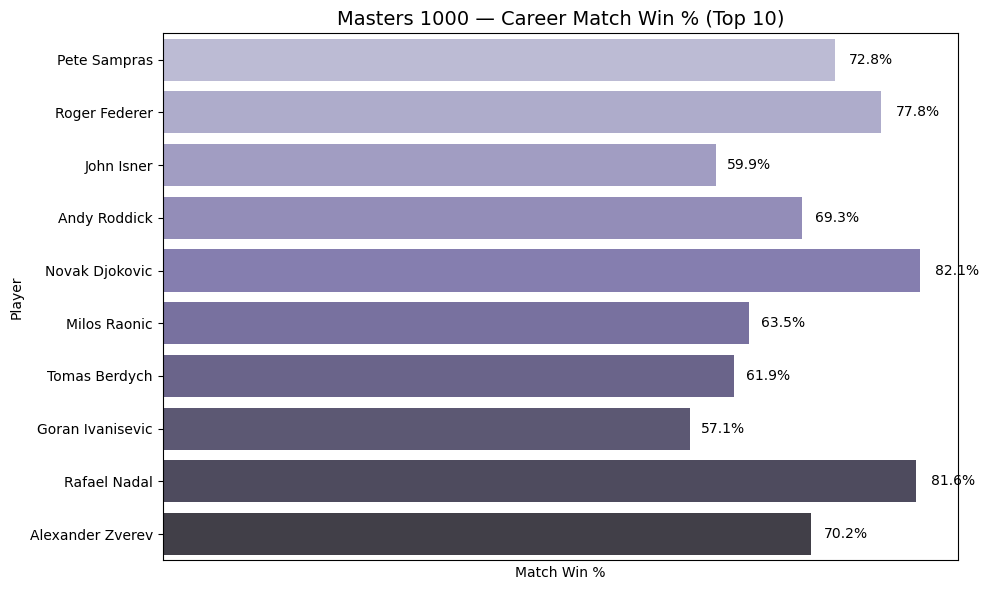

In [ ]:
# Select top 10 GOATs
top10_masters = masters_all_time.head(10).copy()

# --- GOAT Score ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_masters, x='GOAT_score', y='player',
                 hue='player', palette='rocket', dodge=False, legend=False)
plt.title("All-Time Masters 1000 GOAT Score — Top 10", fontsize=14)
plt.xlabel("GOAT Score (Normalized + Avg Yearly Score)")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_masters['GOAT_score'], top10_masters['player'])):
    ax.text(val + 0.02, i, f"{val:.2f}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Total Aces ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_masters, x='total_aces', y='player',
                 hue='player', palette='Blues_d', dodge=False, legend=False)
plt.title("Masters 1000 — Total Aces (Top 10)", fontsize=14)
plt.xlabel("Total Aces")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_masters['total_aces'], top10_masters['player'])):
    offset = val * 0.05
    ax.text(val + offset, i, f"{int(val)}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Career 1st Serve Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_masters, x='career_1st_win_pct', y='player',
                 hue='player', palette='Greens_d', dodge=False, legend=False)
plt.title("Masters 1000 — Career 1st Serve Win % (Top 10)", fontsize=14)
plt.xlabel("1st Serve Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_masters['career_1st_win_pct'], top10_masters['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# --- Career Match Win % ---
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top10_masters, x='career_win_pct', y='player',
                 hue='player', palette='Purples_d', dodge=False, legend=False)
plt.title("Masters 1000 — Career Match Win % (Top 10)", fontsize=14)
plt.xlabel("Match Win %")
plt.ylabel("Player")

for i, (val, name) in enumerate(zip(top10_masters['career_win_pct'], top10_masters['player'])):
    offset = val * 0.02
    ax.text(val + offset, i, f"{val:.1%}", va='center', fontsize=10)

plt.xticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
